In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon May 22 14:13:15 2023

@author: souchaud
"""
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import sys
import shutil

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device for torch operations:", device)

Device for torch operations: cpu


In [3]:
def force_field_inbox(coordinates_diff, distances, Req, R0, Frep, Fadh,
                      coeff_a = None, coeff_rep = None):
    """
    Calculate the force field within the focal box.

    Parameters
    ----------
    - coordinates_diff: Tensor representing the positions of particles in the focal box.

    Returns
    -------
    - force_field: Tensor representing the force field within the focal box.

    """  
    Rlim = 0.000001
    R = torch.norm(coordinates_diff, dim=2)
    # prevents the repulsion force from exploding when approaching its maximum value
    R = torch.where(R > Rlim*torch.ones(1, device=device),
                  R, Rlim*torch.ones(1, device=device)).to(device)
    
    ###########  R**2 adhesion force ###########
    # a = coeff_a
    # b = (Fadh-a*(R0**2-Req**2))/(R0-Req)
    # c = -Req*(a*Req+ (Fadh-a*(R0**2-Req**2))/(R0-Req))
    # force = torch.where(torch.logical_and(R < R0, R > Req),
    #                     -(a*R**2+b*R+c), torch.zeros_like(R)).to(device)
    
    ########### a*R**alpha + b ############
    alpha = coeff_a
    # force = torch.where(torch.logical_and(R < R0, R > Req),
    #                     -(Fadh/((R0**alpha)-(Req**alpha)))*((R**alpha)-(Req**alpha)), torch.zeros_like(R)).to(device)
    force = torch.where(torch.logical_and(R < R0, R > Req),
                        function_adh(R, Req, R0, Fadh, alpha, coeff_a=coeff_a), torch.zeros_like(R)).to(device)

    # The repulsion force is calculated wherever R<Req
    ########### Linear adhesion force ########### 
    # force = torch.where(torch.logical_and(R < R0, R > Req),
    #                     -((Fadh/(R0-Req))*R-Fadh*Req/(R0-Req)), torch.zeros_like(R)).to(device)

    ###########  Repulsion force linear ########## 
    # force = torch.where(R < Req,
    #                     - Frep*R*(1/Req-1/R), force).to(device)
    ########### Repulsion forces in 1/R ########### 
    force = torch.where(R <= Req,
                        - Frep*coeff_rep*(1/Req-1/R), force).to(device)

    force_field = torch.sum(force[:, :, None] *
                            torch.nn.functional.normalize(coordinates_diff, dim = 2), axis=1)

    return force_field


def function_adh(R, Req, R0, Fadh, alpha, coeff_a):
    # a = coeff_a
    # b = (Fadh-a*(R0**2-Req**2))/(R0-Req)
    # c = -Req*(a*Req+ (Fadh-a*(R0**2-Req**2))/(R0-Req))
    # return -(a*R**2+b*R+c)
    return -((Fadh/(R0-Req))*R-Fadh*Req/(R0-Req))

# def function_adh(R, Req, R0, Fadh, alpha,):
#     return -(Fadh/((R0-Req)**alpha))*((R-Req)**alpha)

def autovel(dX, n, tau, noise, dt):
    """
    Compute the new cells direction.

    Parameters
    ----------
    dX : déplacement
        DESCRIPTION.
    n : direction
        DESCRIPTION.

    Returns
    -------
    n : TYPE
        DESCRIPTION.

    """
    # Compute the angle between the input vector and the x-axis
    theta = torch.atan2(dX[:, 1], dX[:, 0]).to(device)
    # Compute the absolute value of the input vector
    # dXabs = torch.norm(dX, p=2, dim=1).to(device)
    # Normalize the input vector and slightly reduce its magnitude
    dX_norm = torch.nn.functional.normalize(dX, dim = 1)*0.9999999
    # Compute the change in angle based on the orientation vector (n)
    dtheta = torch.arcsin(
        (n[:, 0] * dX_norm[:, 1] - n[:, 1] * dX_norm[:, 0])) * dt / tau
    # Generate random noise for angle perturbation
    rnd = noise * (2 * math.pi * (torch.rand(len(dX), 1,
                    device=device) - 0.5)) * np.sqrt(dt)
    # Update the angle by adding the change in angle, random noise, and the previous angle
    theta += dtheta + rnd[:, 0]
    # Update the orientation vector (n) based on the updated angle
    # n[:, 0] = torch.cos(theta)
    # n[:, 1] = torch.sin(theta)
    n[:, 0].copy_(torch.cos(theta))
    n[:, 1].copy_(torch.sin(theta))
    return n


def plot_environment(cells, space_size,req, path_saving=None, iteration=None):
    fig, axis = plt.subplots(figsize=(6, 6))
    plt.xlim(0, space_size)
    plt.ylim(0, space_size)

    # Combine cells from both populations
    all_cells = population1.cells + population2.cells

    # Extract x and y coordinates
    x = [cell.position[0].item() for cell in all_cells]
    y = [cell.position[1].item() for cell in all_cells]

    # Create a list of colors corresponding to each cell
    colors = ['blue'] * len(population1.cells) + \
        ['red'] * len(population2.cells)

    # Plot all cells at once with the specified colors
    axis.scatter(x, y, s=3, color=colors,alpha=0.5, rasterized=True)

    # plt.title('Cell Movement')
    plt.xlabel('X position (micrometers)')
    plt.ylabel('Y position (micrometers)')
    # plt.axis('off')
    plt.axis('off')
    plt.savefig(f'{path_saving}image_{iteration}.png',
                bbox_inches='tight', dpi=400, pad_inches = 0)

    plt.show()
    plt.close()
    print(iteration)


def plot_function(pas, Req, R0, Frep, Fadh, a, coeff_rep):

    b = (Fadh-a*(R0**2-Req**2))/(R0-Req)
    c = -Req*(a*Req + (Fadh-a*(R0**2-Req**2))/(R0-Req))

    fig, axis = plt.subplots(figsize=(6, 6))
    plt.xlim(0, R0)
    plt.ylim(-Frep, Fadh)

    print("Req = ", Req)
    print("R0 = ", R0)
    print("Fadh = ", Fadh)
    print("Frep = ", Frep)

    axis.plot(np.arange(pas, Req, pas), [
              R*Frep*(1/Req-1/R) for R in np.arange(pas, Req, pas)], label='rep Mathieu')
    axis.plot(np.arange(pas, Req, pas), [
              Frep*coeff_rep*(1/Req-1/R) for R in np.arange(pas, Req, pas)], label='rep Alex')

    axis.plot(np.arange(Req, R0, pas), [
              (Fadh/(R0-Req))*(R-Req) for R in np.arange(Req, R0, pas)], label='adhline')
    axis.plot(np.arange(Req, R0, pas), [-function_adh(R, Req, R0, Fadh, alpha=0.5, coeff_a=30)
                                        for R in np.arange(Req, R0, pas)], alpha=0.5, label='adh_Alex')
    axis.plot(np.arange(Req, R0, pas), [(a*R**2+b*R+c)
              for R in np.arange(Req, R0, pas)], label="square")

    # (Fadh/(R0-Req))*R+Fadh*Req/(R0-Req)

    plt.xlabel('Distance')
    plt.ylabel('Force')
    plt.legend()
    plt.show()

In [4]:
class CellAgent:
    def __init__(self, position, velocity, velocity_magnitude, persistence, space_size):
        # We add the inital position to make some calc later.
        self.position_init = position.clone().to(device)
        self.position = position.clone().to(device)
        self.velocity = velocity.clone().to(device)
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.space_size = space_size
        self.direction = torch.nn.functional.normalize(velocity, p=2, dim=0)


In [5]:
class Population:
    def __init__(self, num_cells, space_size, velocity_magnitude, persistence, min_distance):
        self.num_cells = num_cells
        self.space_size = space_size
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.min_distance = min_distance
        self.cells = []
        self.initialize_cells()

    def initialize_cells(self):
        positions = torch.rand((self.num_cells, 2), device=device) * self.space_size
        velocities = torch.nn.functional.normalize(torch.empty_like(positions).uniform_(-1, 1), dim=1) * self.velocity_magnitude

        if self.min_distance != 0:
          # Create a grid with cell size equal to the minimum distance
          grid_size = int(np.ceil(self.space_size / self.min_distance))
          grid = [[[] for _ in range(grid_size)] for _ in range(grid_size)]

          valid_positions = []
          for i in range(self.num_cells):
              valid = True

              # Compute the cell's grid indices
              grid_x = int(positions[i, 0] / self.min_distance)
              grid_y = int(positions[i, 1] / self.min_distance)

              # Check neighboring cells in the grid
              for dx in [-1, 0, 1]:
                  for dy in [-1, 0, 1]:
                      nx = grid_x + dx
                      ny = grid_y + dy

                      # Check if the neighboring grid cell is valid
                      if 0 <= nx < grid_size and 0 <= ny < grid_size:
                          for cell_pos in grid[nx][ny]:
                              # Check the distance between the current cell and the neighboring cells
                              if torch.norm(positions[i] - cell_pos) < self.min_distance:
                                  valid = False
                                  break
                      if not valid:
                          break
                  if not valid:
                      break
              if valid:
                  # Add the cell position to the grid
                  grid[grid_x][grid_y].append(positions[i])
                  valid_positions.append(positions[i])
              else:
                  # Generate a new random position until a valid one is found
                  while not valid:
                      positions[i] = torch.rand((1, 2), device=device) * self.space_size

                      # Compute the updated cell's grid indices
                      grid_x = int(positions[i, 0] / self.min_distance)
                      grid_y = int(positions[i, 1] / self.min_distance)

                      # Check neighboring cells in the grid
                      valid = True
                      for dx in [-1, 0, 1]:
                          for dy in [-1, 0, 1]:
                              nx = grid_x + dx
                              ny = grid_y + dy

                              # Check if the neighboring grid cell is valid
                              if 0 <= nx < grid_size and 0 <= ny < grid_size:
                                  for cell_pos in grid[nx][ny]:
                                      # Check the distance between the current cell and the neighboring cells
                                      if torch.norm(positions[i] - cell_pos) < self.min_distance:
                                          valid = False
                                          break
                              if not valid:
                                  break
                          if not valid:
                              break

                  # Add the cell position to the grid
                  grid[grid_x][grid_y].append(positions[i])
                  valid_positions.append(positions[i])
        else :
          valid_positions = [positions[i] for i in range(len(positions))]

        self.cells = [CellAgent(position, velocities[i], self.velocity_magnitude, self.persistence, self.space_size) for i, position in enumerate(valid_positions)]

In [6]:
class Surface:
    def get_friction(self, position):
        friction = torch.empty(1).uniform_(0, 0.2).to(device)
        return friction.item()

21 cells
Req =  1.1
R0 =  1.6
Fadh =  7
Frep =  40


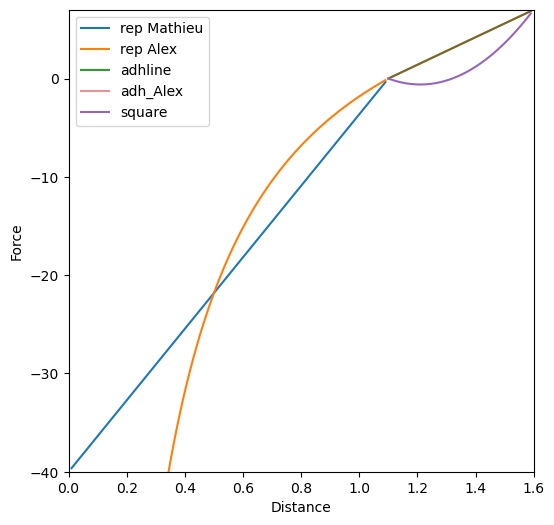

In [17]:
# In[Simulation parameters]
# Space parameters
SPACE_SIZE = 1.28*2048 #1308 # Micrometers
# time settings
TIME_SIMU = 90 # time simulation in minutes
DELTA_T = 15/60 # 0.01 # simulation interval in minutes
PLOT_INTERVAL = 1
# simulation parameters
MU = 1  # mobility in min.kg-1
F_REP = 40  # repulsive strength
F_ADH = 7 # 3 #4 #attractive strength force kg.um.min-2
R_EQ = 1.1 # 11  # equilibrium radius in um
R_0 = 1.6 # 16  # interaction radius in um
MIN_DISTANCE_INIT = R_EQ
NOISE = 10  # noise intensity
TAU = 5 # characteristic time for the polarization to align in the scattering direction defined by v=dr/dt = time
# Cells definition
PACKING_FRACTION = 0.000003
N_CELLS = int((PACKING_FRACTION*SPACE_SIZE**2)/
              (math.pi*((R_EQ/2)**2)))  # number of particles
# N = 2000
print(N_CELLS, "cells")
velocity_magnitude_pop1 = 3 #um/min
velocity_magnitude_pop2 = 7 # um/min

COEFF_CARRE = 50
COEFF_REP = 0.5
plot_function(pas=0.01, Req=R_EQ, R0=R_0, Frep=F_REP,
              Fadh=F_ADH, a=COEFF_CARRE, coeff_rep=COEFF_REP)

In [18]:
# In[Definition of the populations]
population1 = Population(num_cells=int(N_CELLS/2), space_size=SPACE_SIZE,\
                         velocity_magnitude=velocity_magnitude_pop1,\
                         persistence=1,\
                         min_distance=MIN_DISTANCE_INIT)
population2 = Population(num_cells=int(N_CELLS/2), space_size=SPACE_SIZE,\
                         velocity_magnitude=velocity_magnitude_pop2,\
                         persistence=1,\
                         min_distance=MIN_DISTANCE_INIT)

cells = population1.cells + population2.cells

surface = Surface()

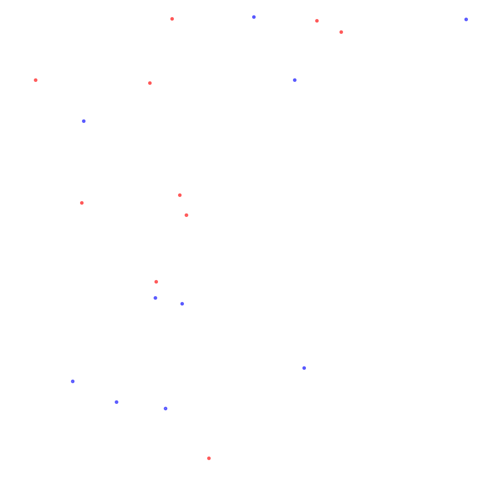

0


In [20]:
# In[initialisation]
positions = torch.stack([cell.position_init for cell in cells])
V0 = torch.tensor([cell.velocity_magnitude for cell in cells], device = device).unsqueeze(1)
direction = torch.stack([cell.direction for cell in cells])
positions = torch.stack([cell.position for cell in cells])
PATH = f'/Users/souchaud/Desktop/simu/v1{velocity_magnitude_pop1}v2{velocity_magnitude_pop2}a{COEFF_CARRE}coefrep{COEFF_REP}fadh{F_ADH}frep{F_REP}/'
if not os.path.exists(PATH):
    os.mkdir(PATH)
else :
    print("WARNING : FOLDER DOES ALREADY EXIST!")
    sys.exit(0)
plot_environment(cells, space_size= SPACE_SIZE, req=R_EQ,
                 path_saving=PATH, iteration = 0)

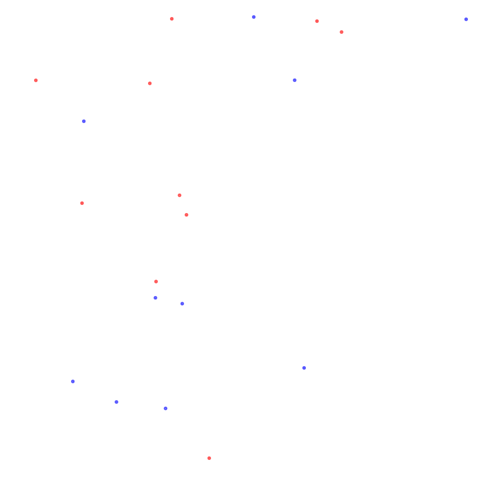

1
0.25


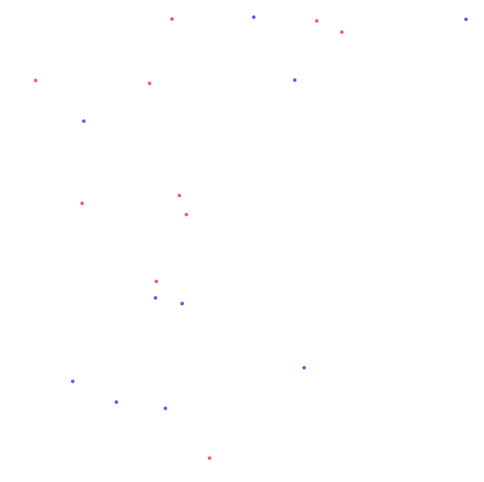

2
0.5


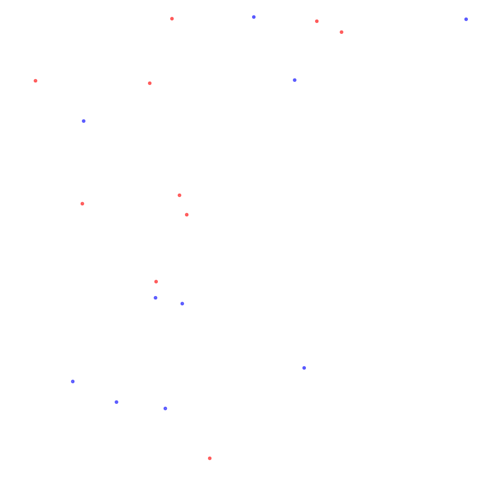

3
0.75


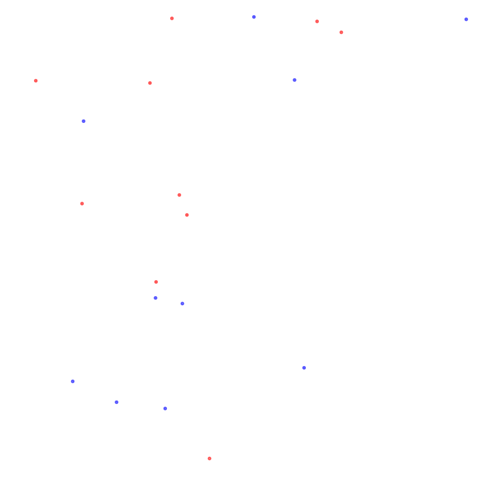

4
1.0


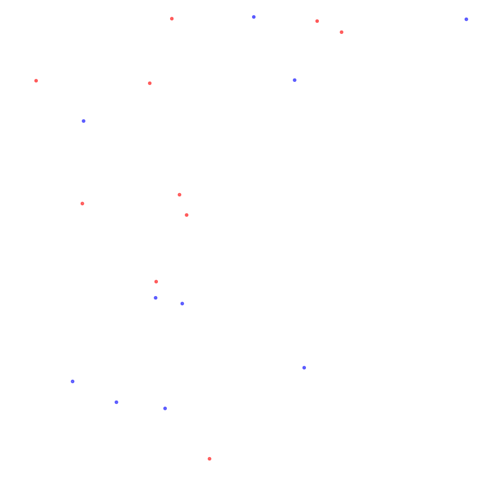

5
1.25


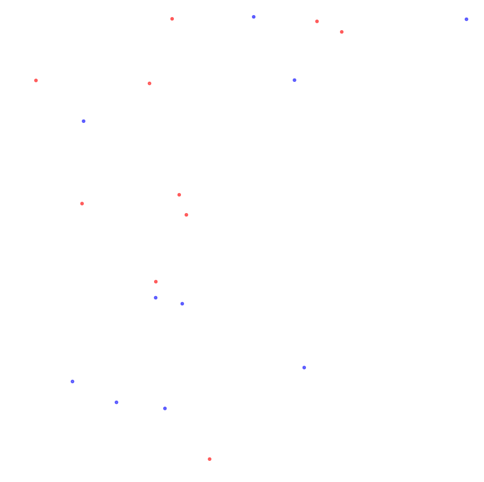

6
1.5


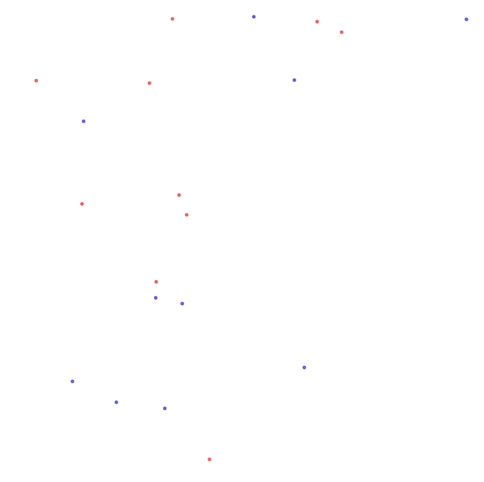

7
1.75


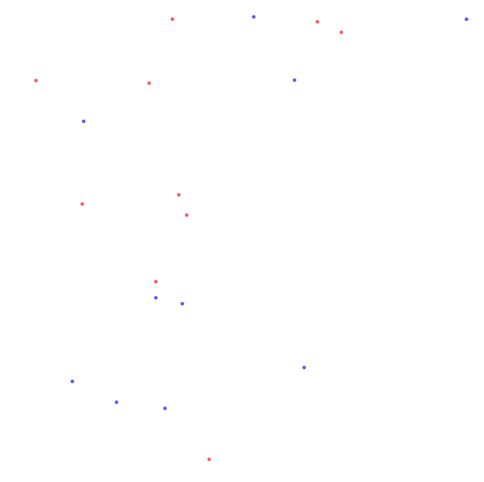

8
2.0


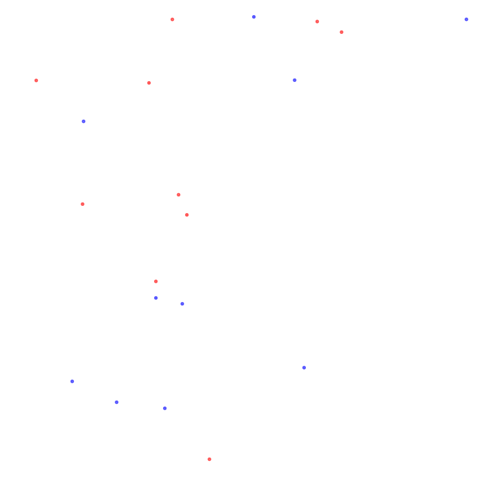

9
2.25


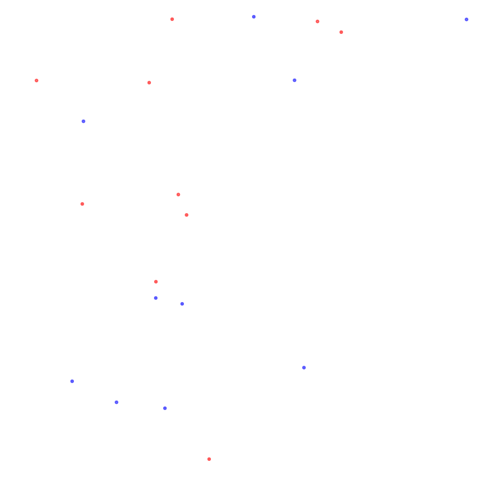

10
2.5


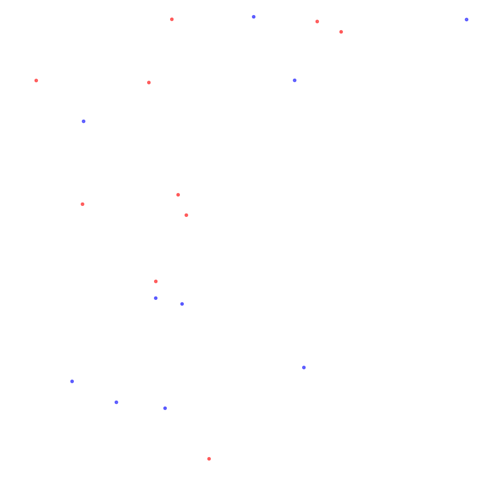

11
2.75


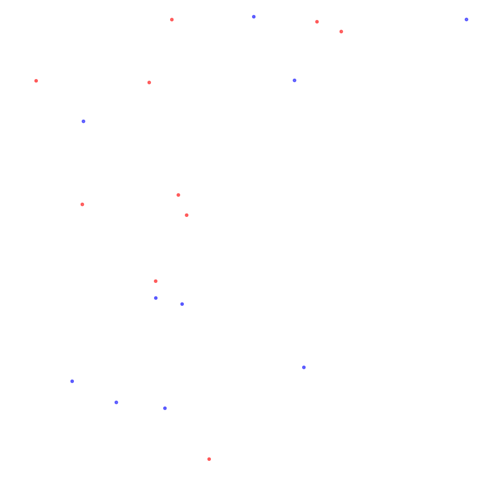

12
3.0


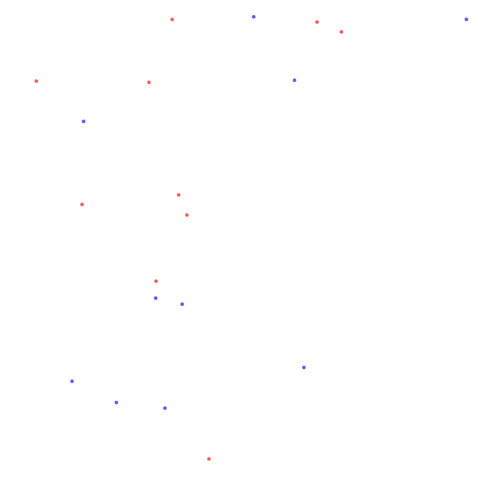

13
3.25


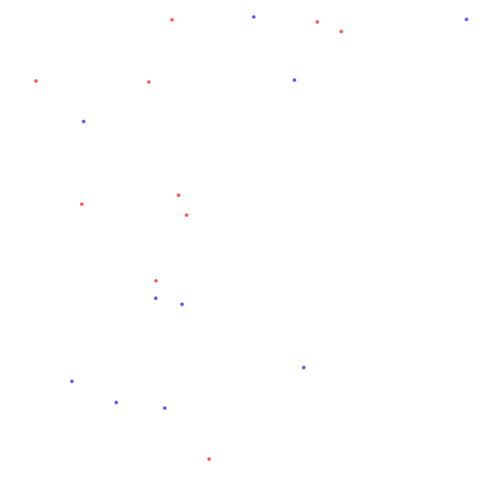

14
3.5


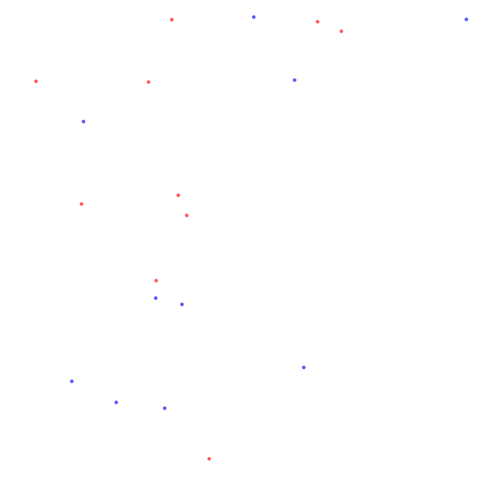

15
3.75


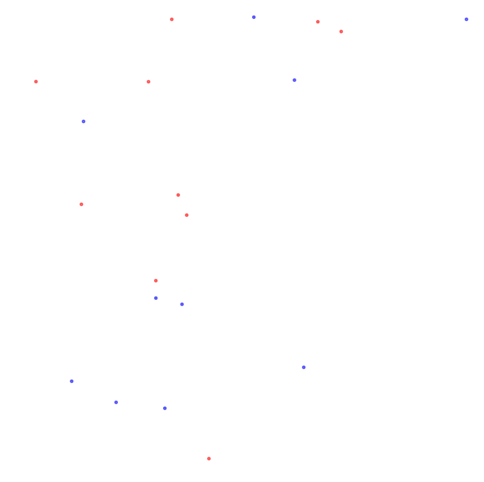

16
4.0


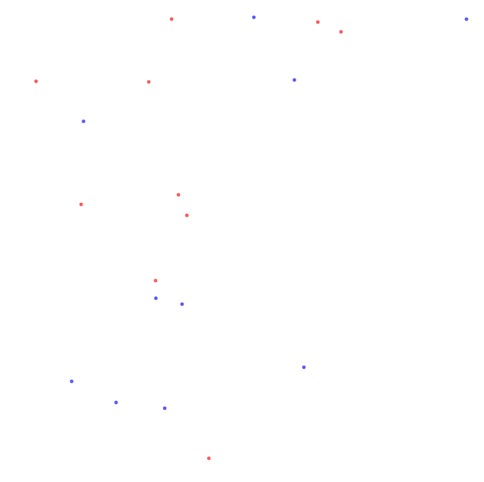

17
4.25


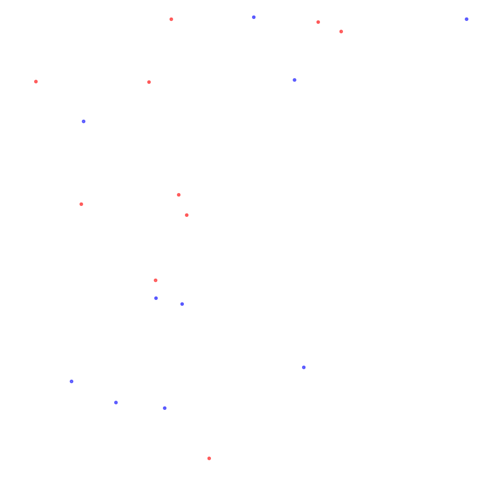

18
4.5


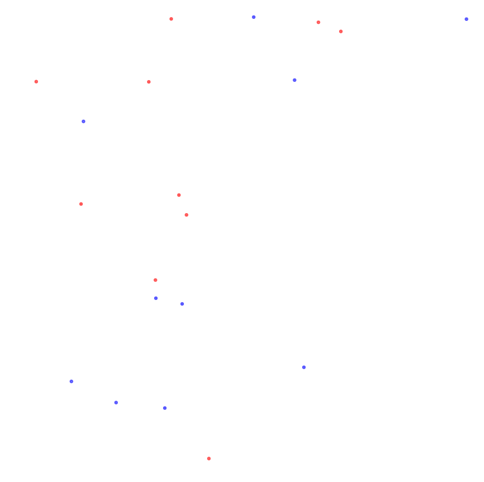

19
4.75


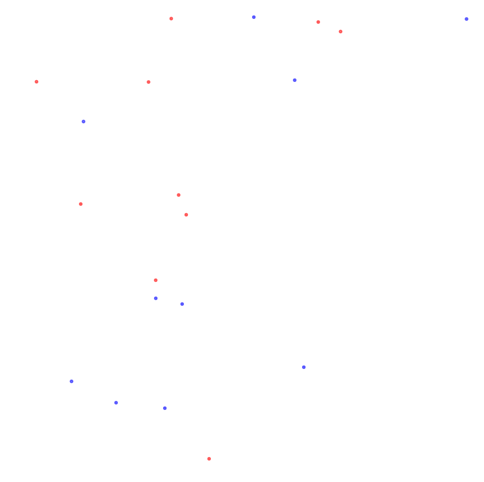

20
5.0


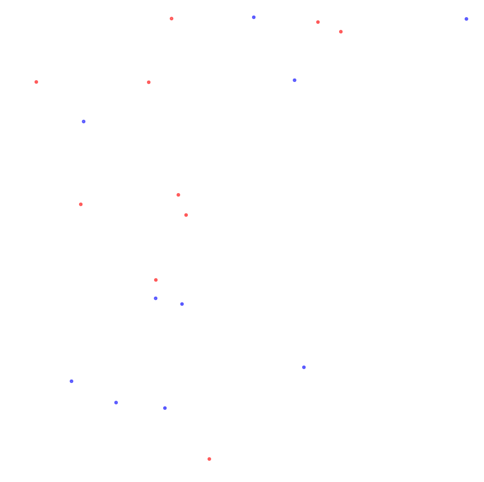

21
5.25


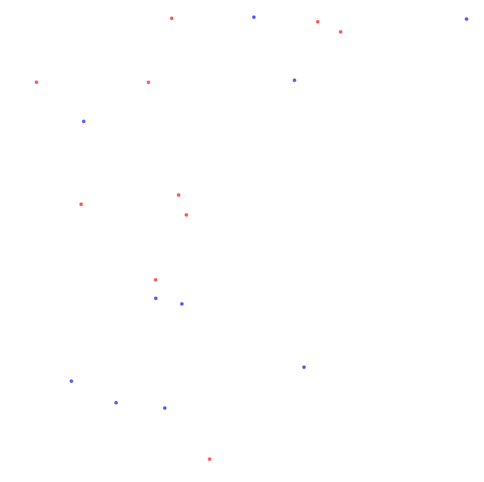

22
5.5


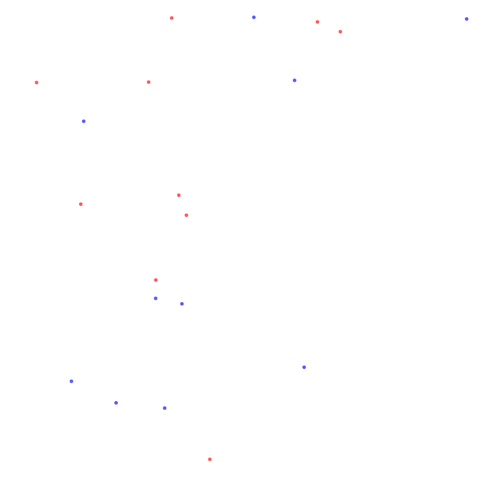

23
5.75


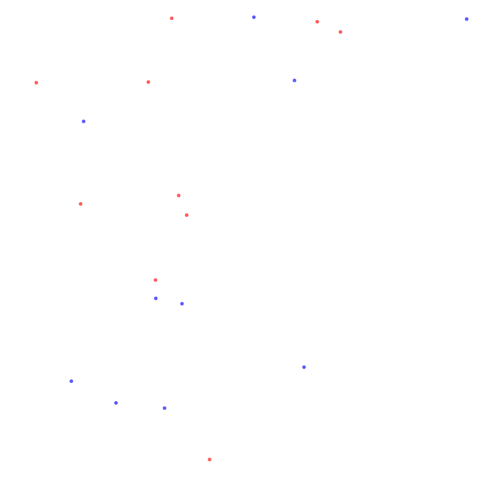

24
6.0


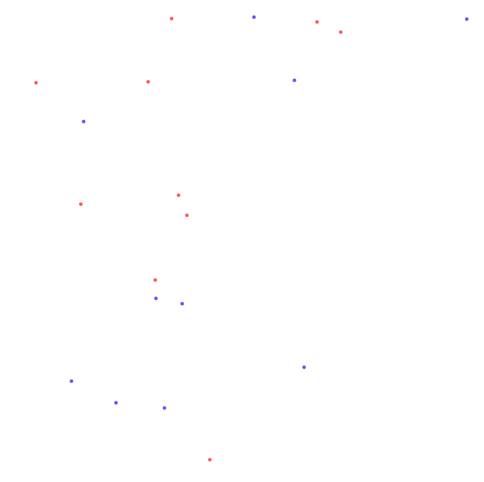

25
6.25


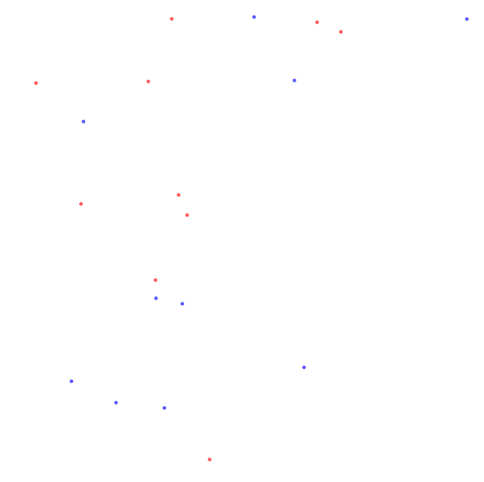

26
6.5


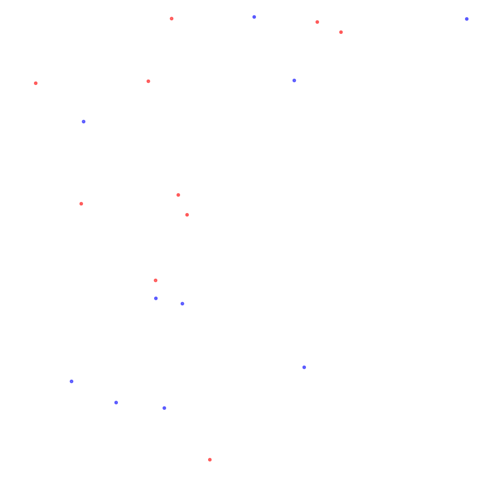

27
6.75


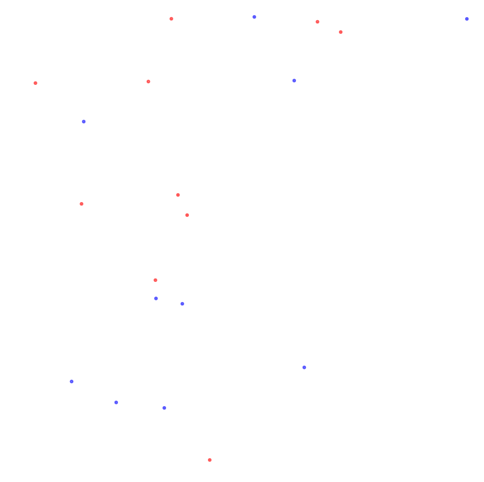

28
7.0


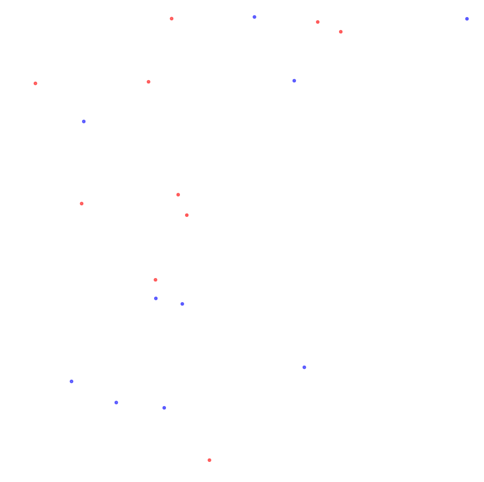

29
7.25


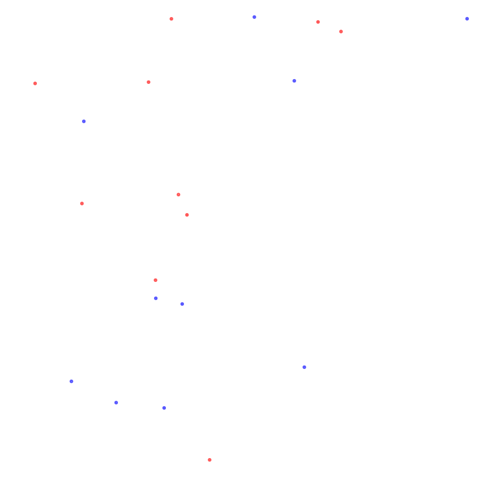

30
7.5


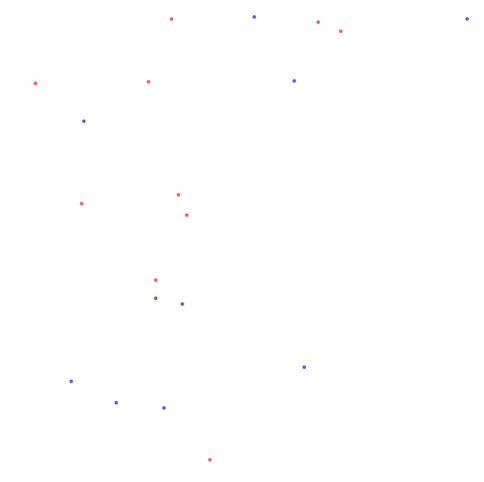

31
7.75


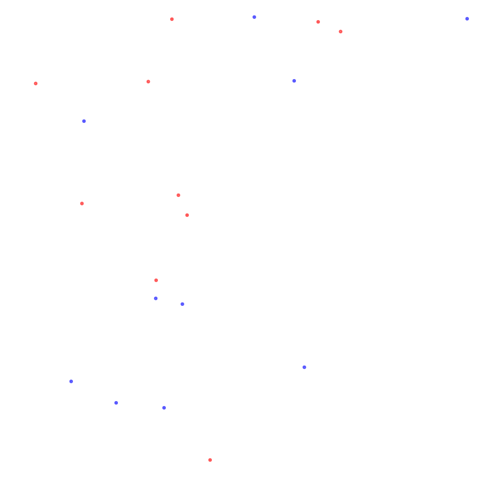

32
8.0


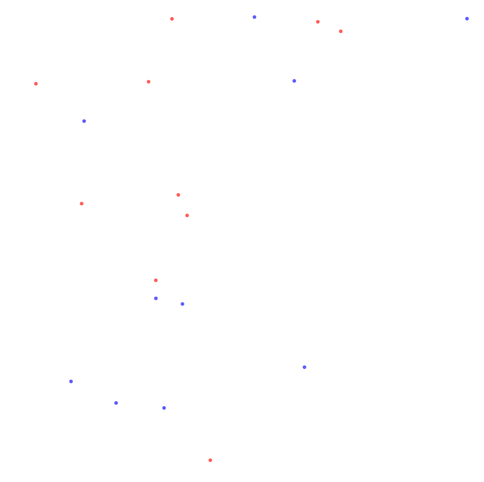

33
8.25


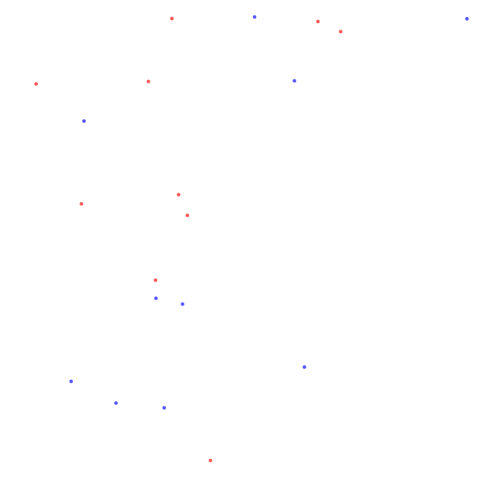

34
8.5


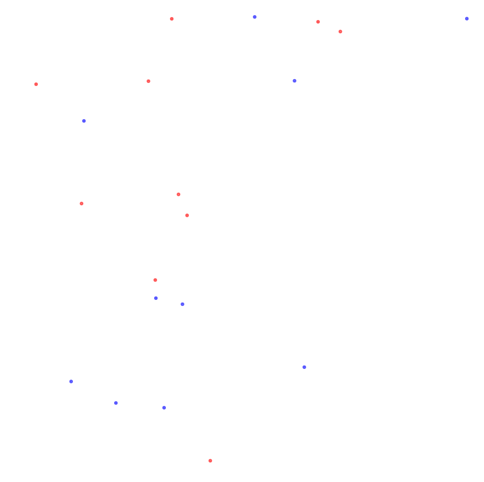

35
8.75


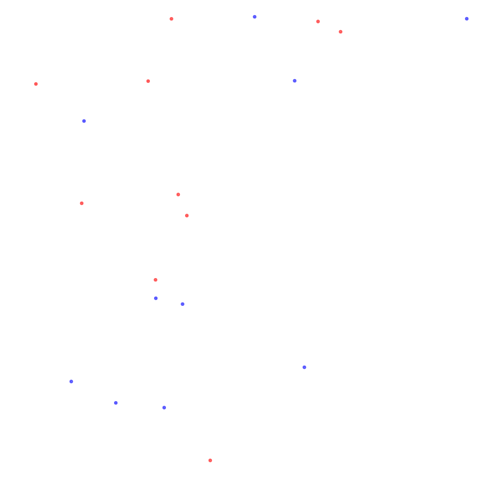

36
9.0


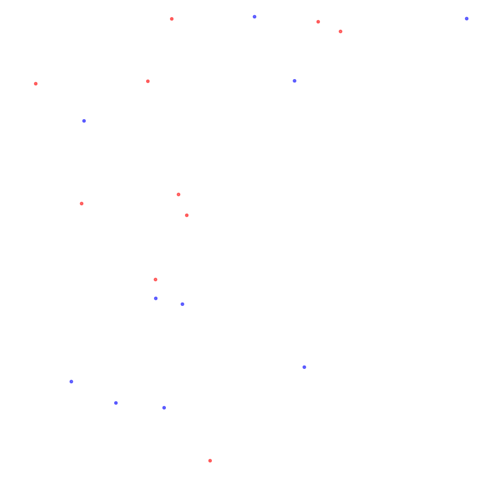

37
9.25


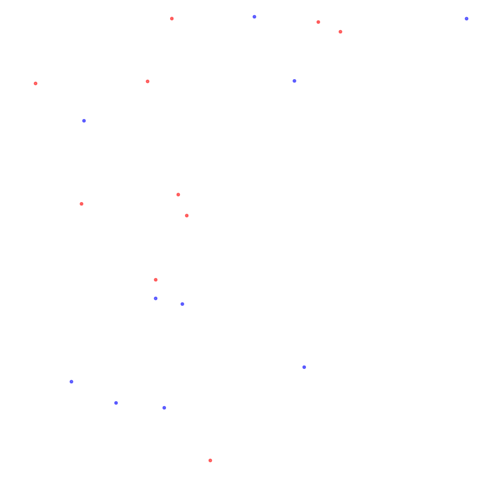

38
9.5


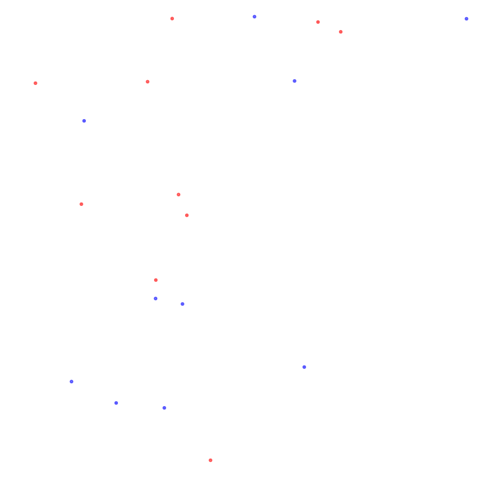

39
9.75


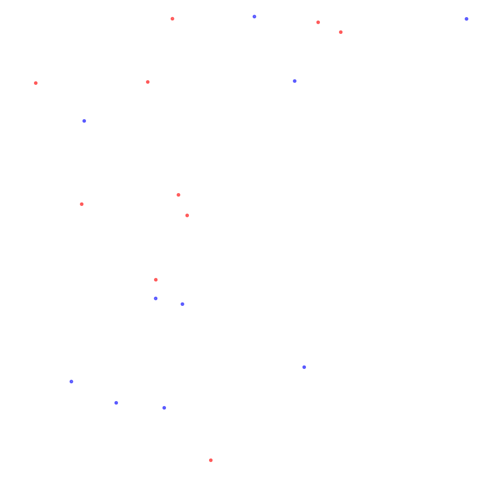

40
10.0


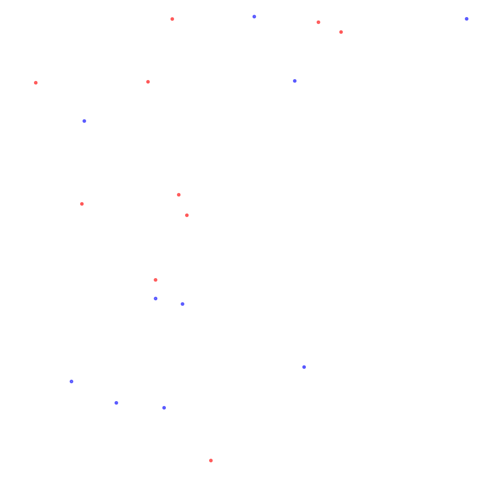

41
10.25


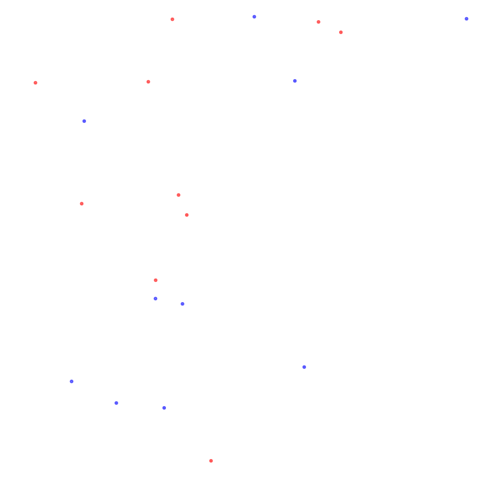

42
10.5


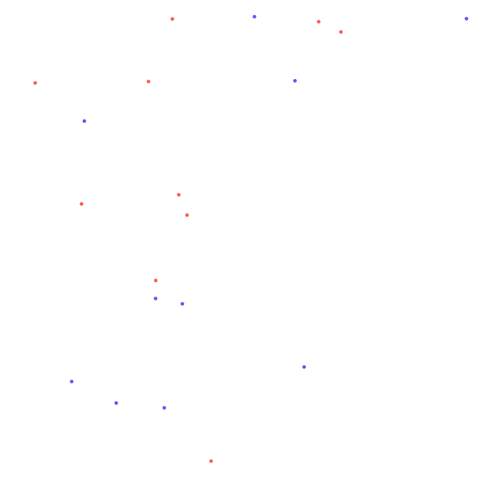

43
10.75


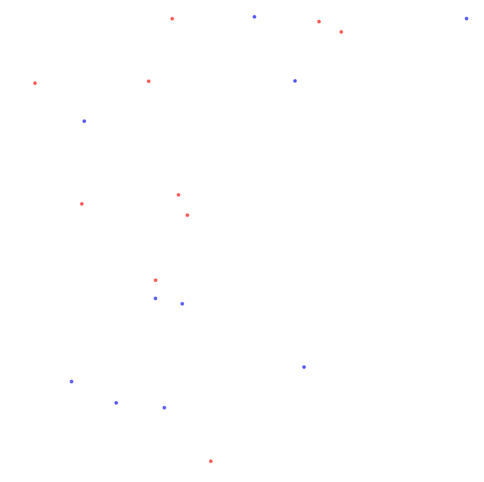

44
11.0


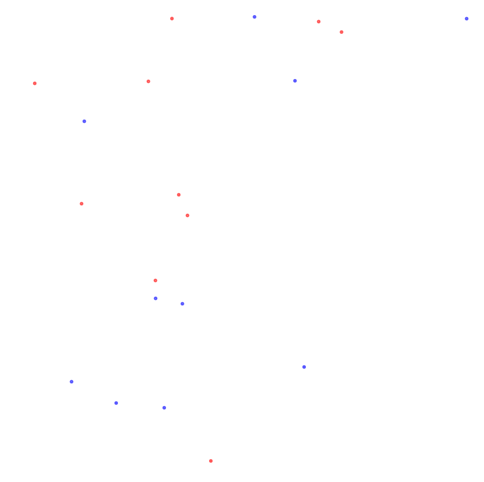

45
11.25


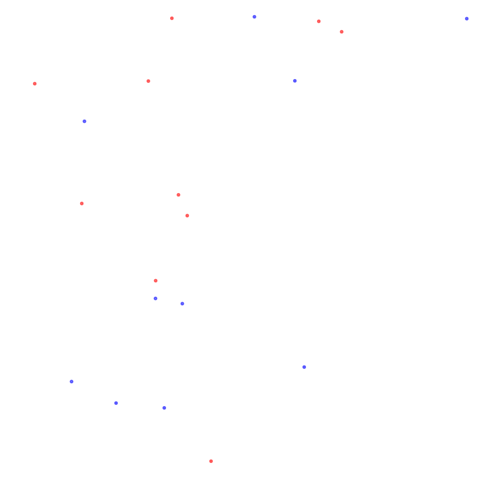

46
11.5


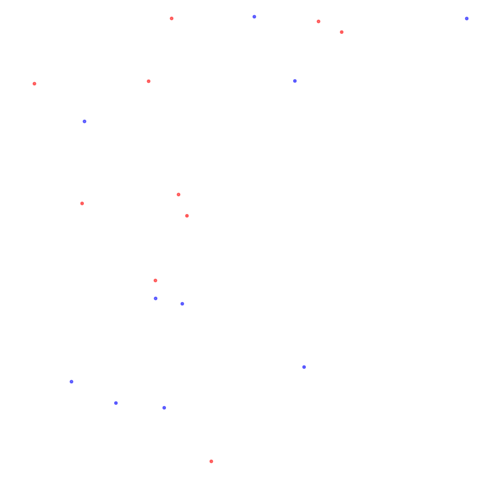

47
11.75


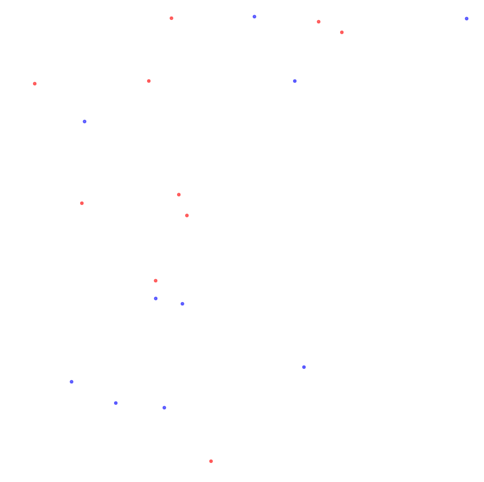

48
12.0


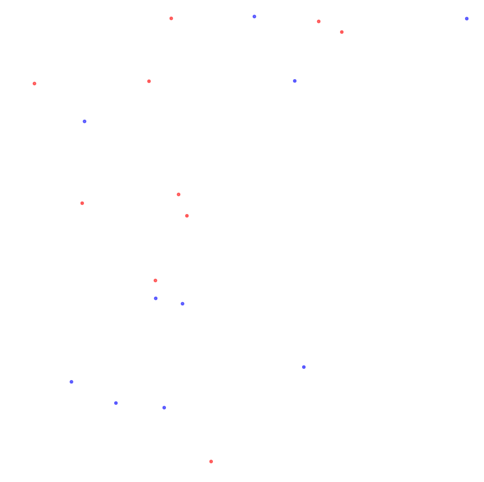

49
12.25


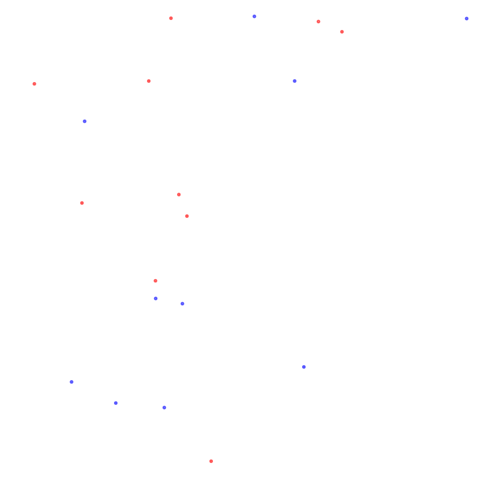

50
12.5


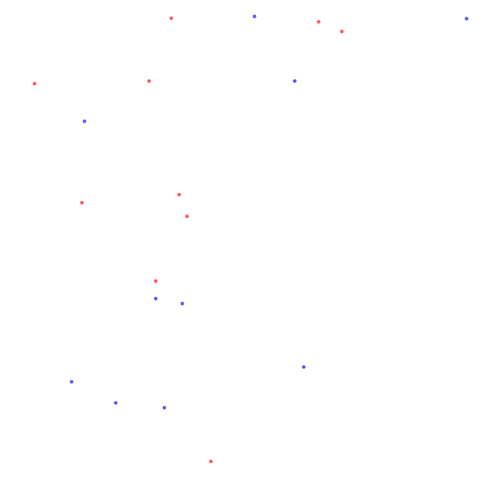

51
12.75


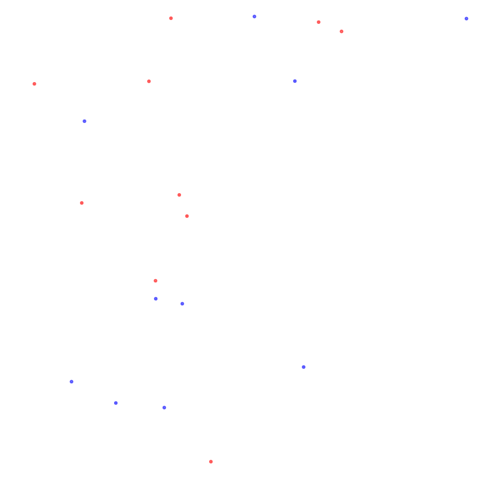

52
13.0


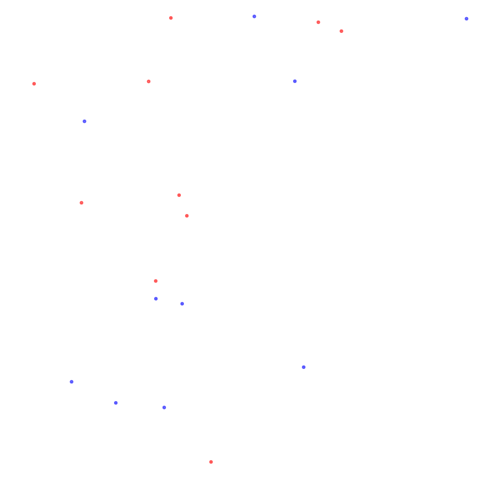

53
13.25


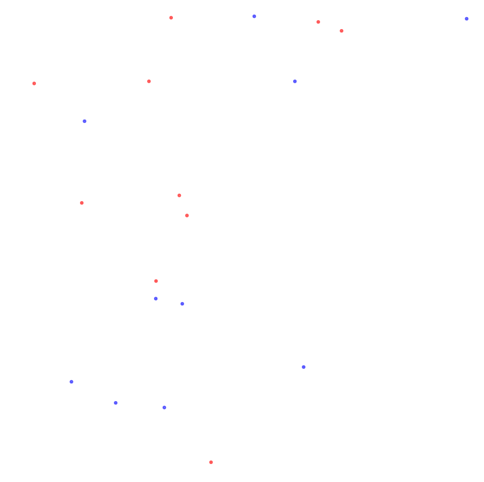

54
13.5


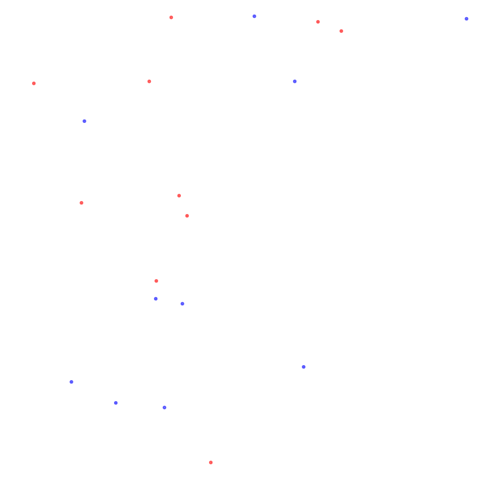

55
13.75


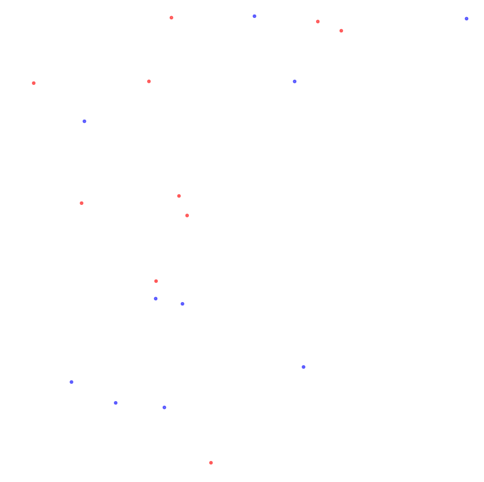

56
14.0


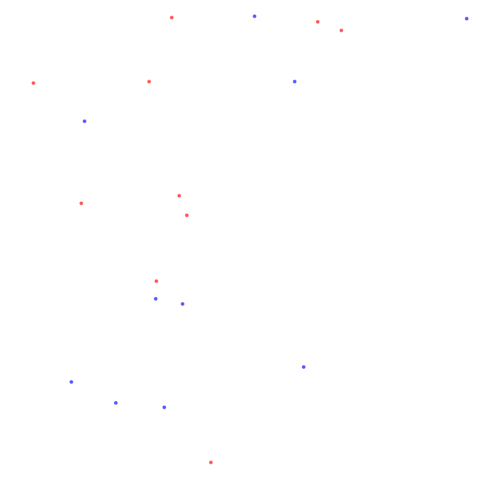

57
14.25


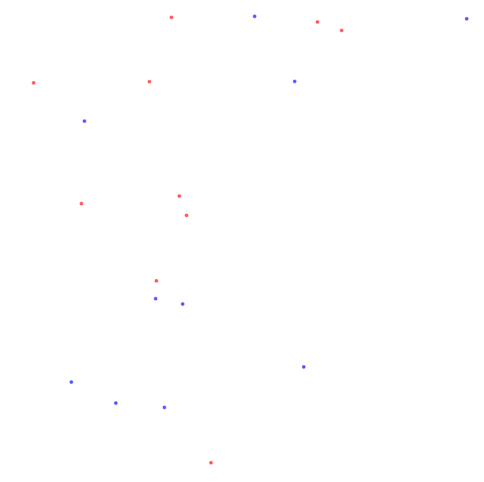

58
14.5


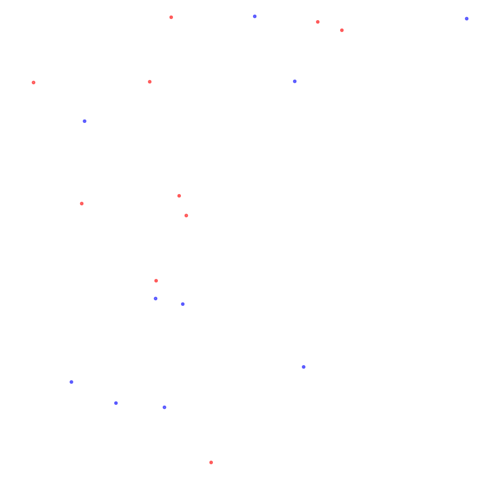

59
14.75


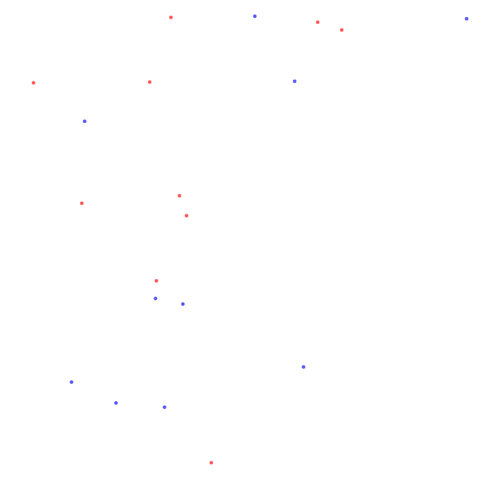

60
15.0


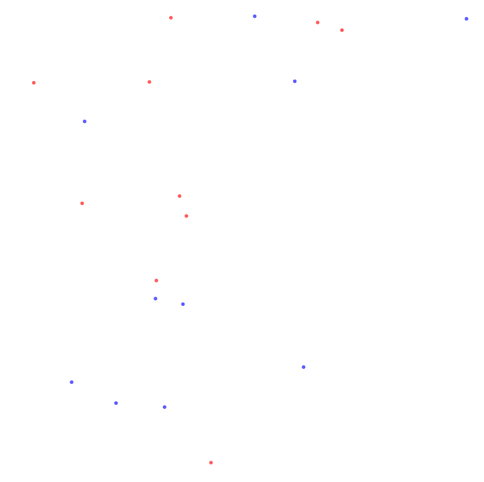

61
15.25


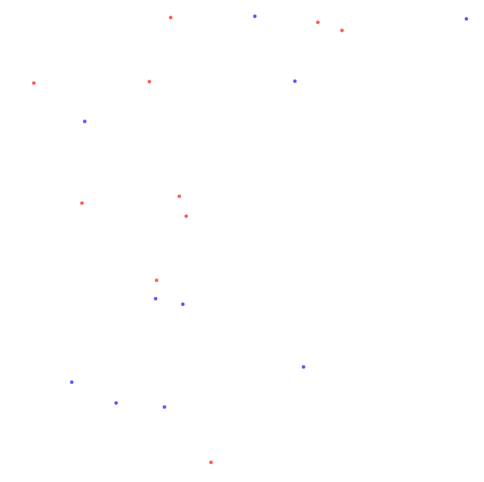

62
15.5


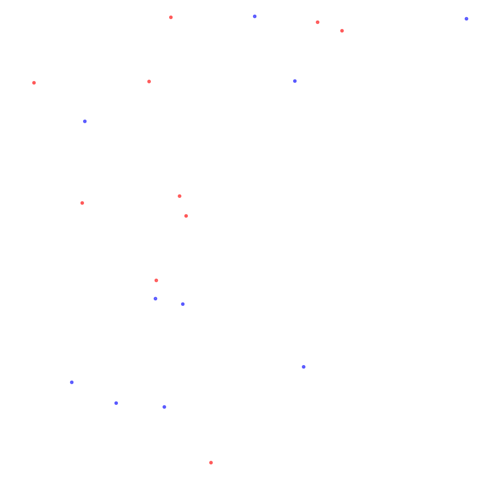

63
15.75


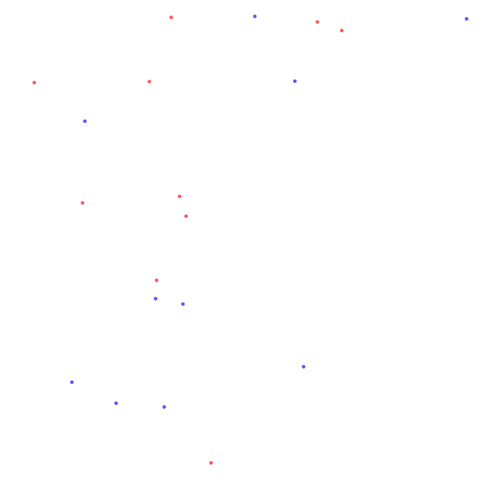

64
16.0


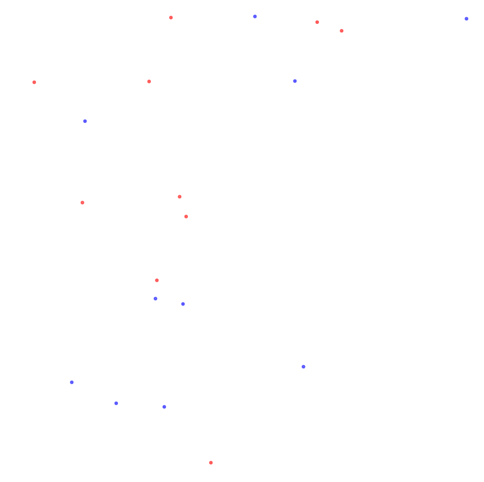

65
16.25


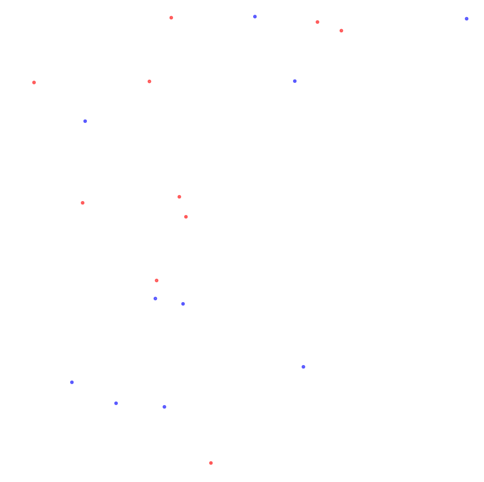

66
16.5


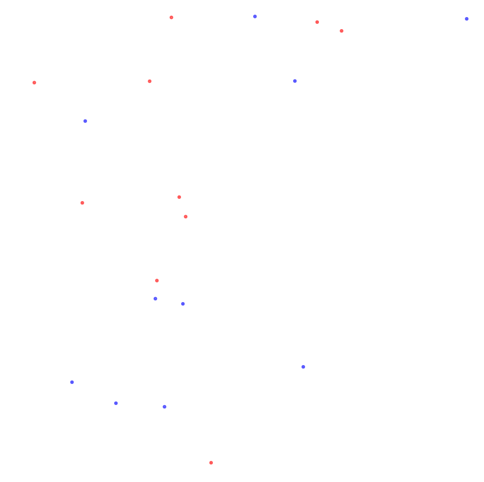

67
16.75


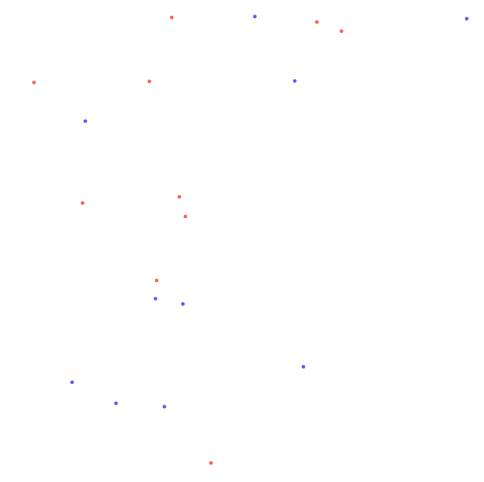

68
17.0


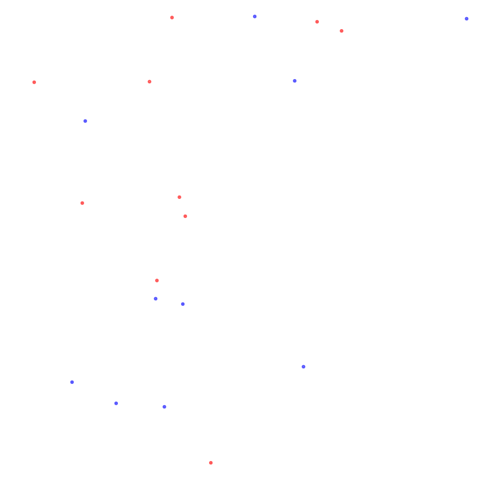

69
17.25


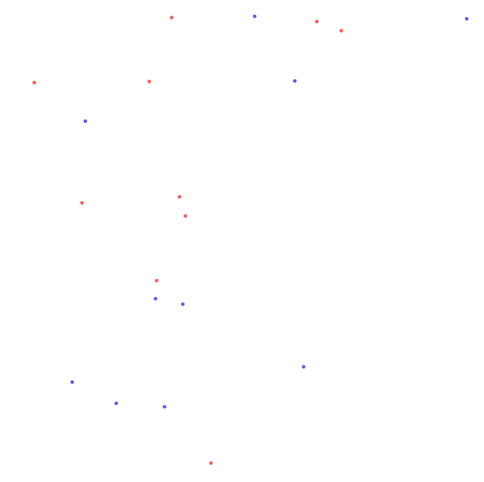

70
17.5


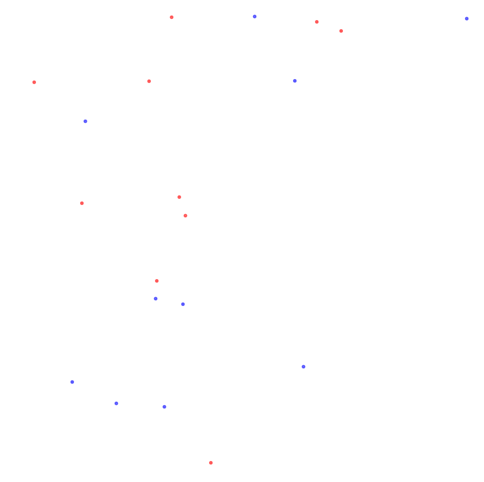

71
17.75


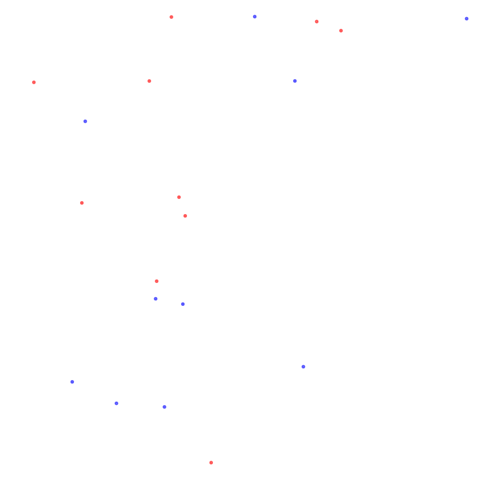

72
18.0


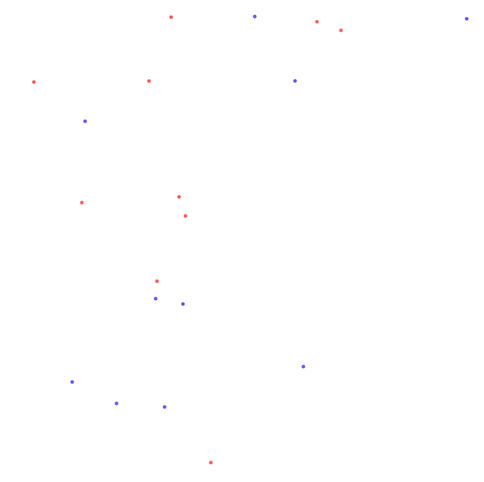

73
18.25


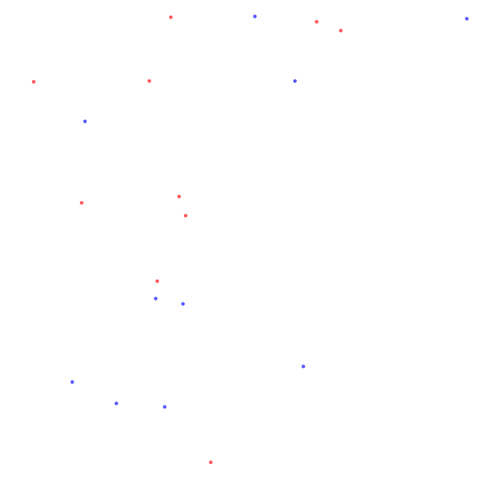

74
18.5


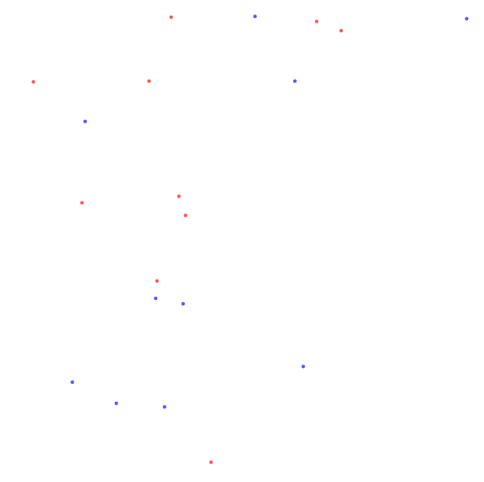

75
18.75


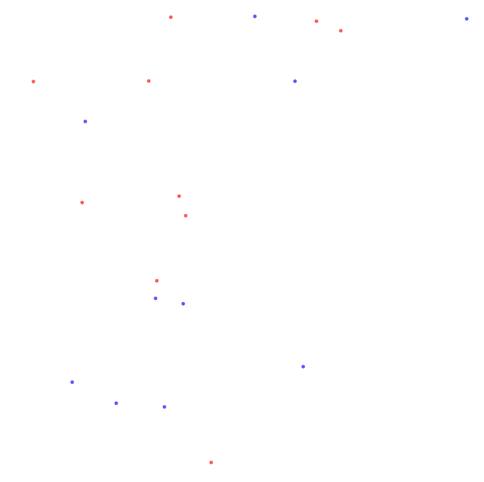

76
19.0


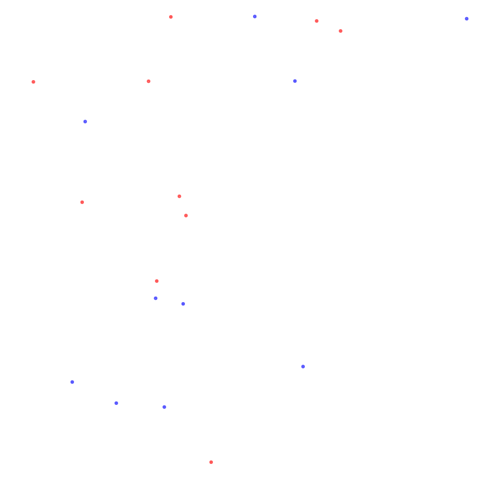

77
19.25


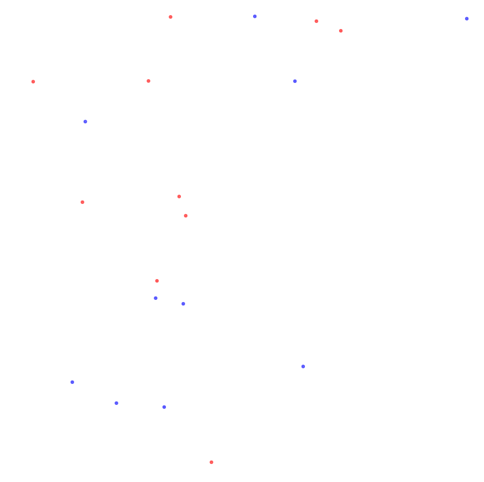

78
19.5


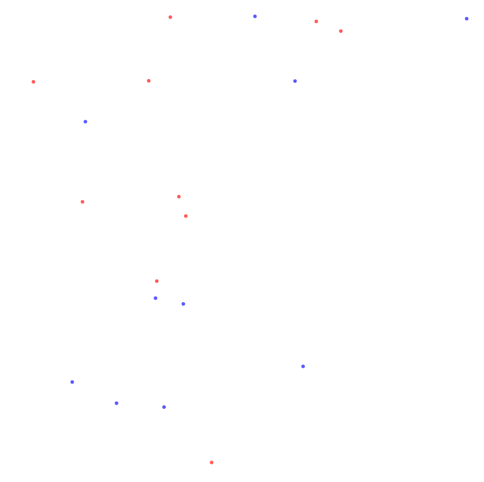

79
19.75


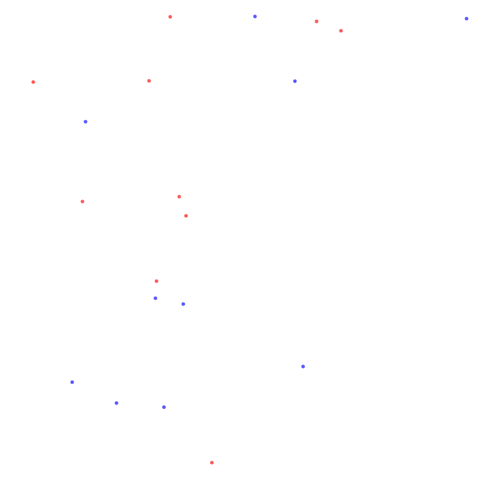

80
20.0


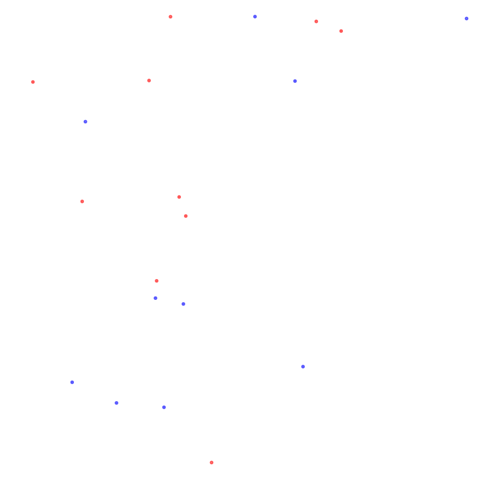

81
20.25


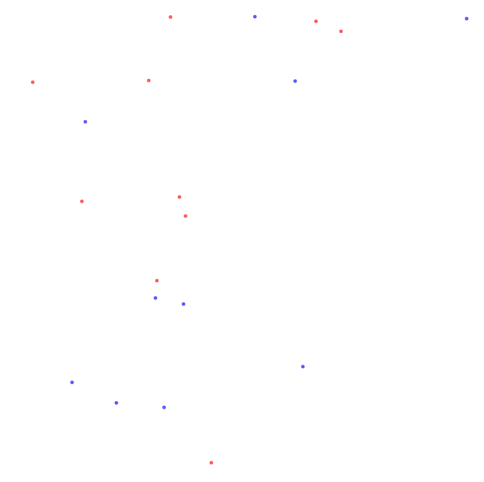

82
20.5


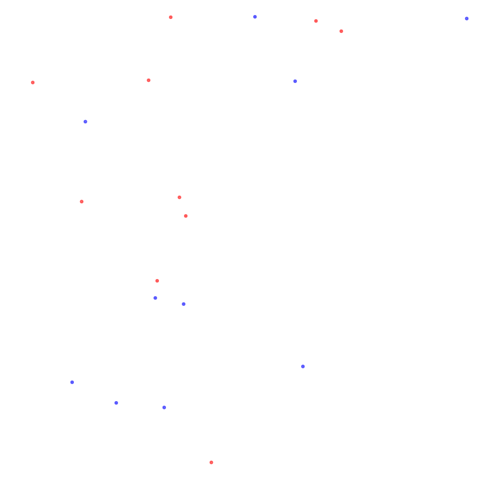

83
20.75


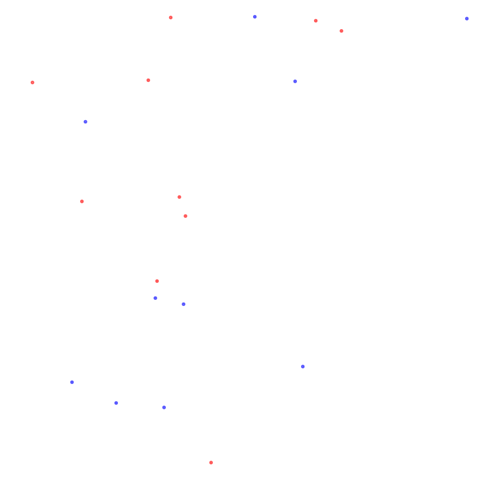

84
21.0


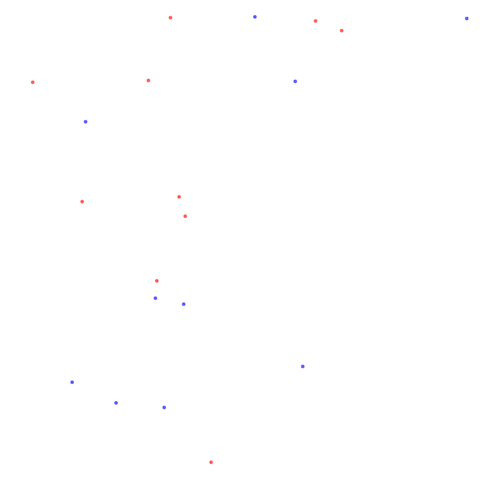

85
21.25


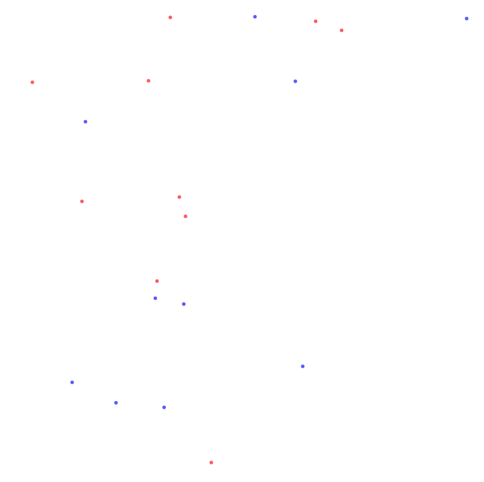

86
21.5


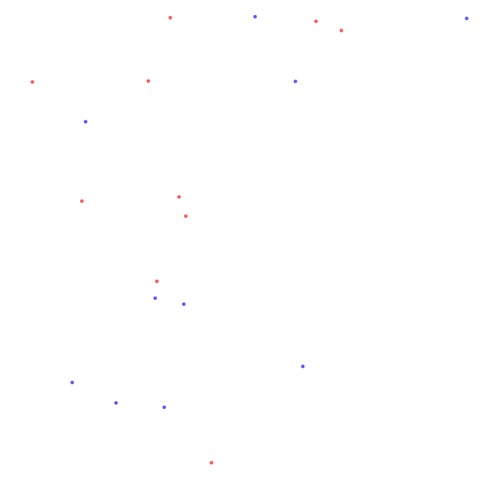

87
21.75


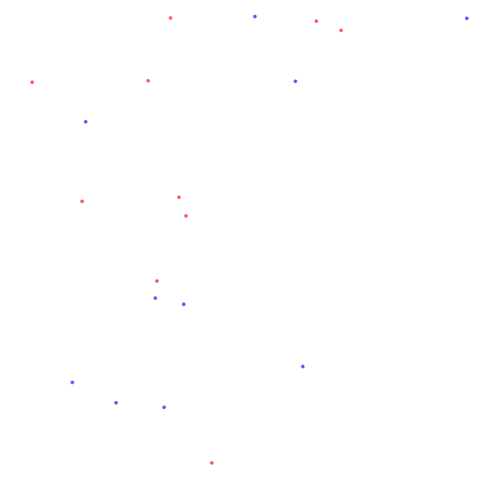

88
22.0


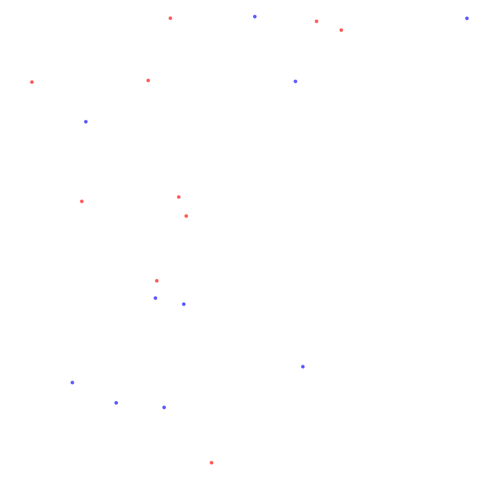

89
22.25


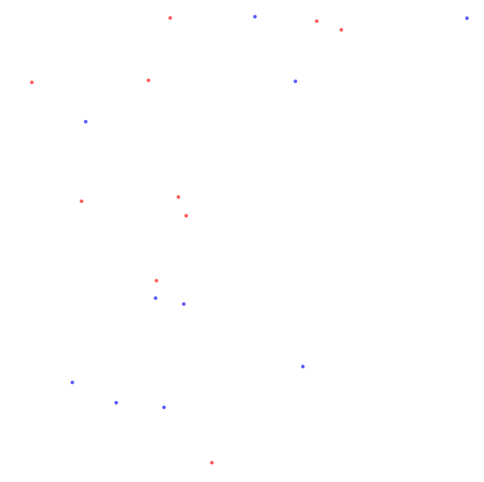

90
22.5


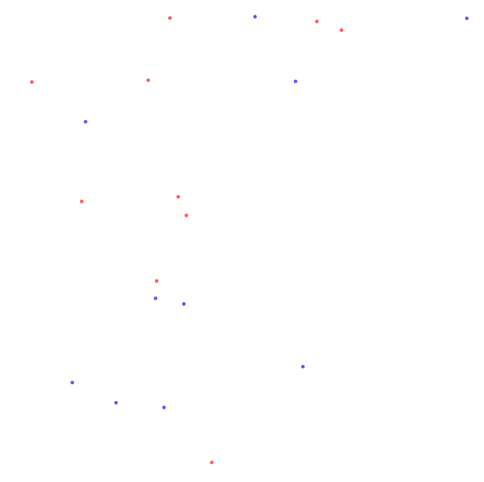

91
22.75


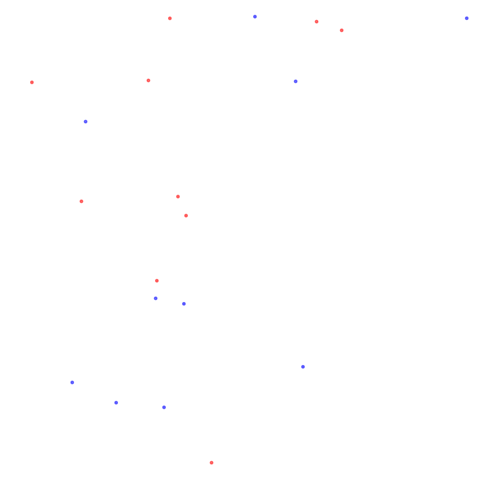

92
23.0


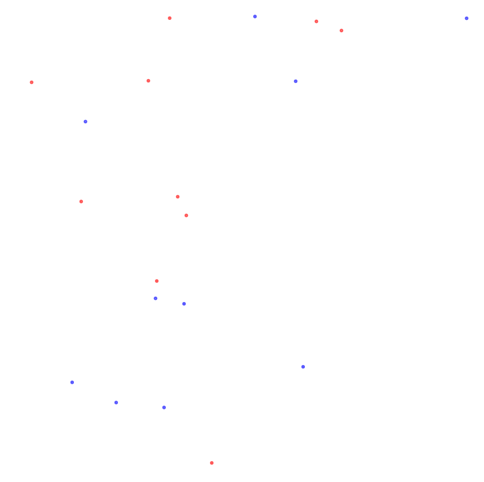

93
23.25


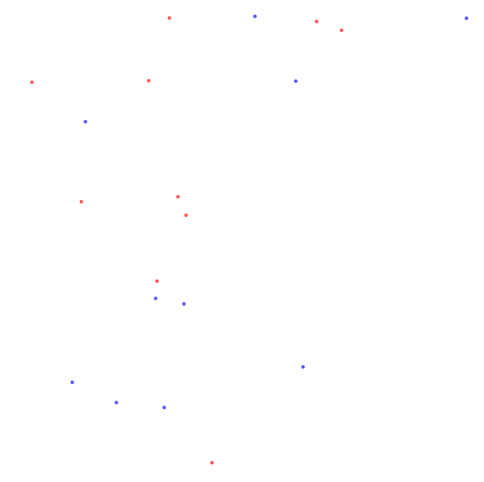

94
23.5


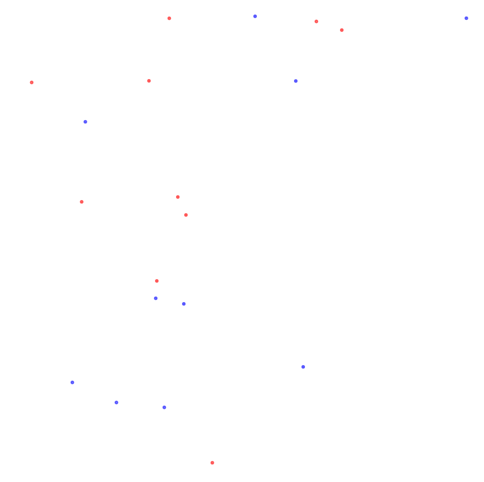

95
23.75


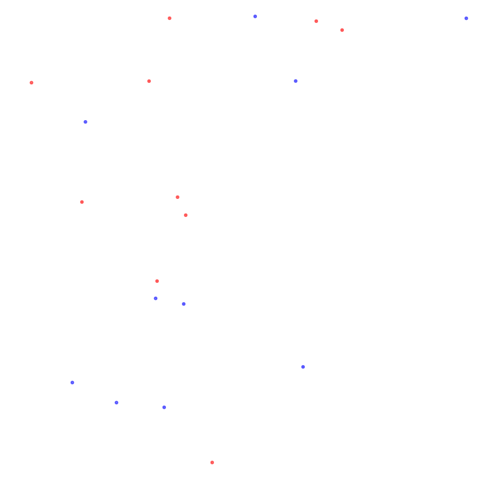

96
24.0


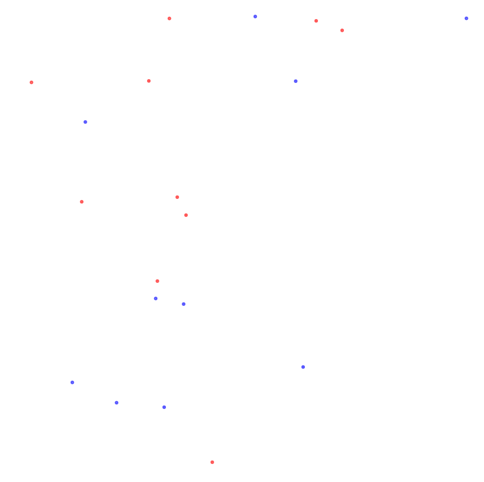

97
24.25


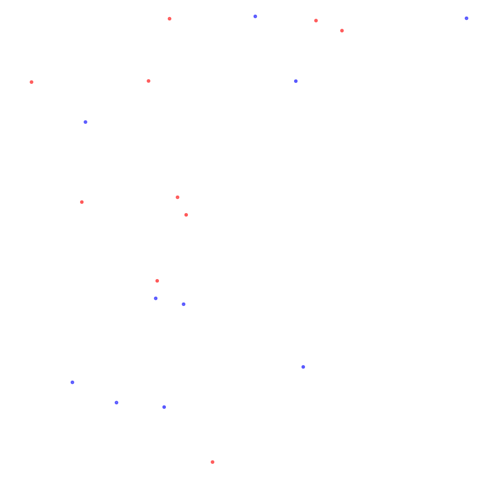

98
24.5


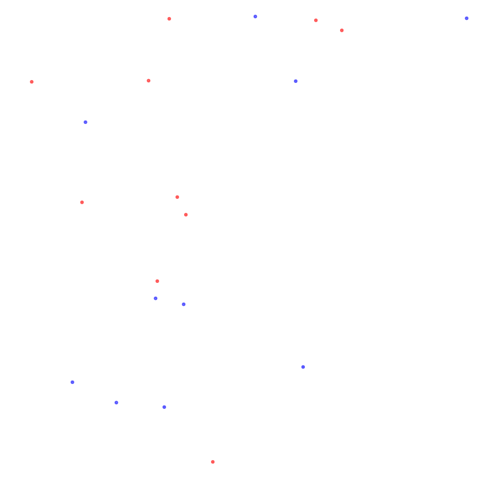

99
24.75


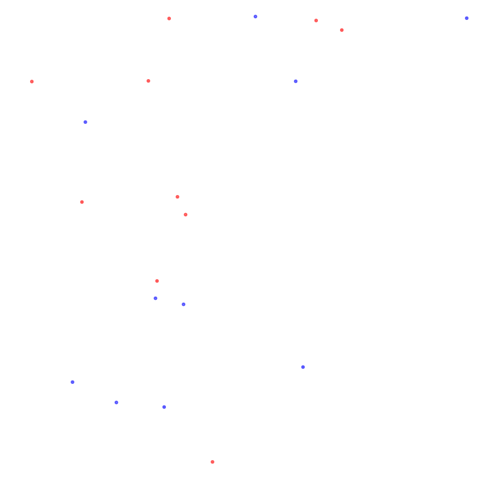

100
25.0


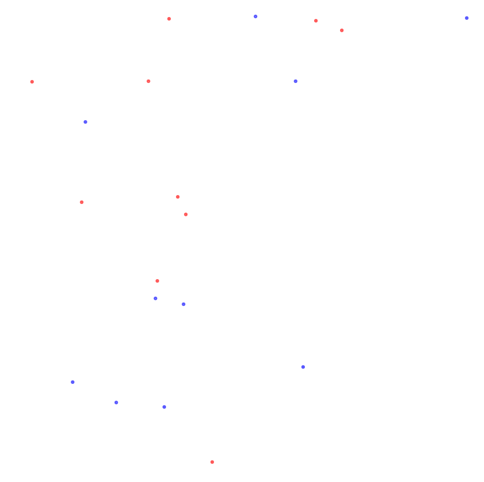

101
25.25


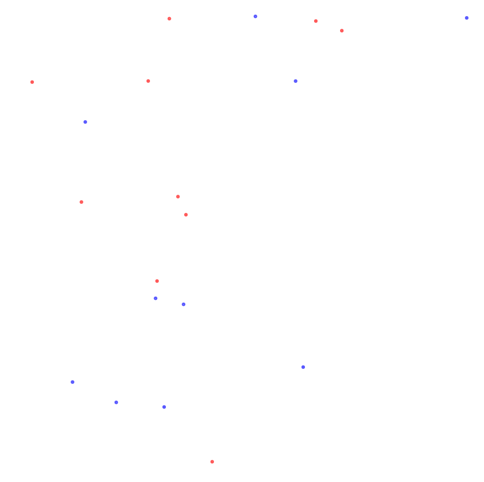

102
25.5


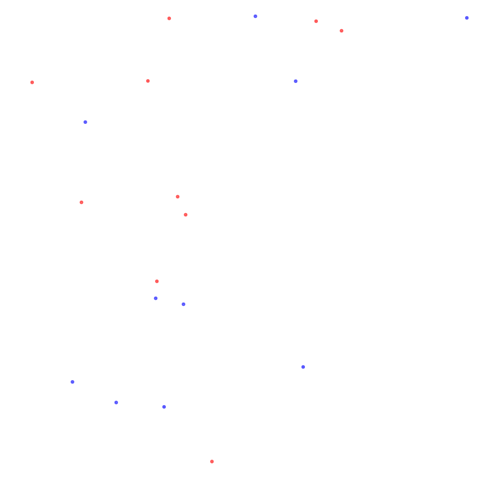

103
25.75


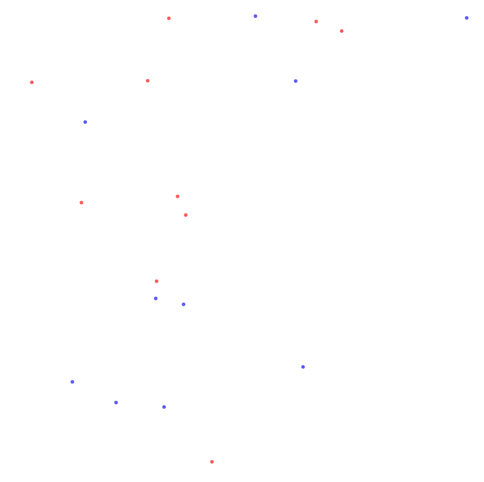

104
26.0


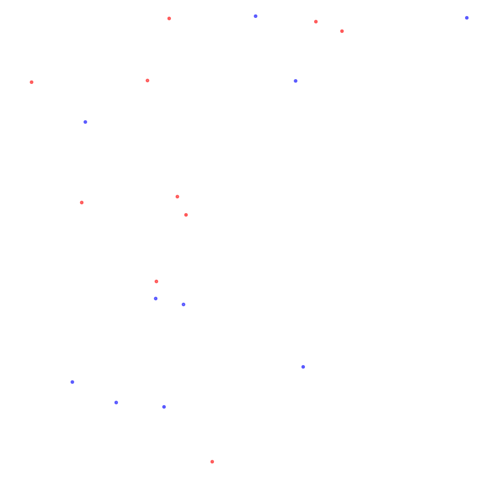

105
26.25


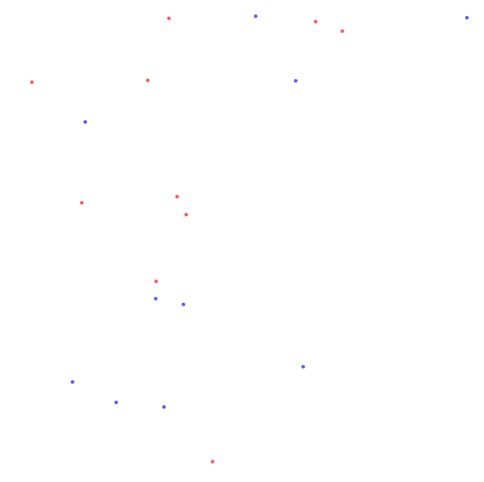

106
26.5


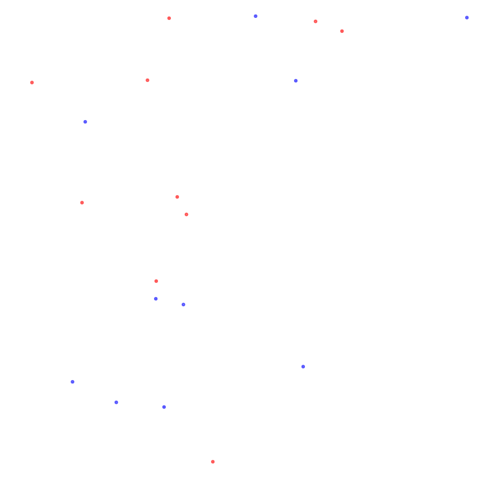

107
26.75


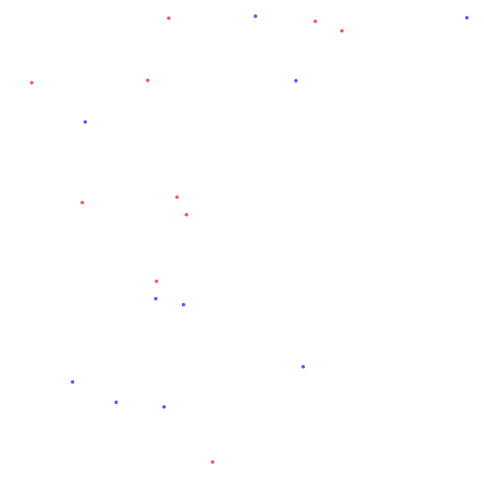

108
27.0


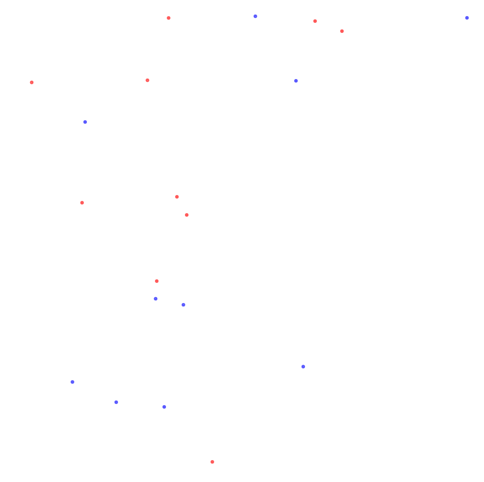

109
27.25


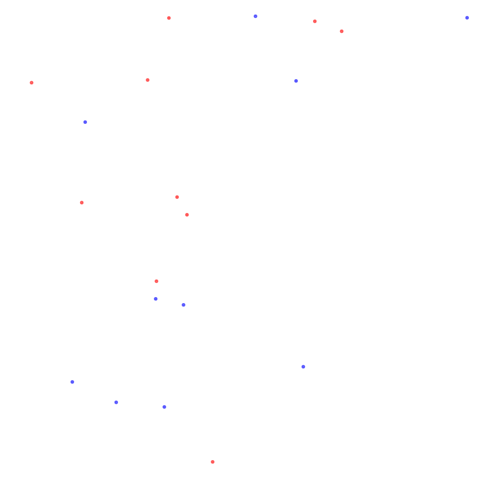

110
27.5


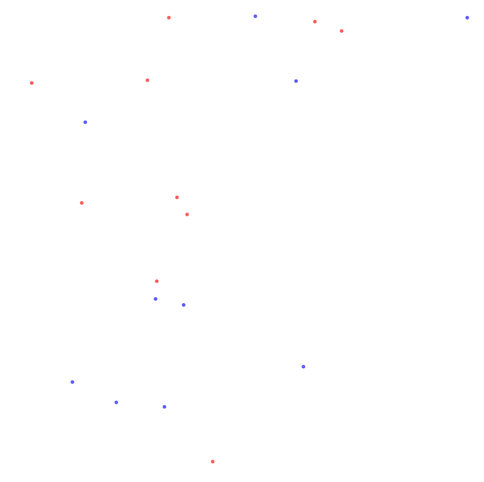

111
27.75


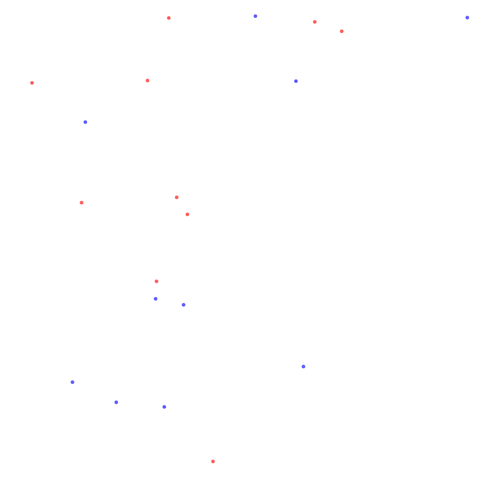

112
28.0


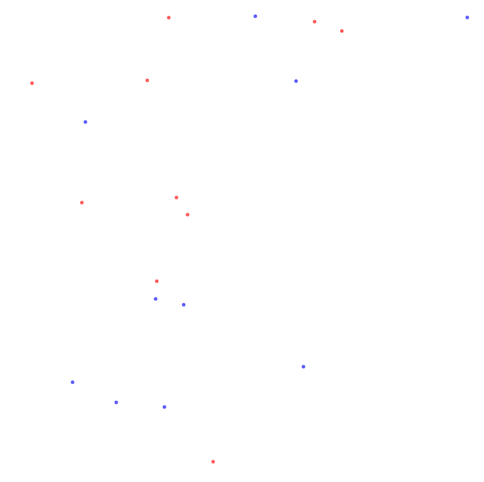

113
28.25


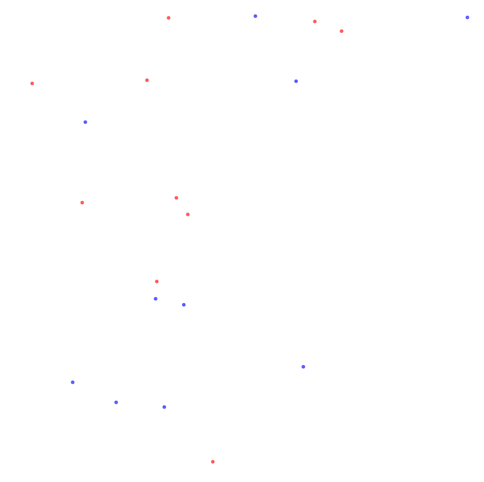

114
28.5


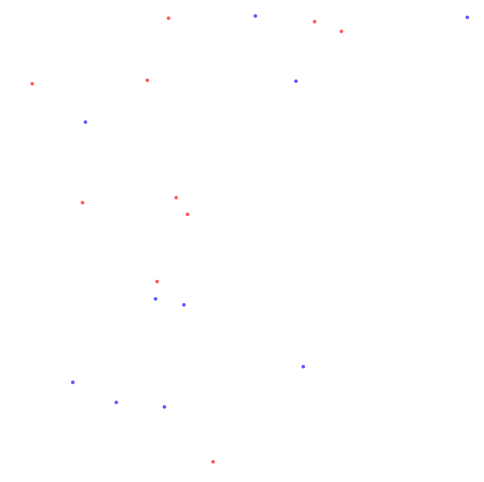

115
28.75


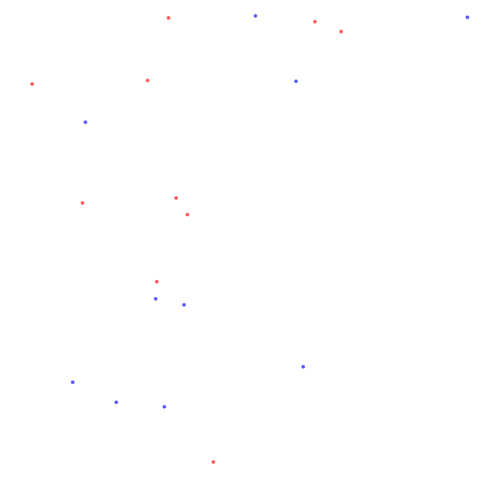

116
29.0


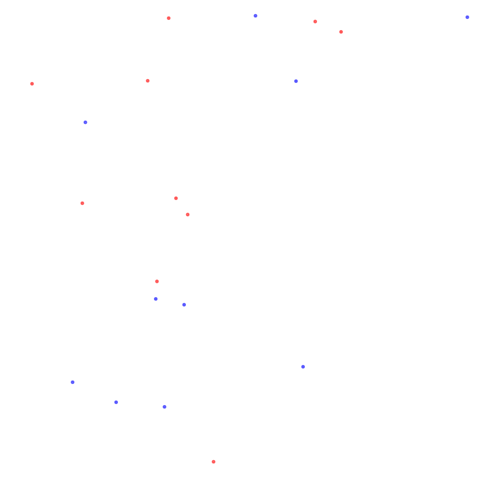

117
29.25


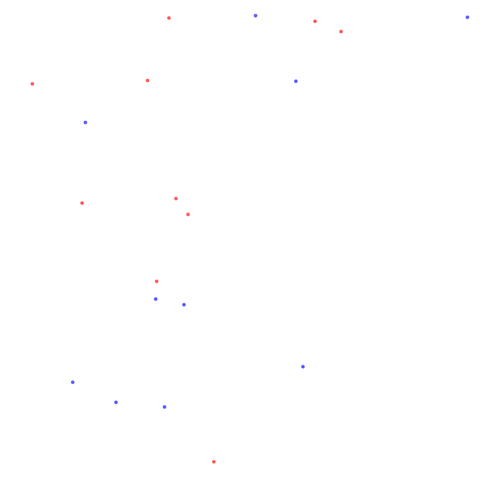

118
29.5


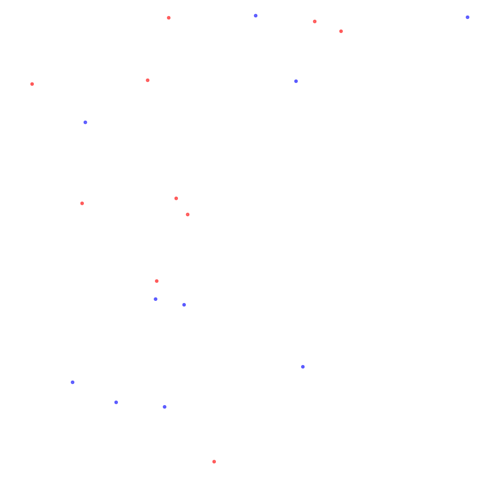

119
29.75


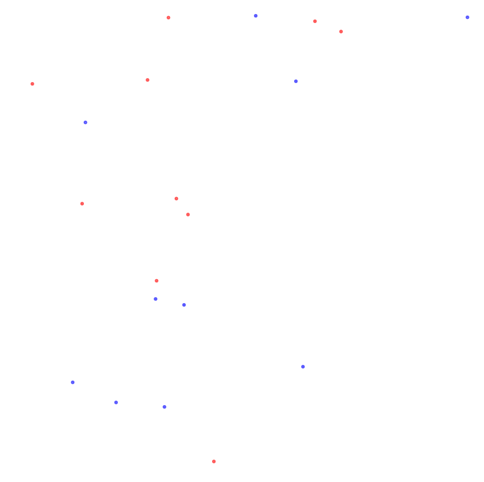

120
30.0


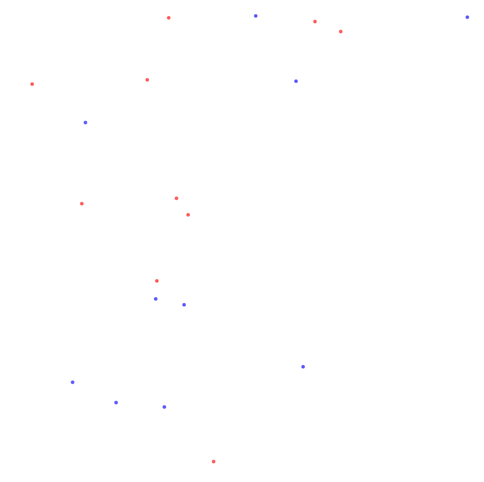

121
30.25


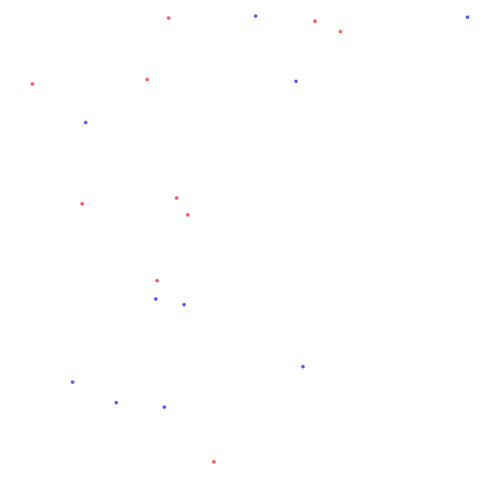

122
30.5


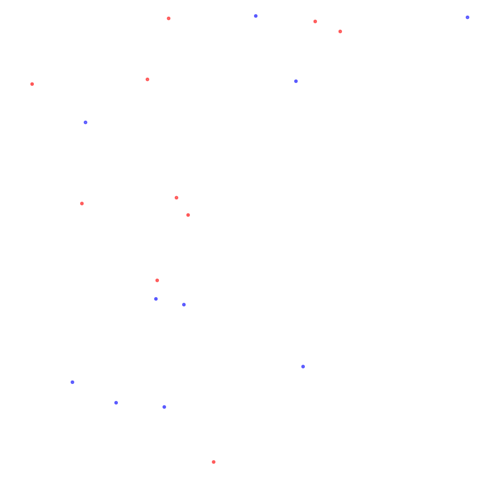

123
30.75


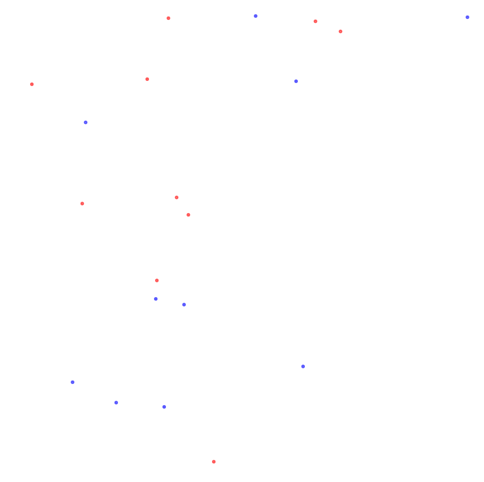

124
31.0


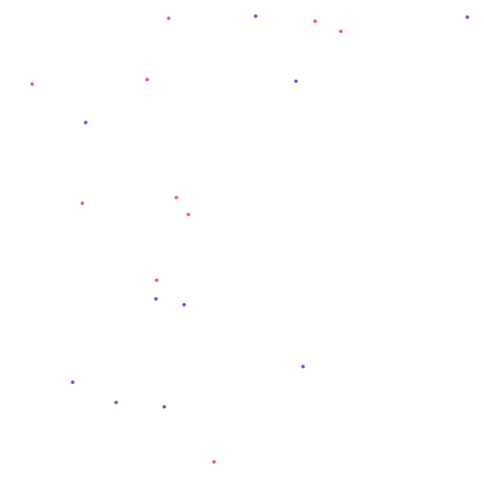

125
31.25


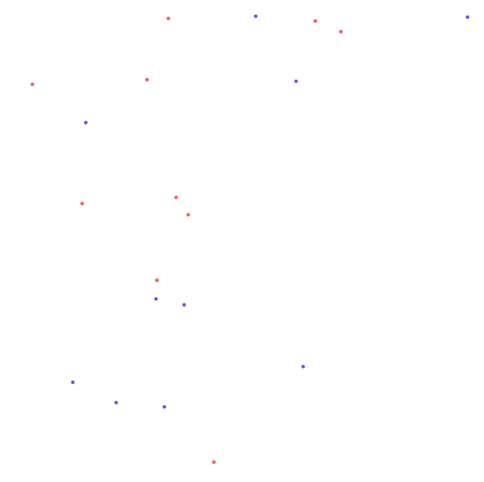

126
31.5


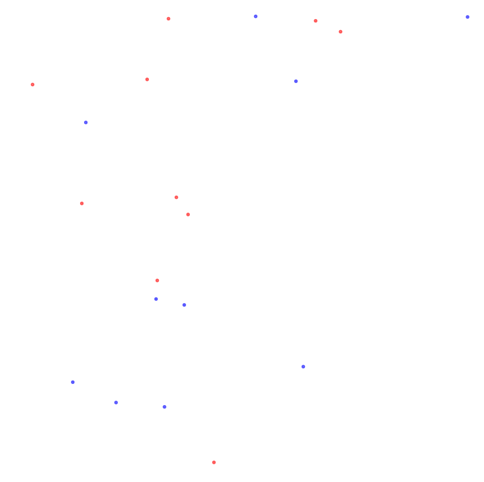

127
31.75


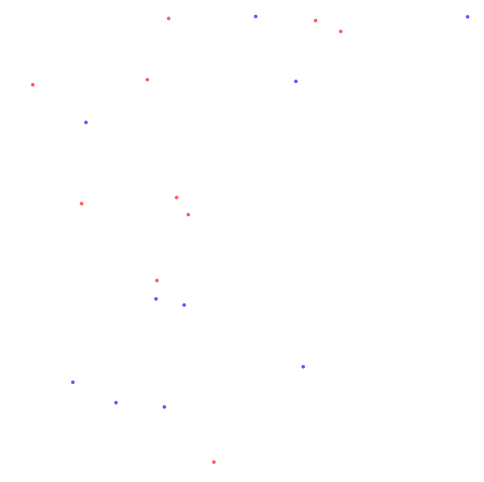

128
32.0


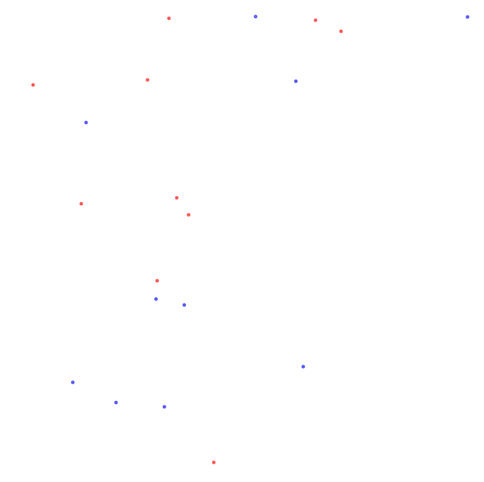

129
32.25


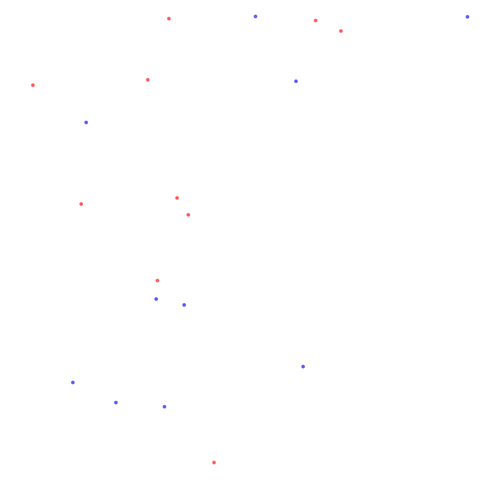

130
32.5


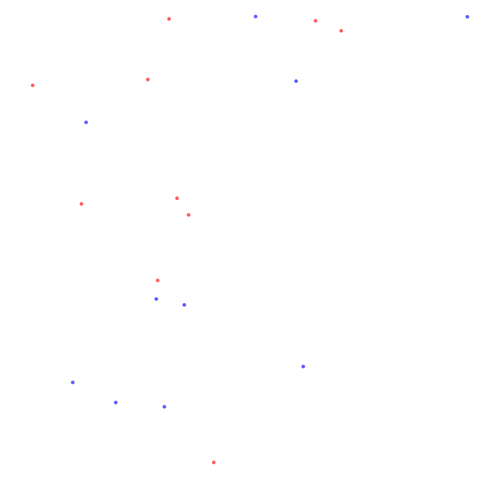

131
32.75


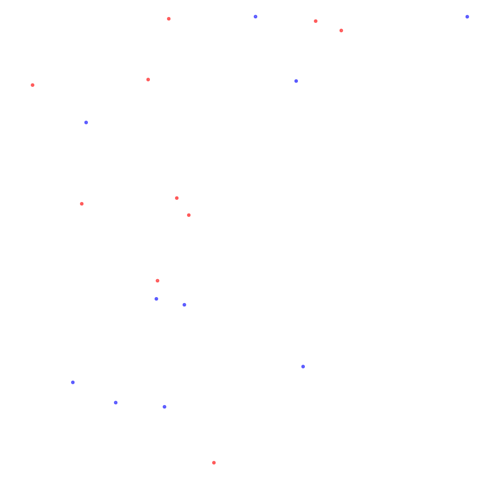

132
33.0


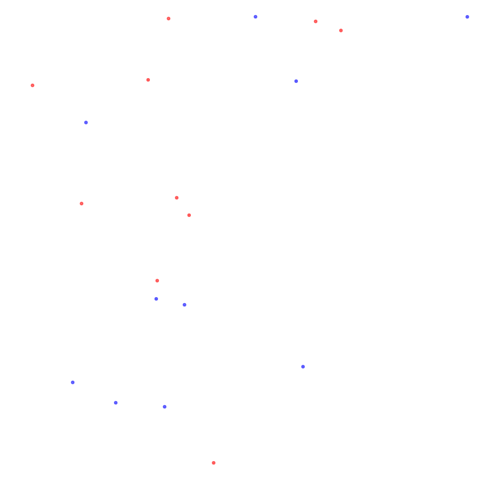

133
33.25


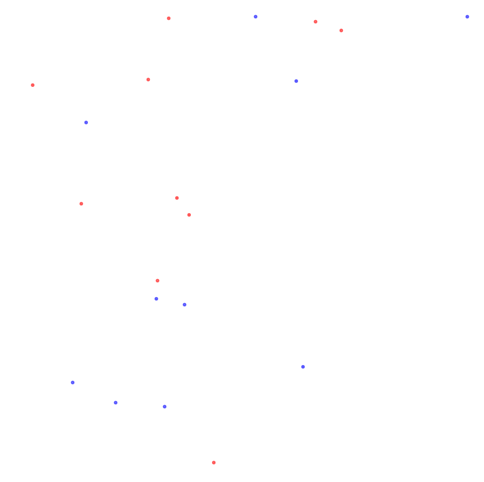

134
33.5


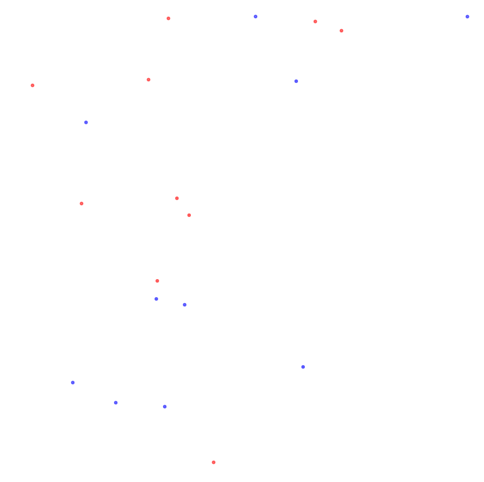

135
33.75


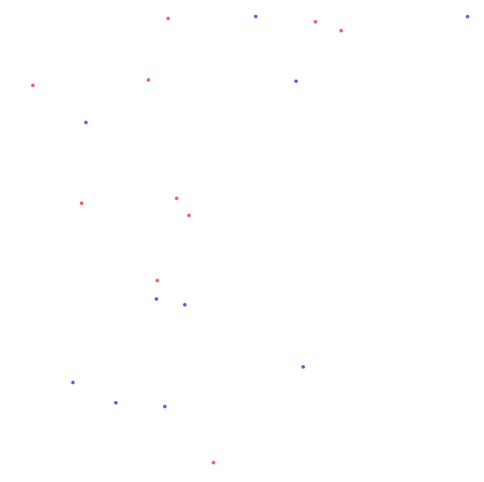

136
34.0


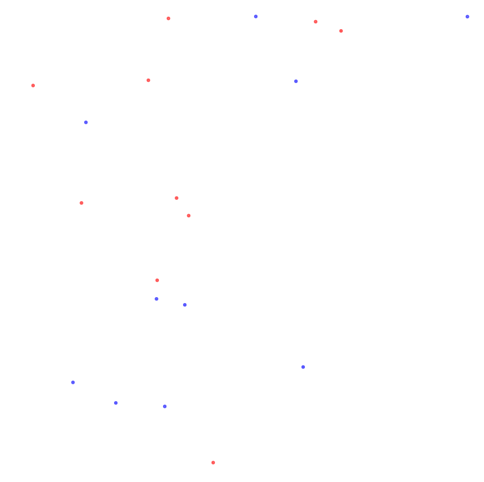

137
34.25


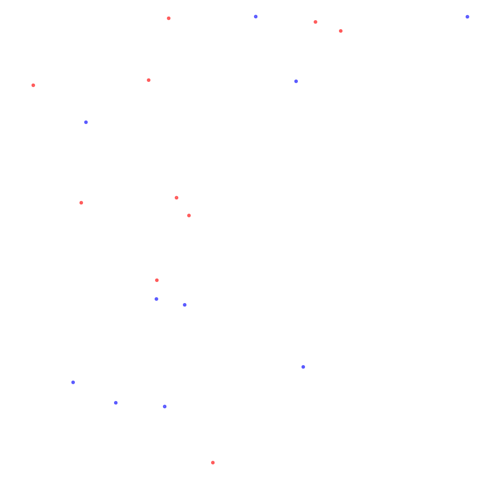

138
34.5


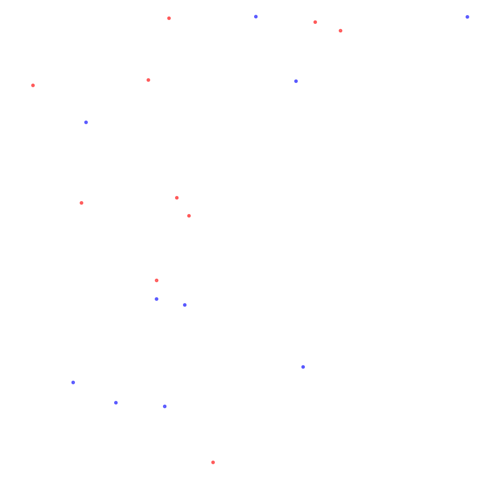

139
34.75


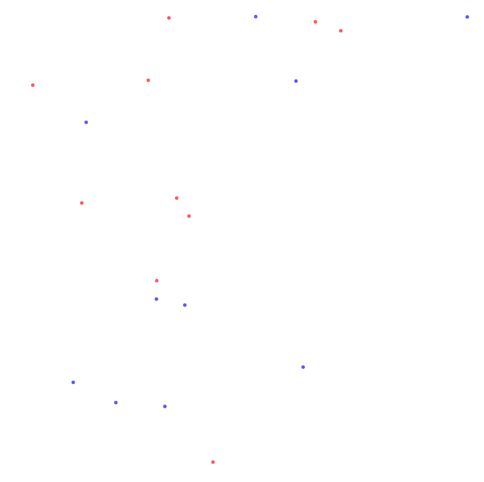

140
35.0


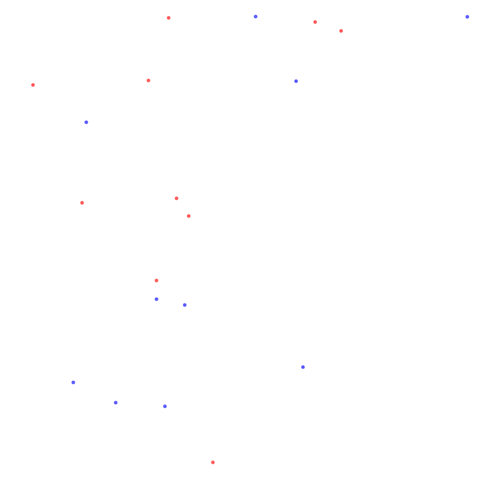

141
35.25


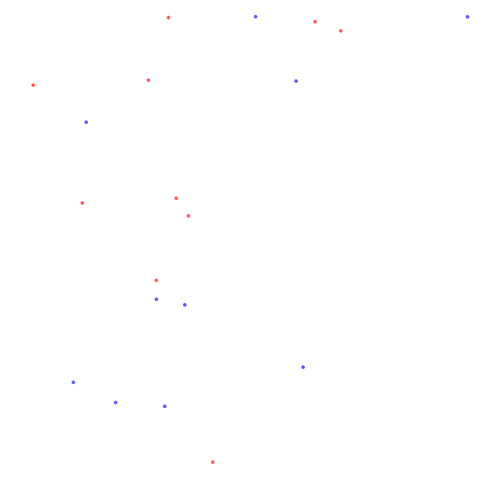

142
35.5


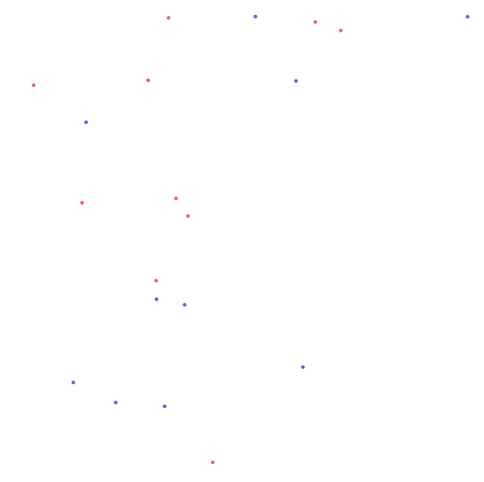

143
35.75


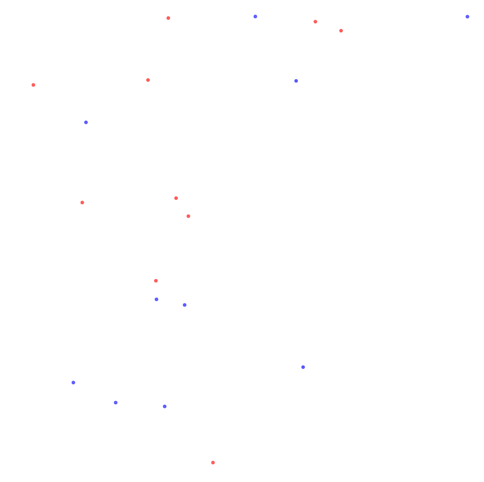

144
36.0


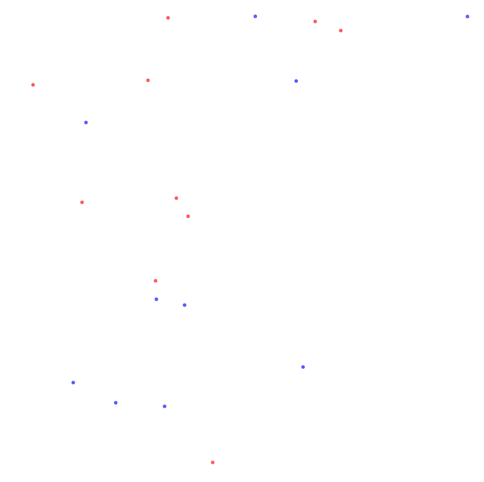

145
36.25


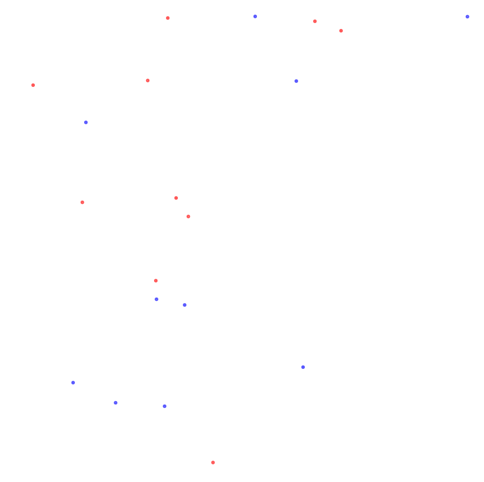

146
36.5


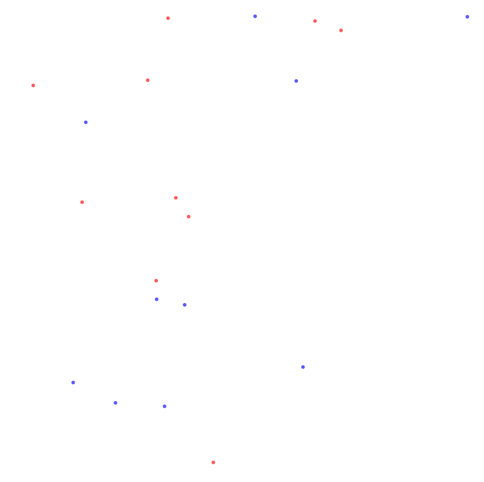

147
36.75


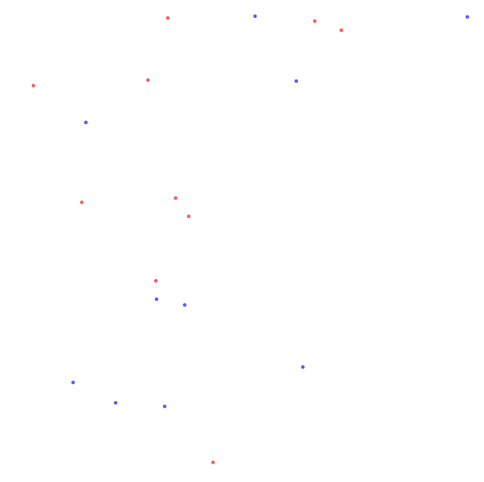

148
37.0


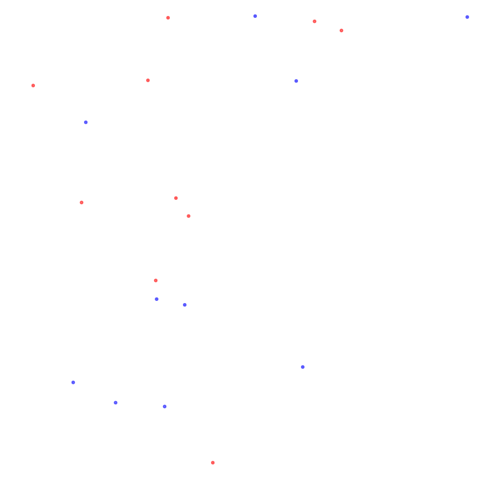

149
37.25


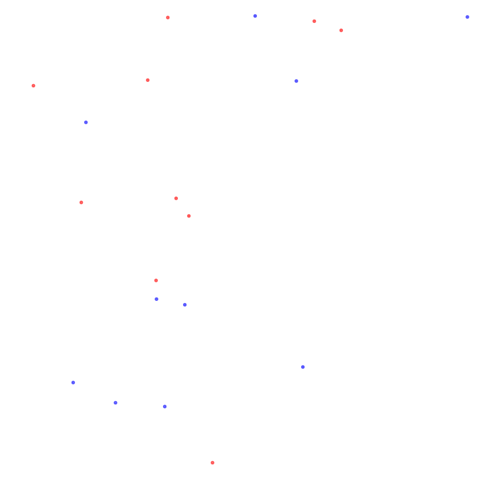

150
37.5


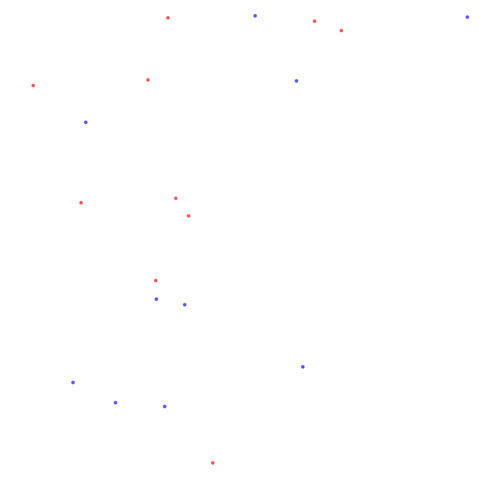

151
37.75


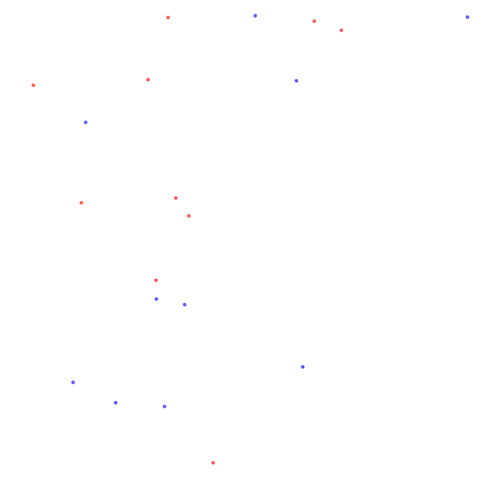

152
38.0


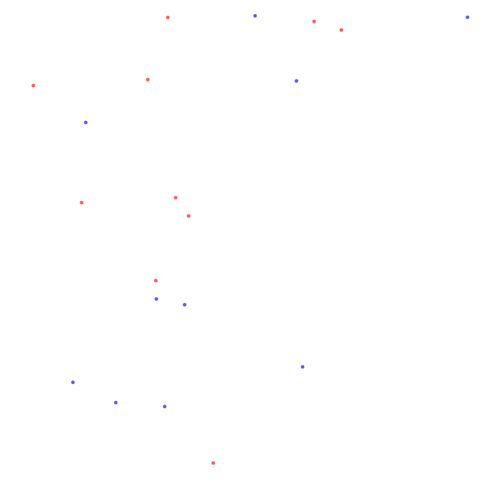

153
38.25


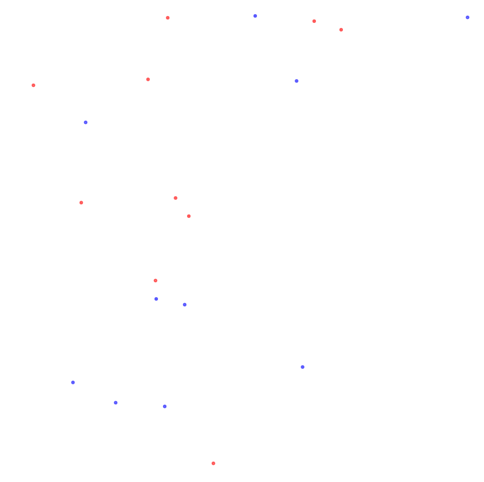

154
38.5


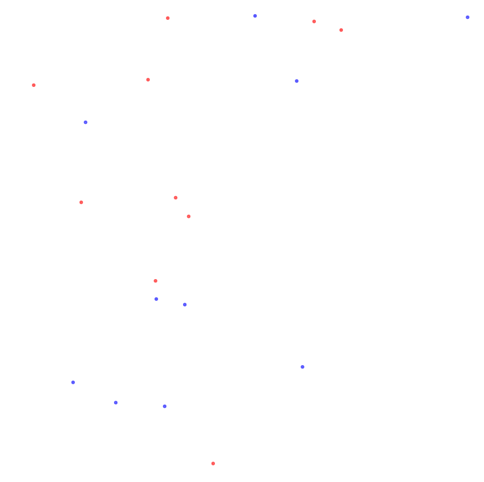

155
38.75


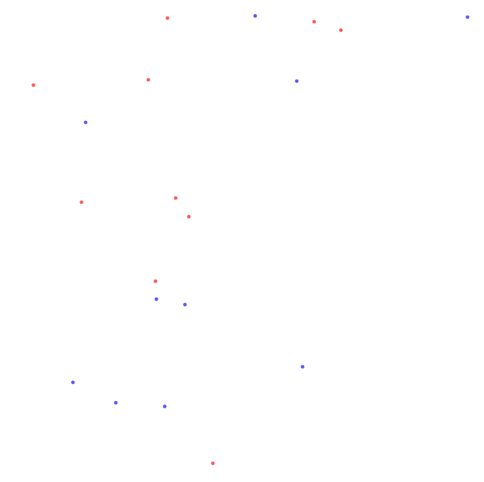

156
39.0


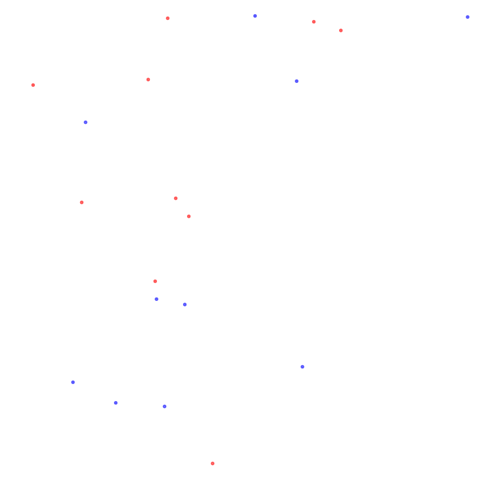

157
39.25


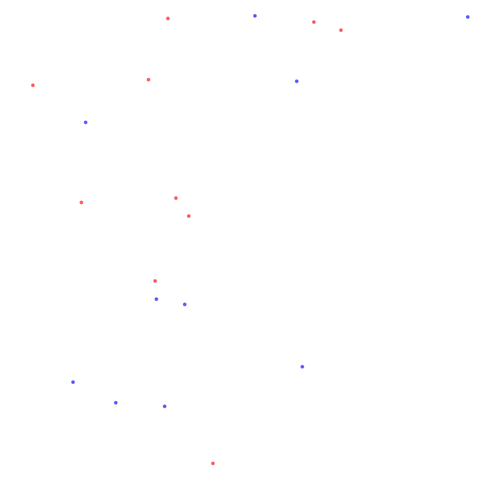

158
39.5


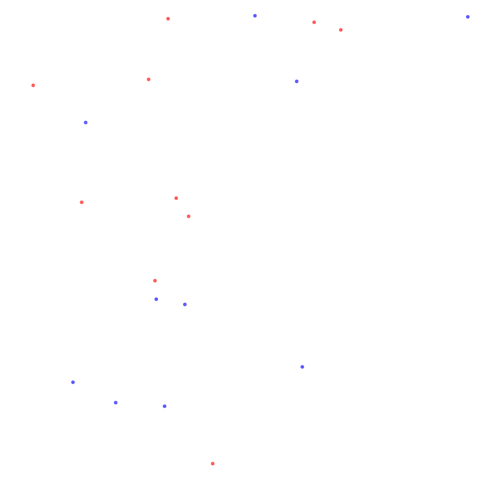

159
39.75


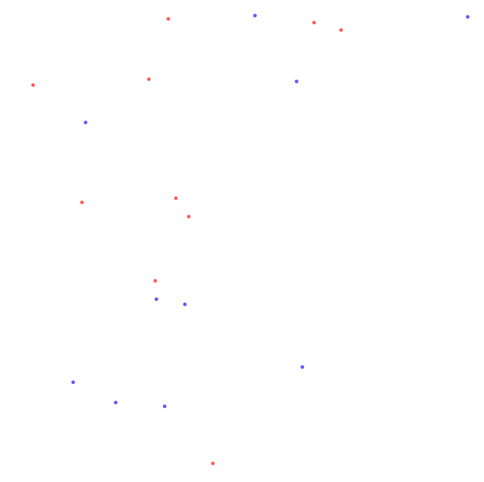

160
40.0


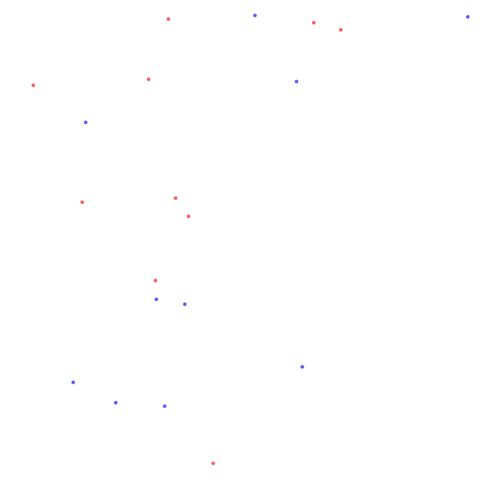

161
40.25


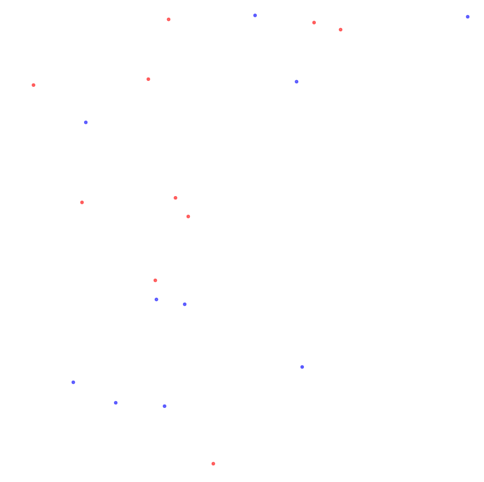

162
40.5


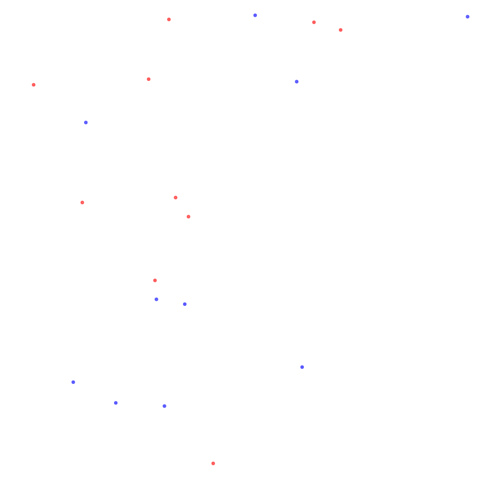

163
40.75


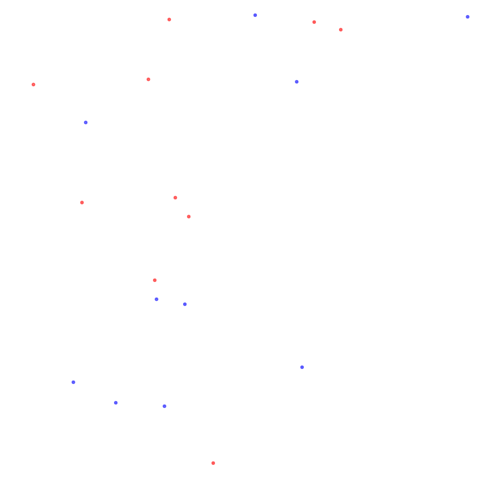

164
41.0


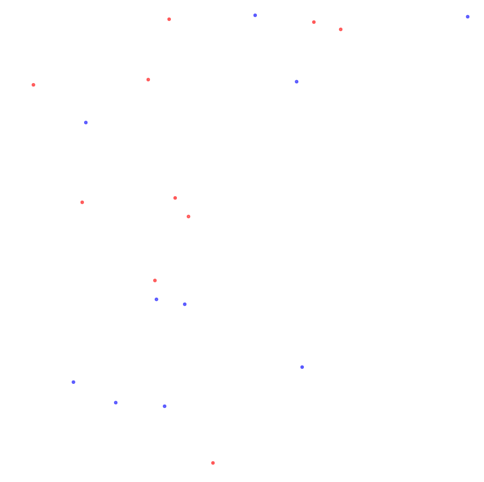

165
41.25


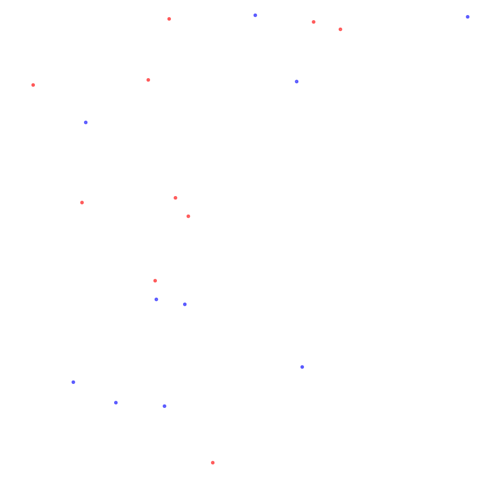

166
41.5


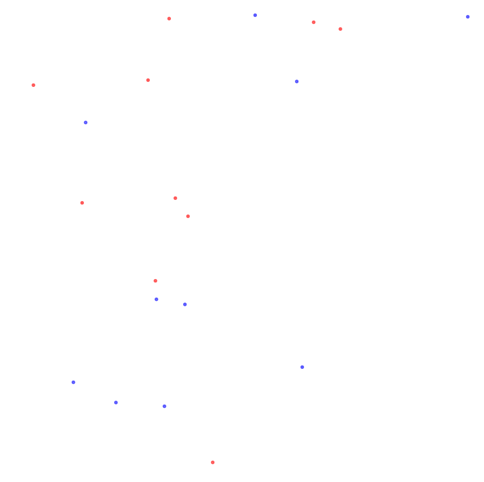

167
41.75


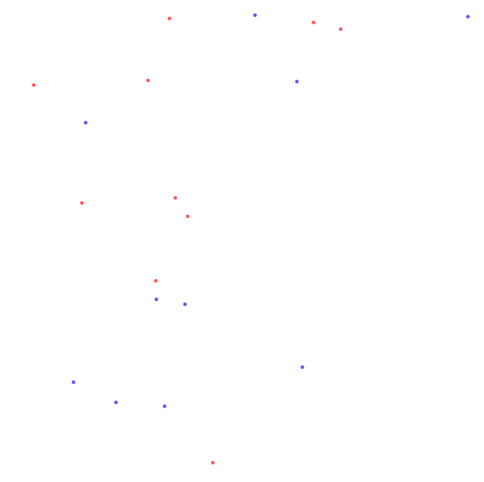

168
42.0


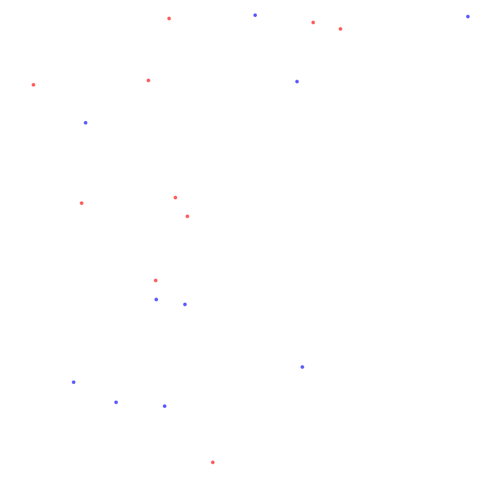

169
42.25


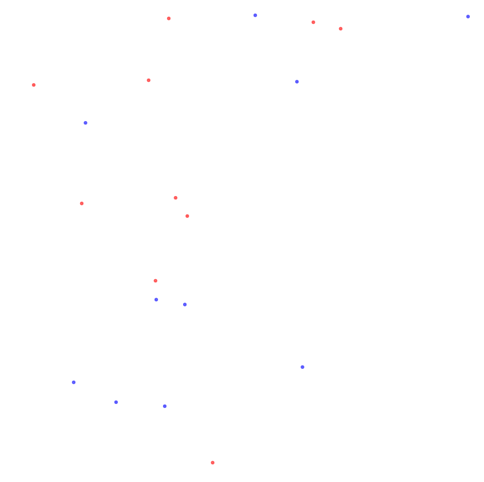

170
42.5


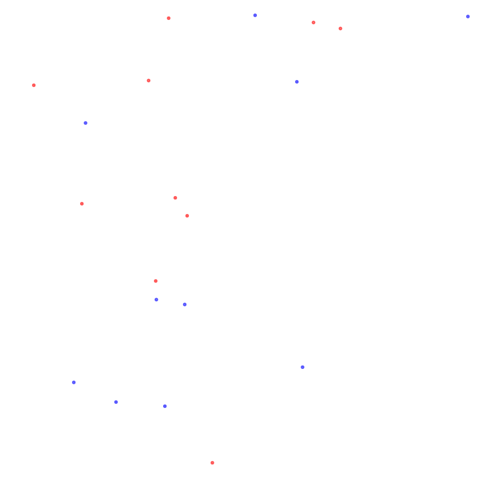

171
42.75


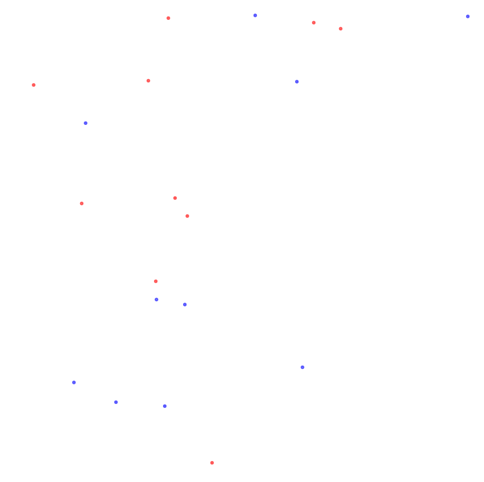

172
43.0


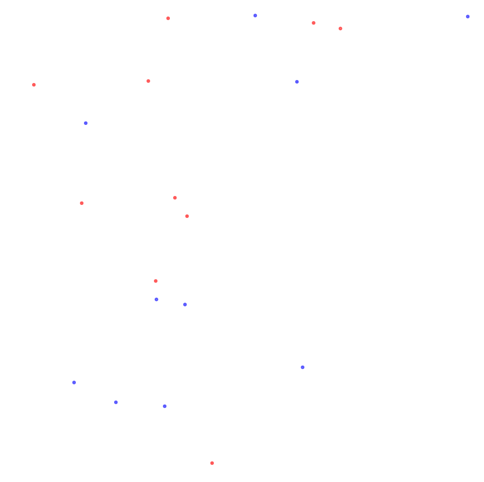

173
43.25


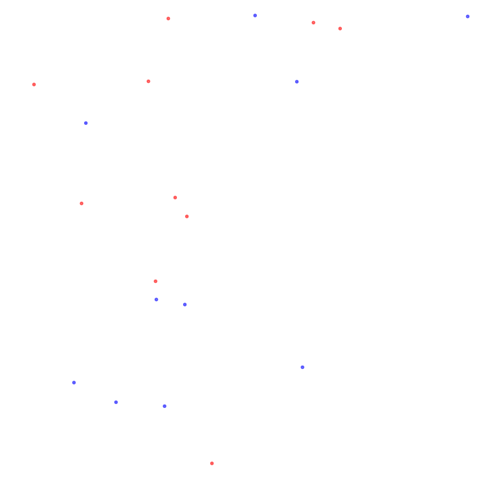

174
43.5


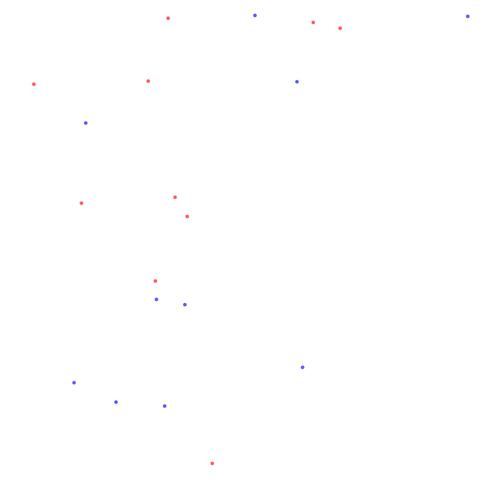

175
43.75


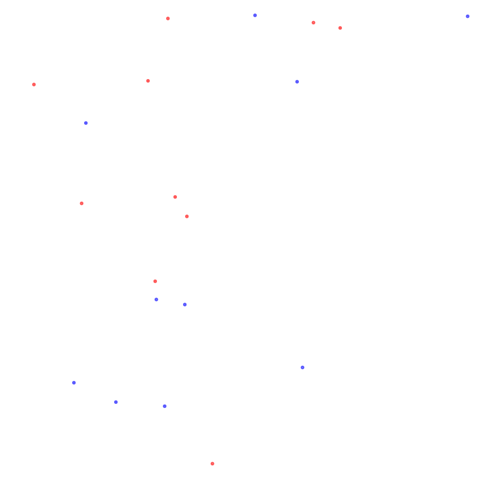

176
44.0


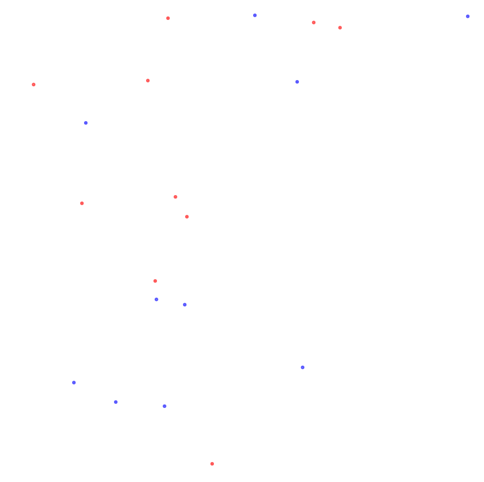

177
44.25


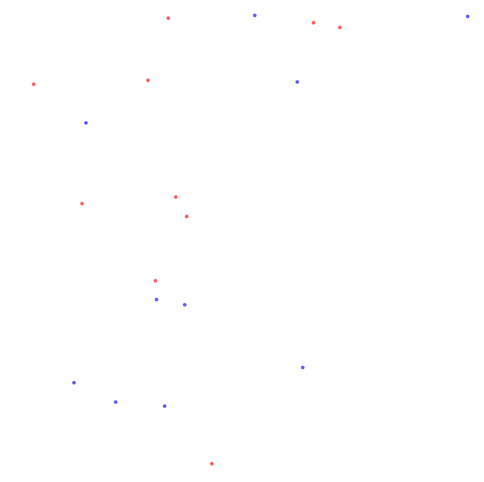

178
44.5


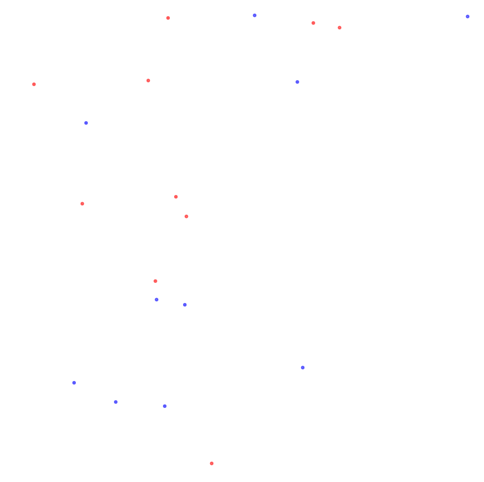

179
44.75


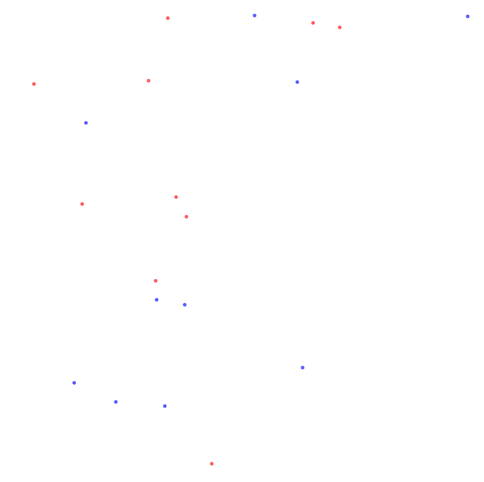

180
45.0


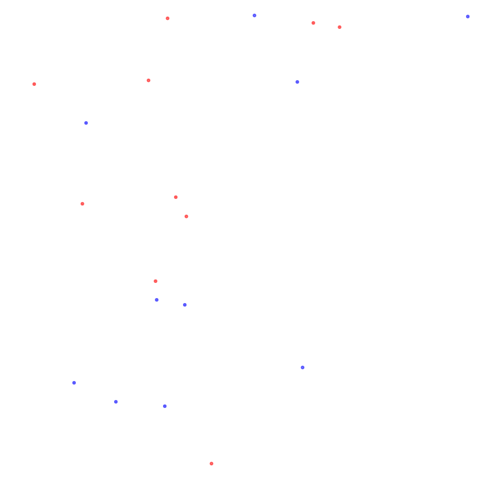

181
45.25


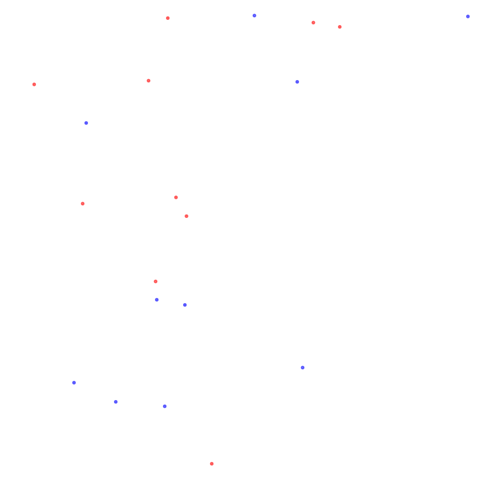

182
45.5


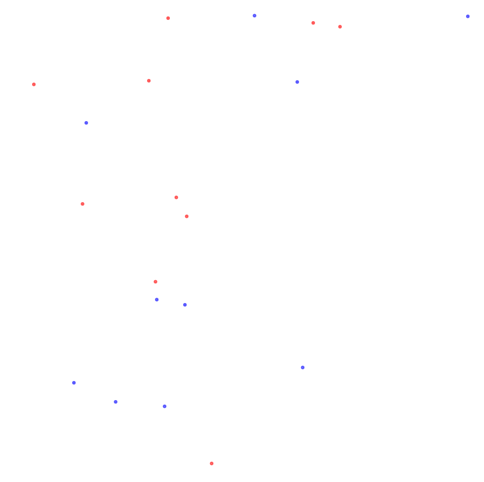

183
45.75


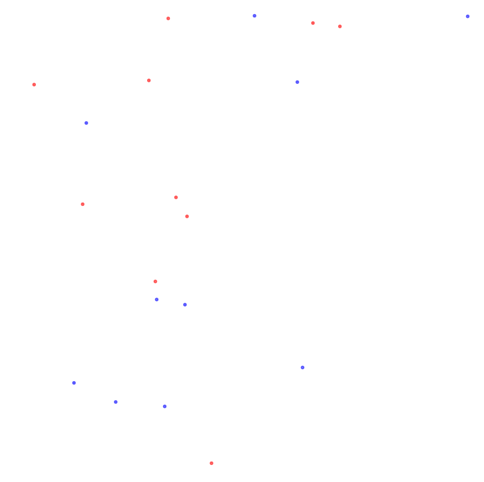

184
46.0


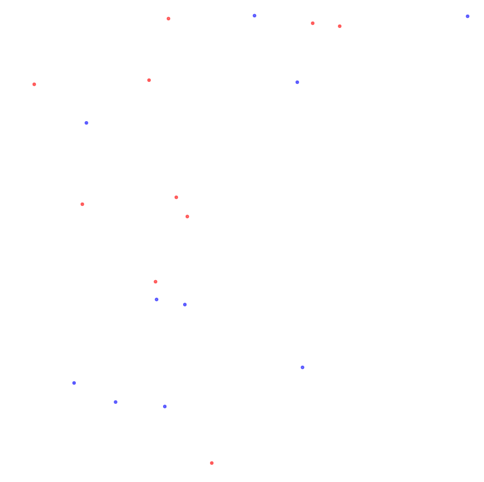

185
46.25


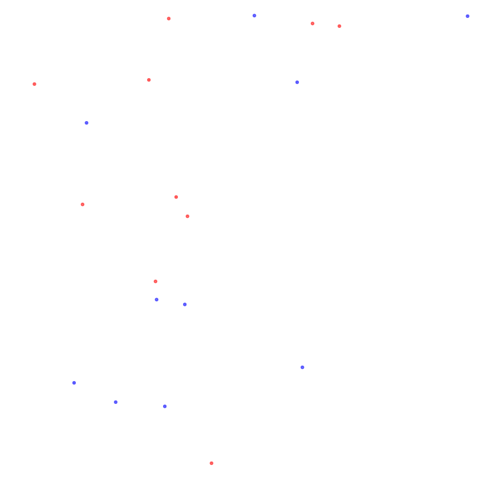

186
46.5


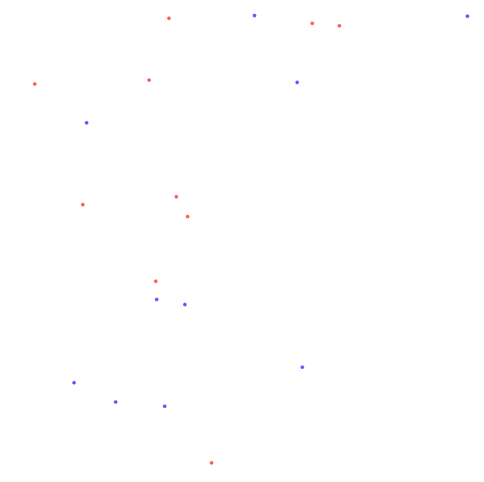

187
46.75


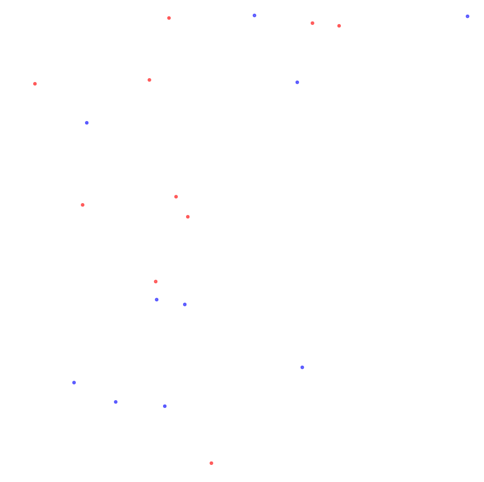

188
47.0


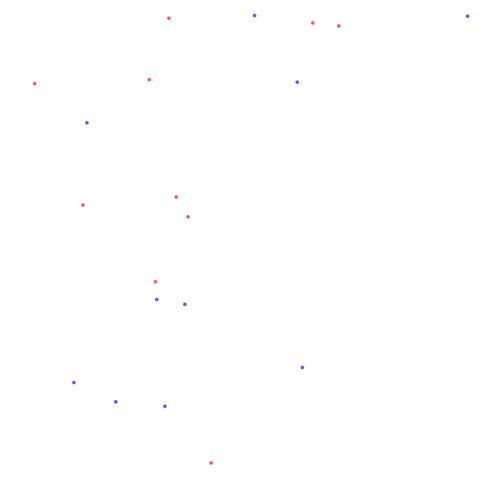

189
47.25


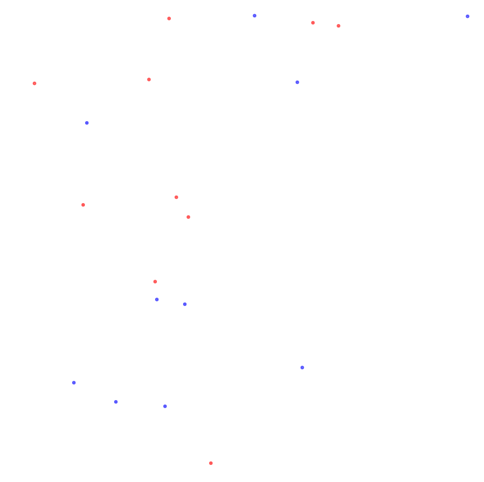

190
47.5


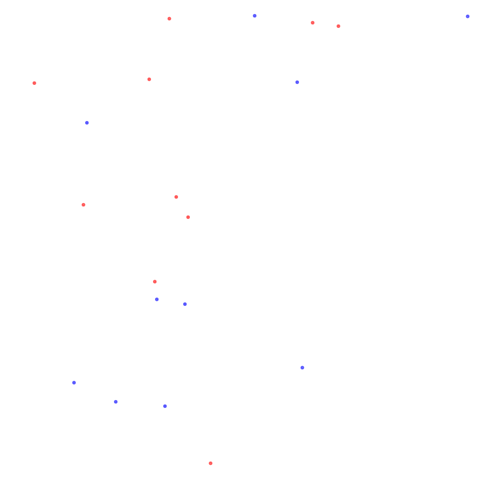

191
47.75


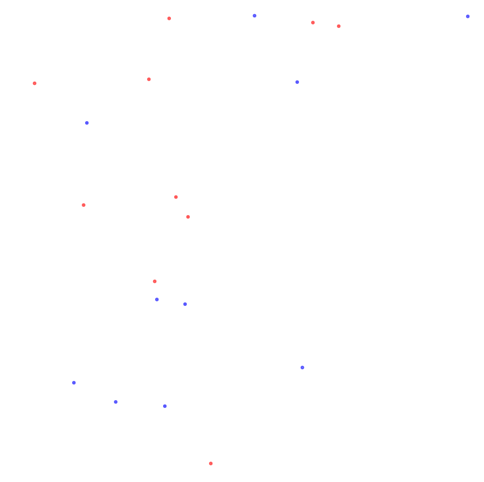

192
48.0


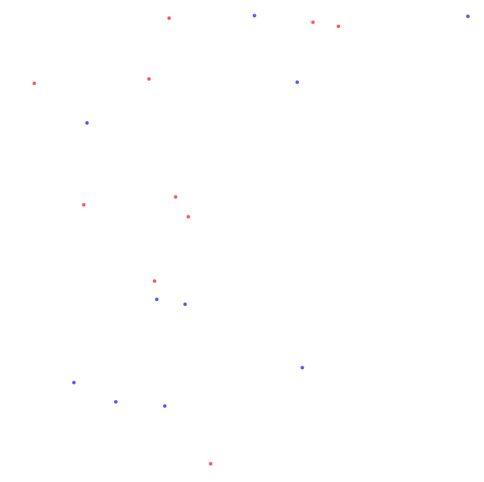

193
48.25


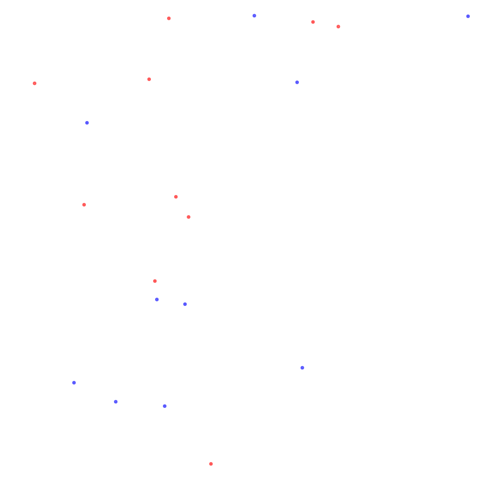

194
48.5


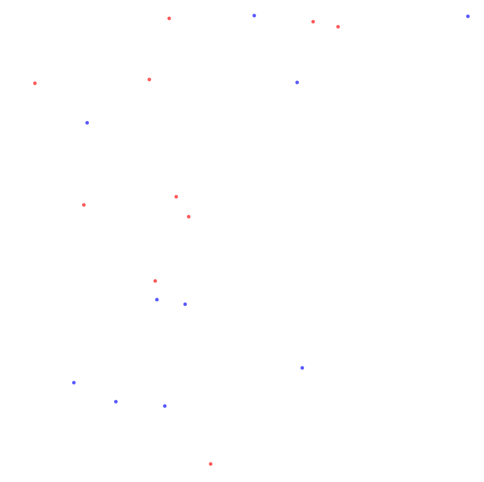

195
48.75


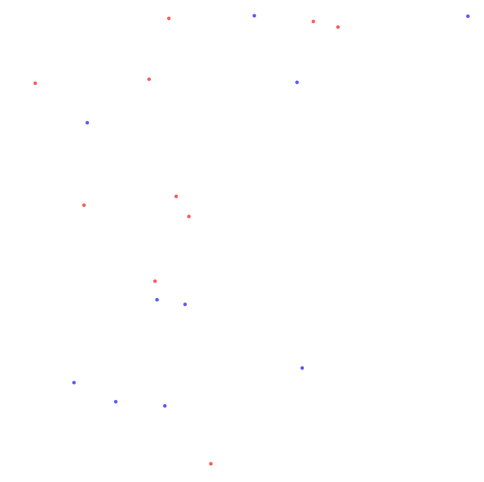

196
49.0


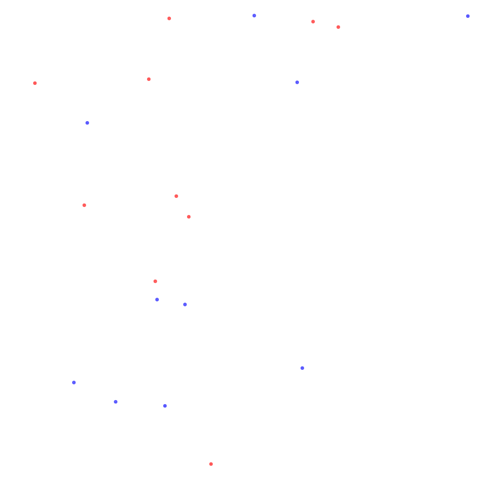

197
49.25


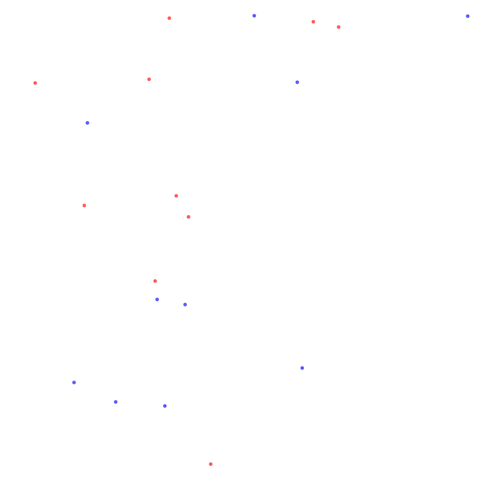

198
49.5


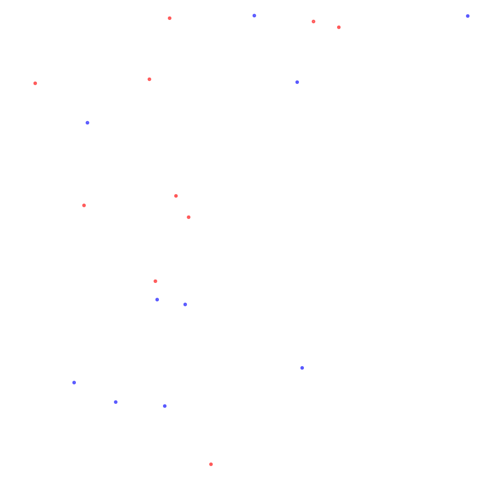

199
49.75


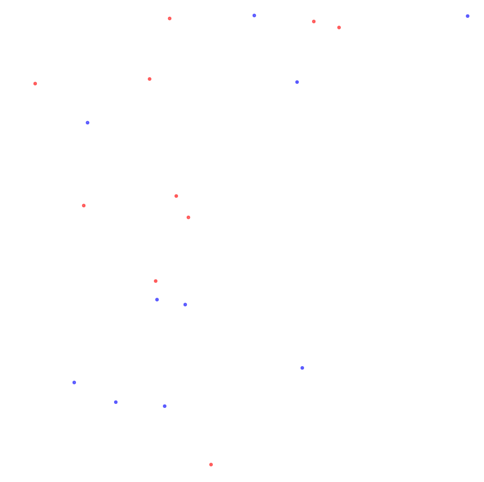

200
50.0


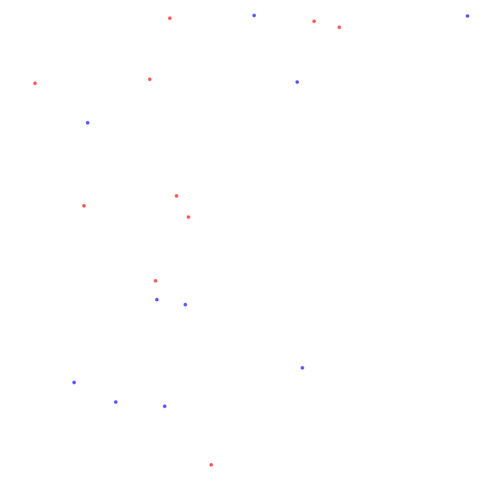

201
50.25


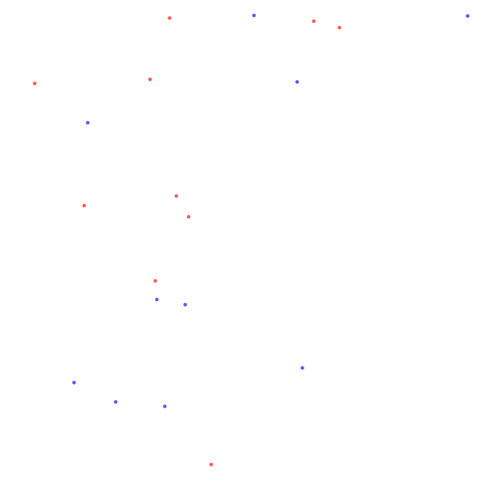

202
50.5


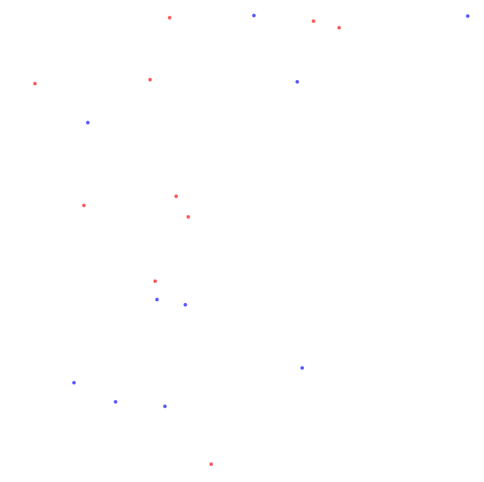

203
50.75


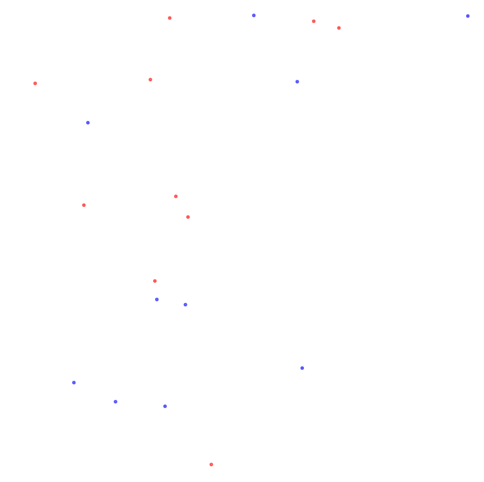

204
51.0


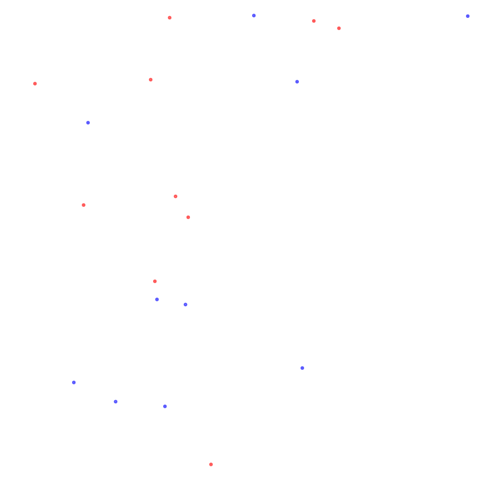

205
51.25


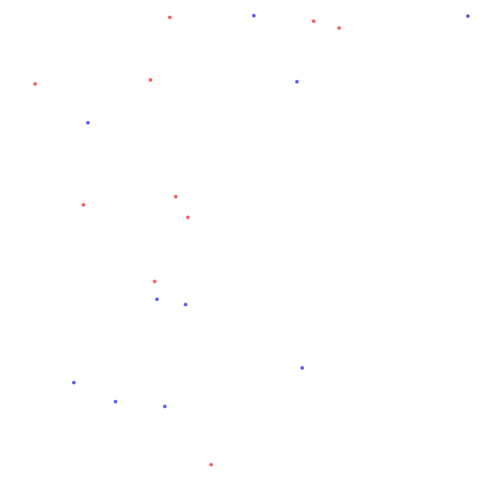

206
51.5


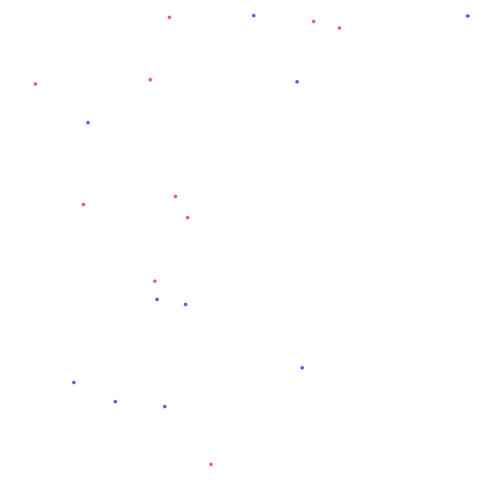

207
51.75


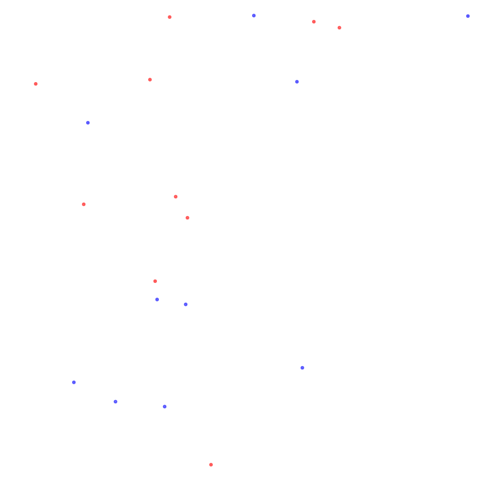

208
52.0


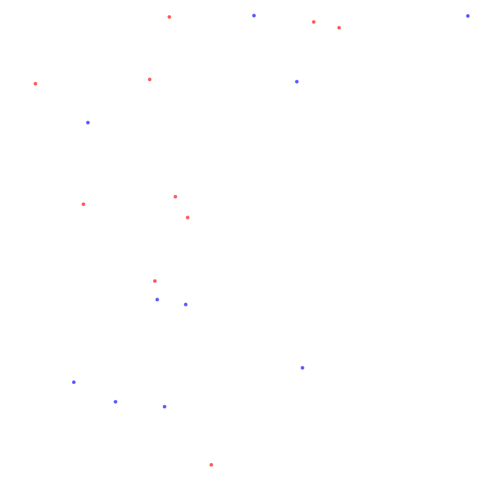

209
52.25


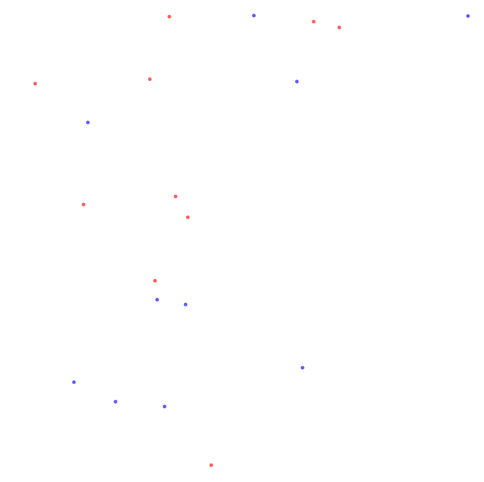

210
52.5


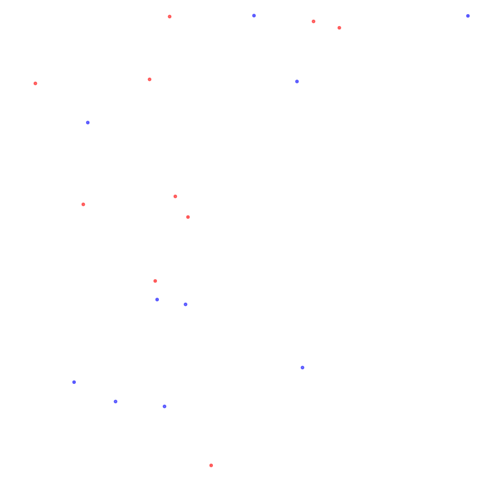

211
52.75


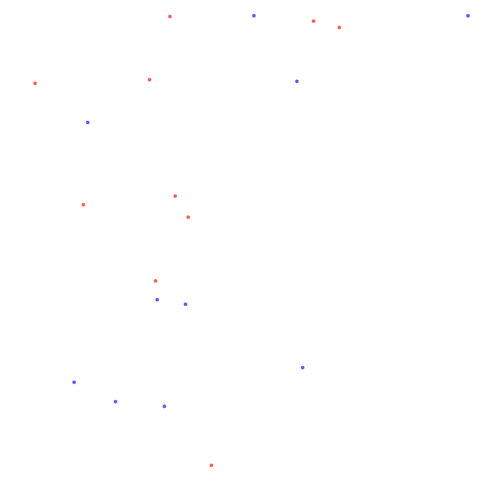

212
53.0


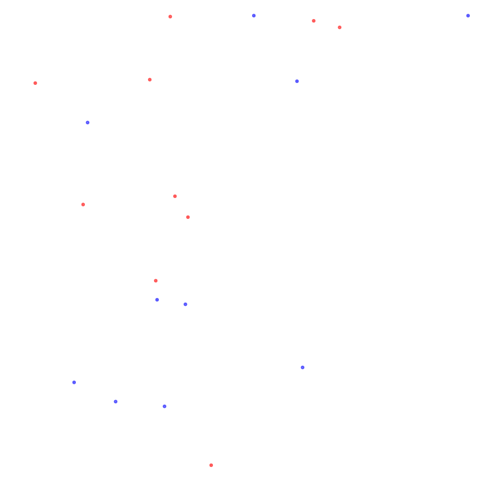

213
53.25


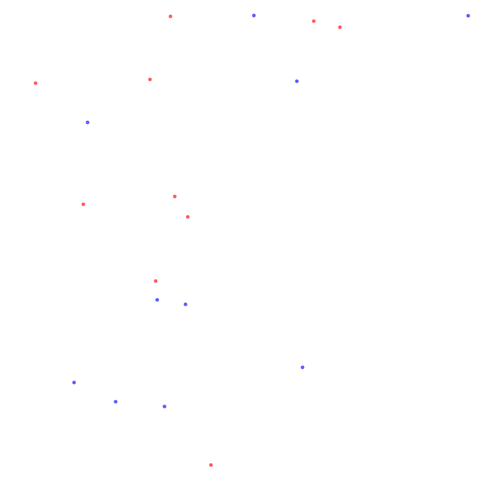

214
53.5


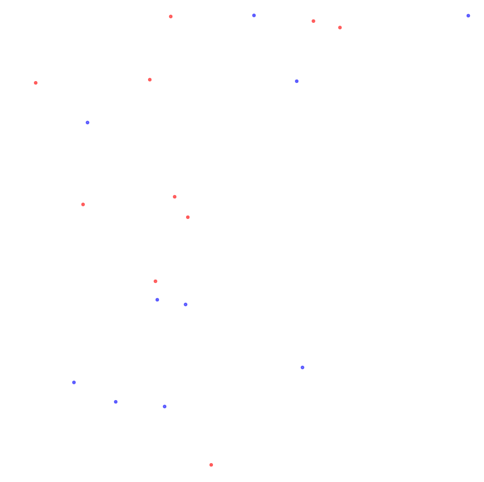

215
53.75


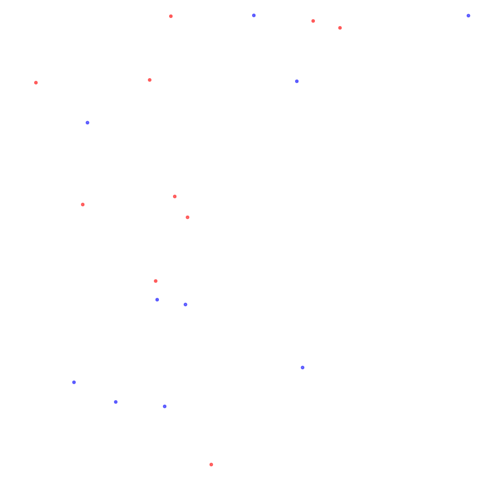

216
54.0


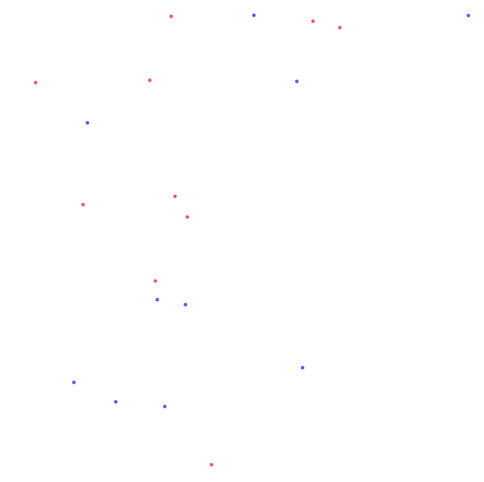

217
54.25


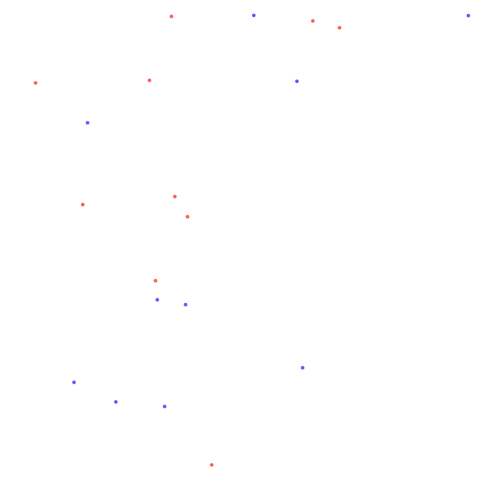

218
54.5


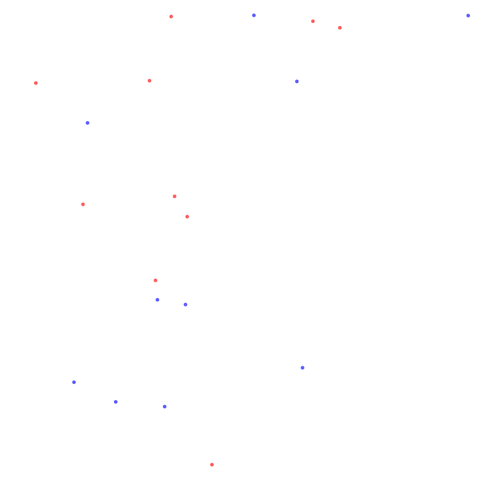

219
54.75


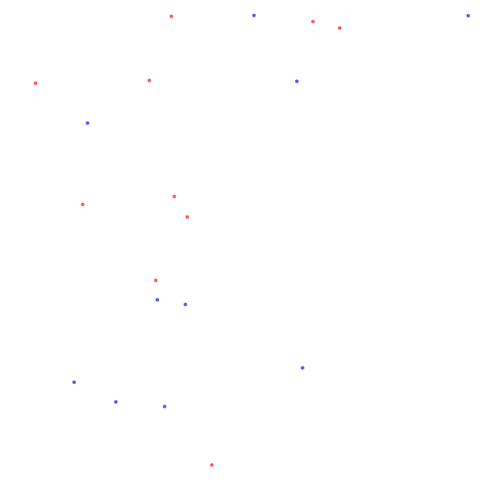

220
55.0


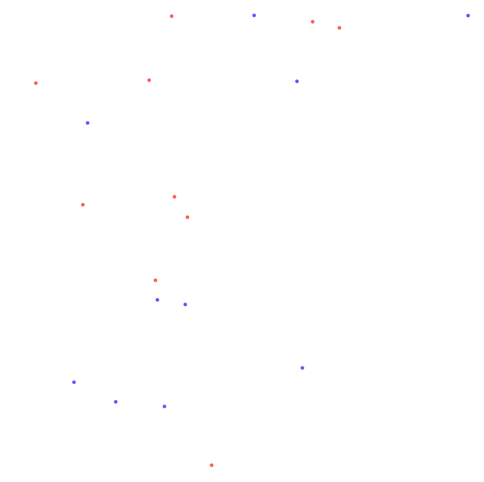

221
55.25


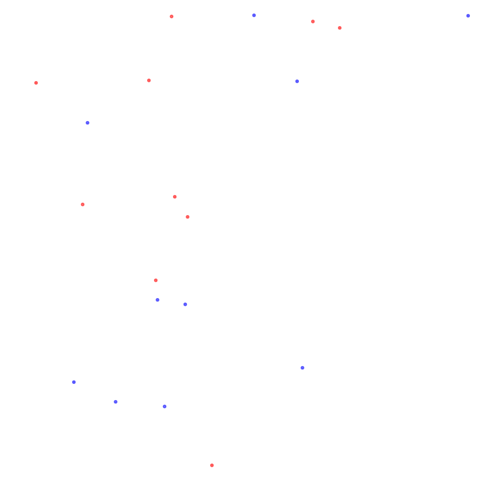

222
55.5


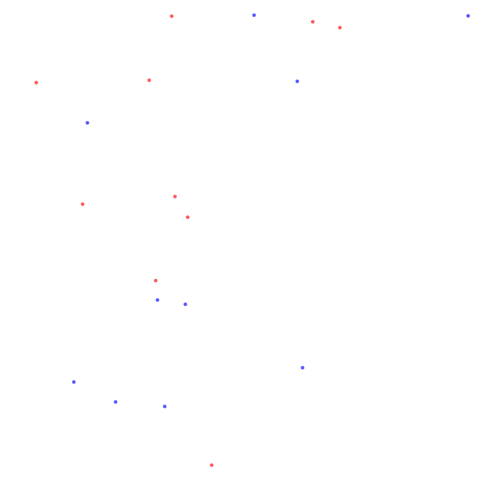

223
55.75


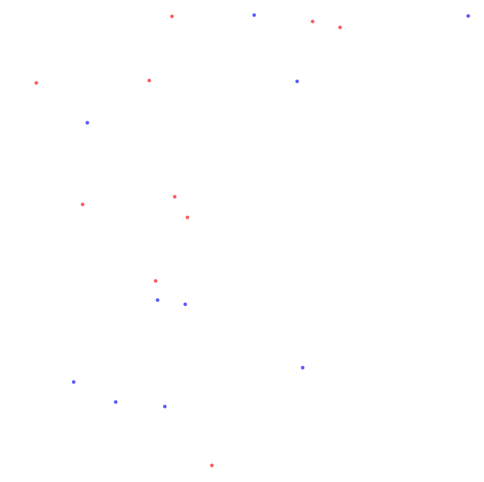

224
56.0


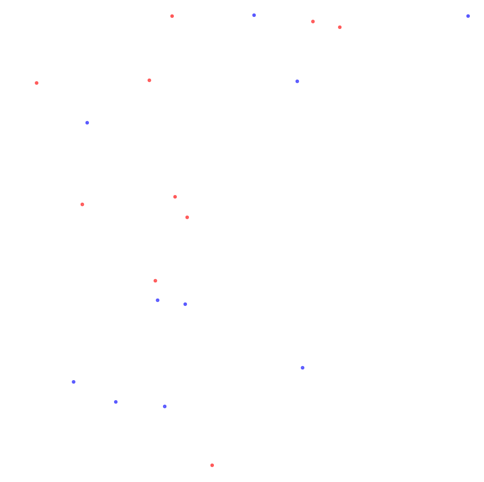

225
56.25


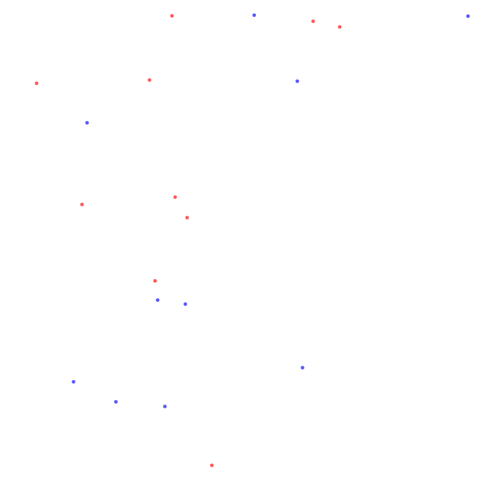

226
56.5


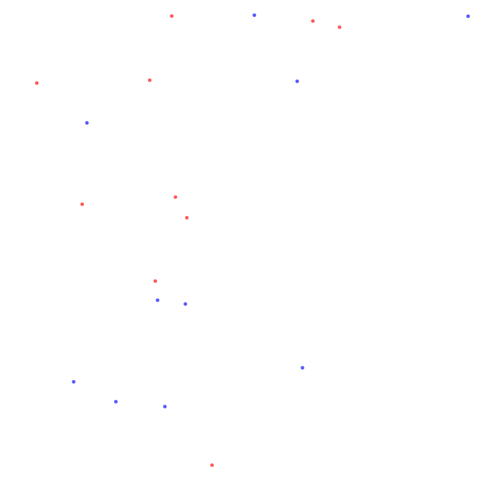

227
56.75


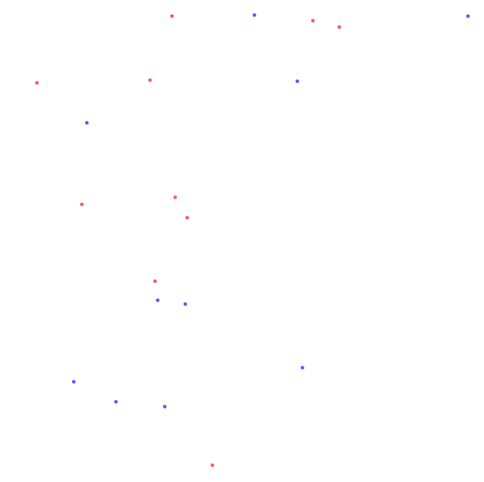

228
57.0


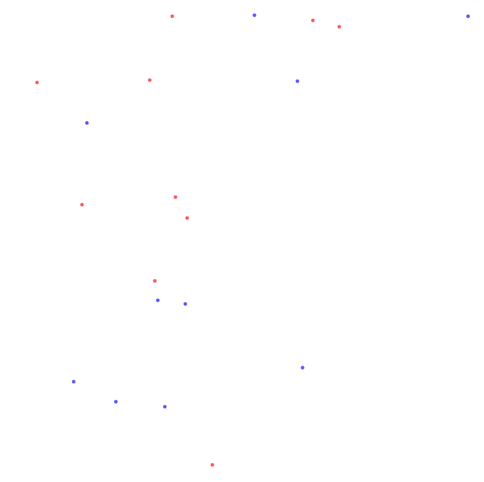

229
57.25


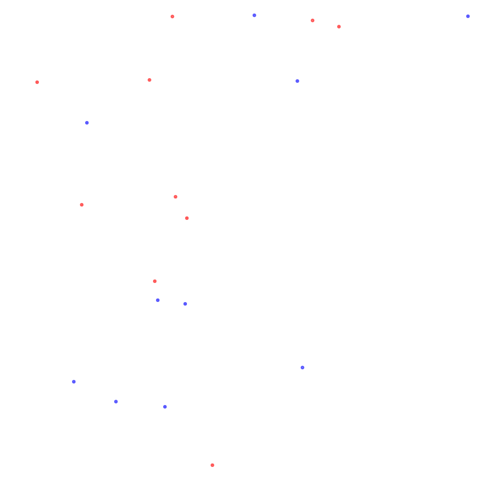

230
57.5


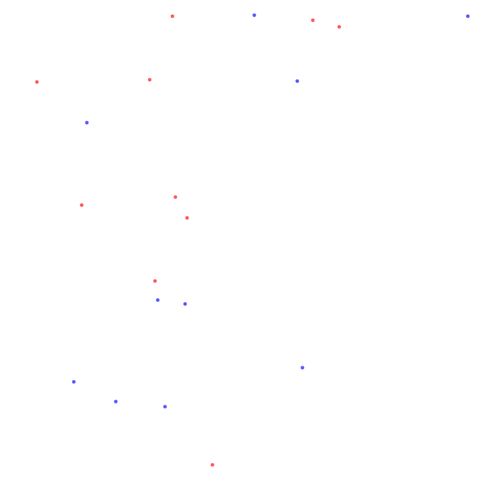

231
57.75


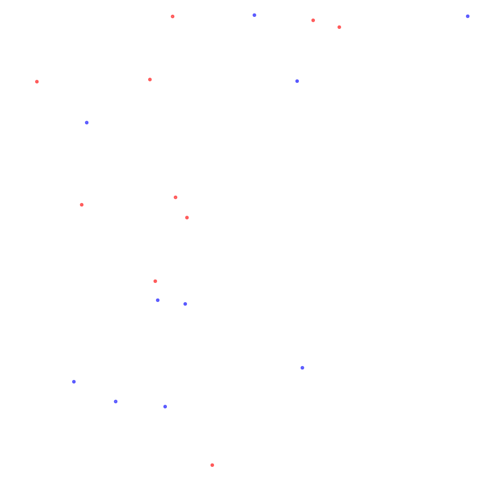

232
58.0


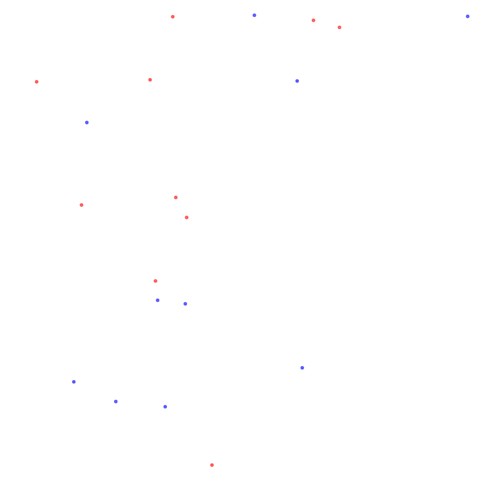

233
58.25


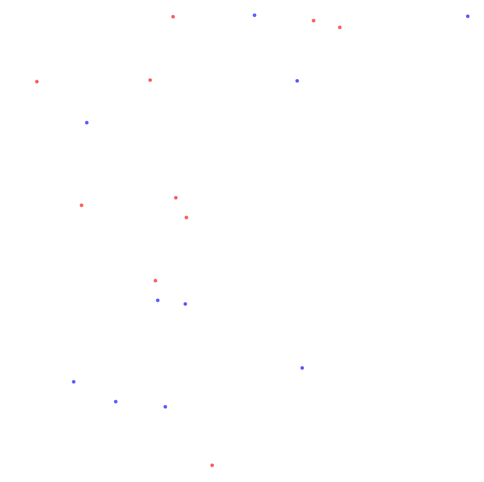

234
58.5


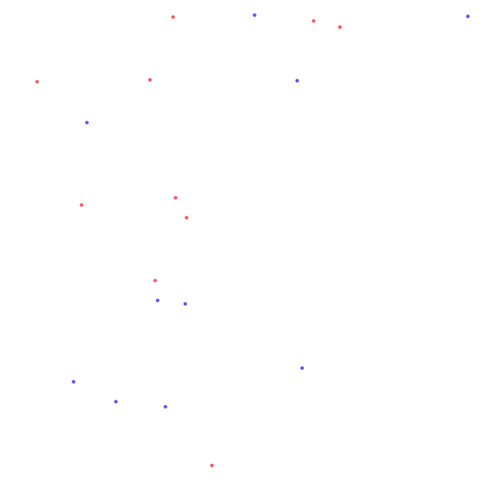

235
58.75


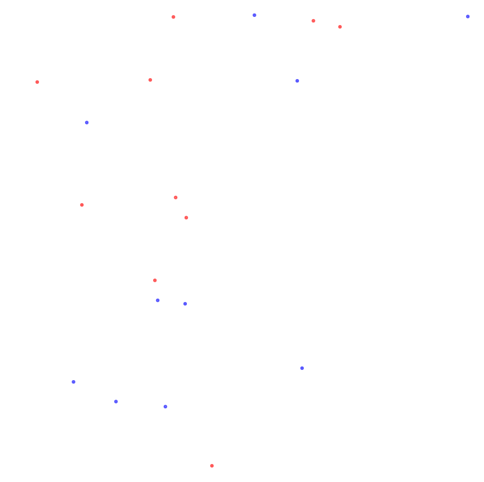

236
59.0


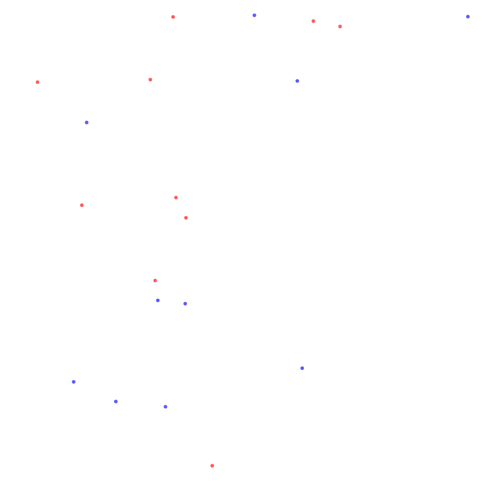

237
59.25


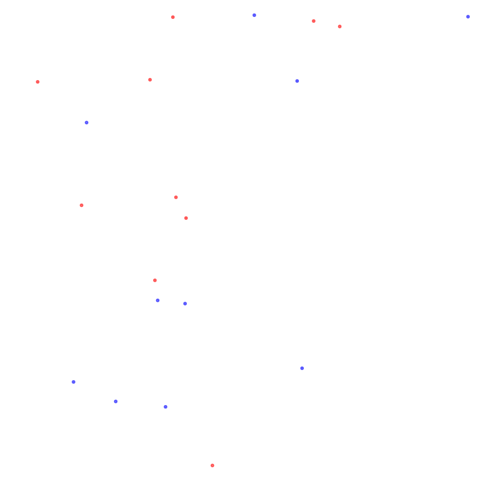

238
59.5


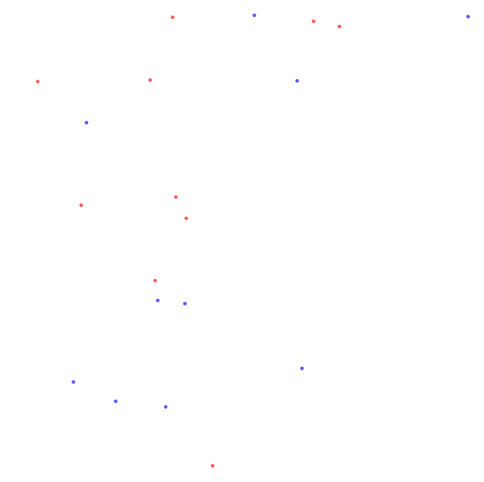

239
59.75


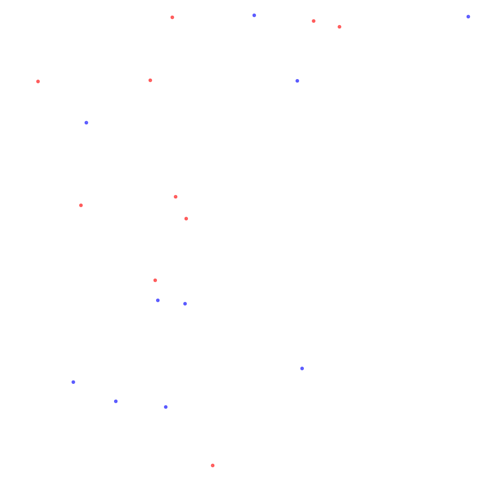

240
60.0


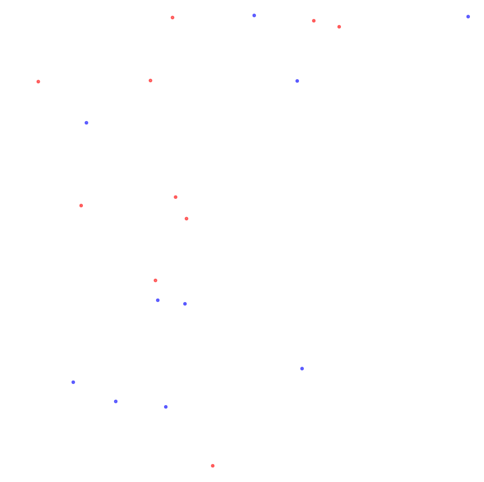

241
60.25


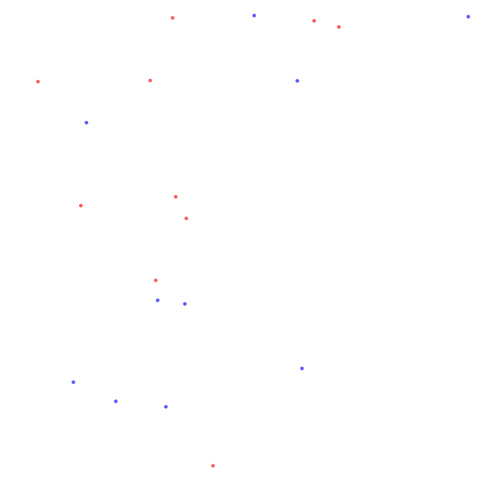

242
60.5


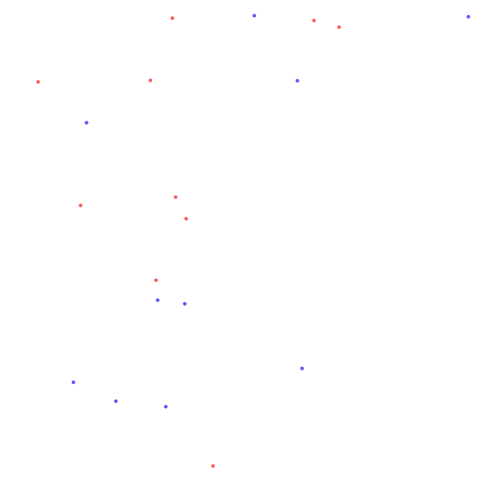

243
60.75


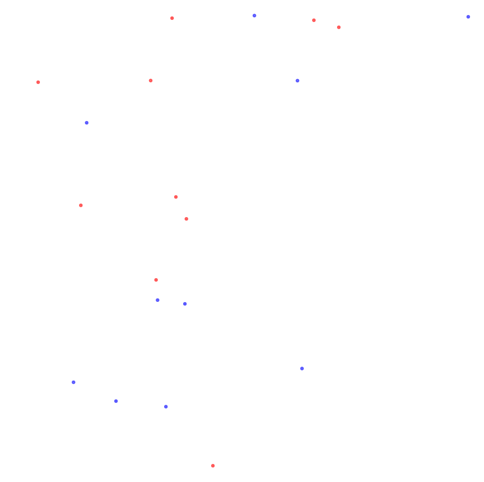

244
61.0


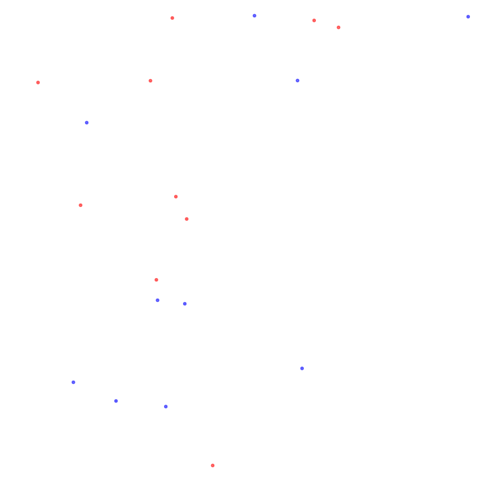

245
61.25


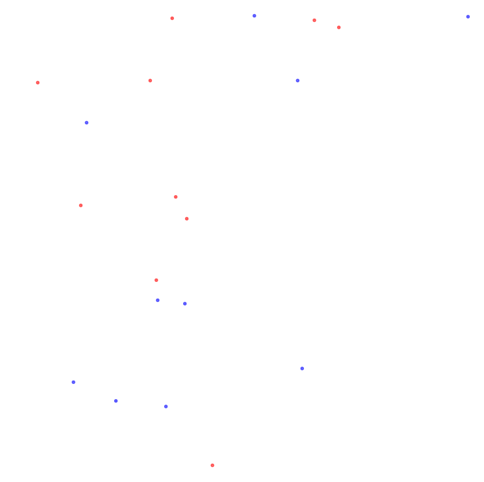

246
61.5


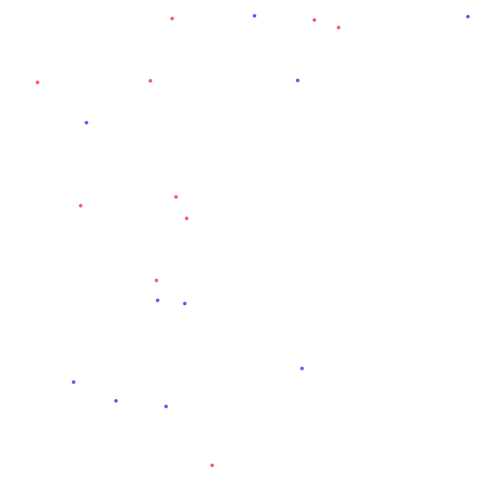

247
61.75


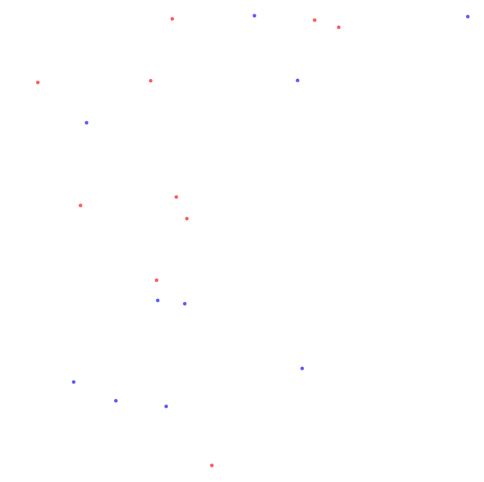

248
62.0


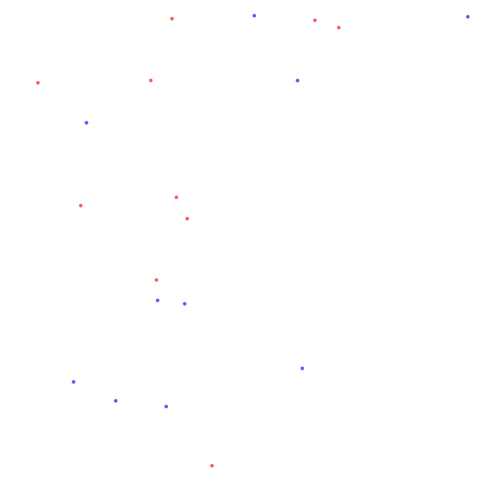

249
62.25


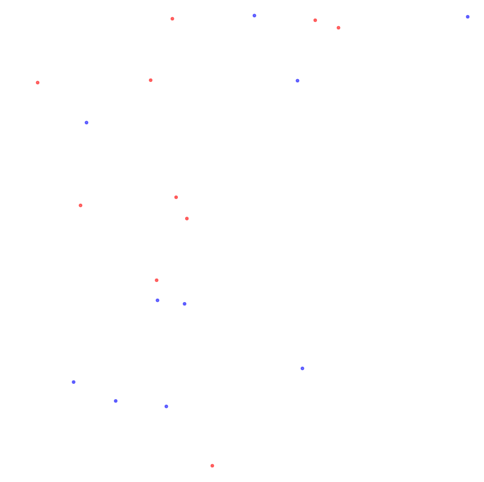

250
62.5


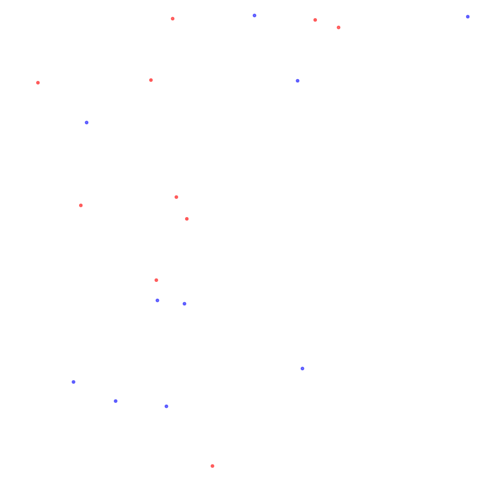

251
62.75


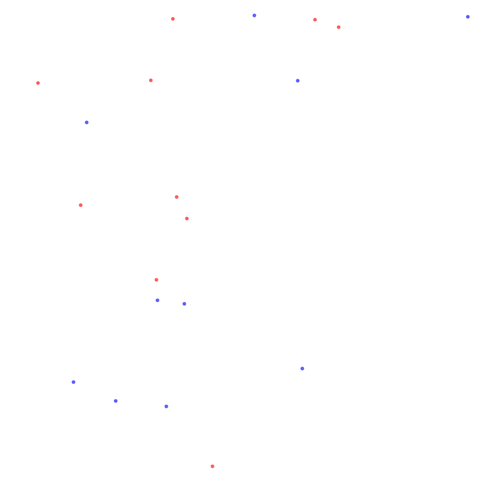

252
63.0


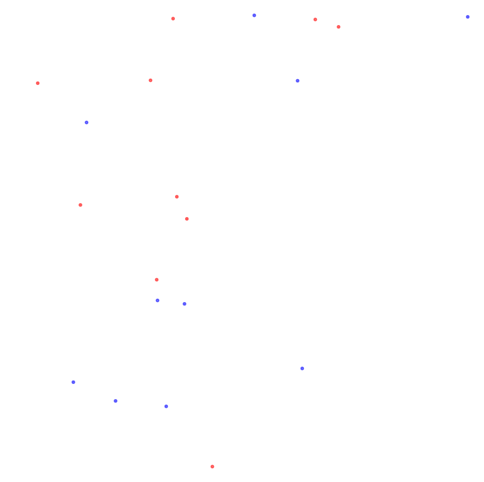

253
63.25


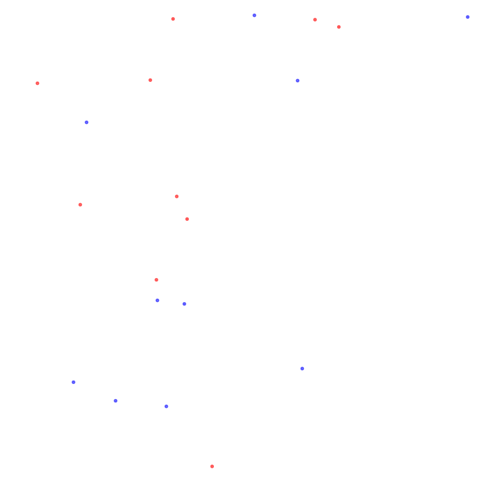

254
63.5


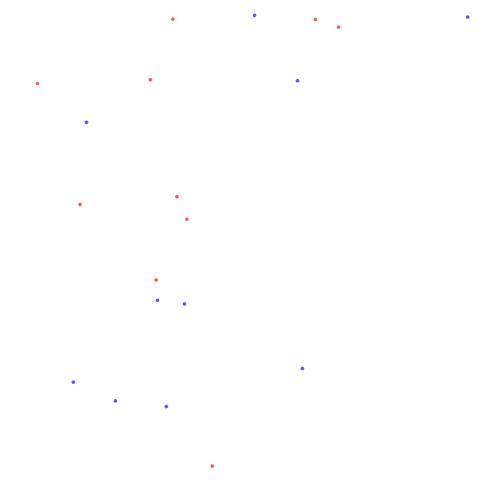

255
63.75


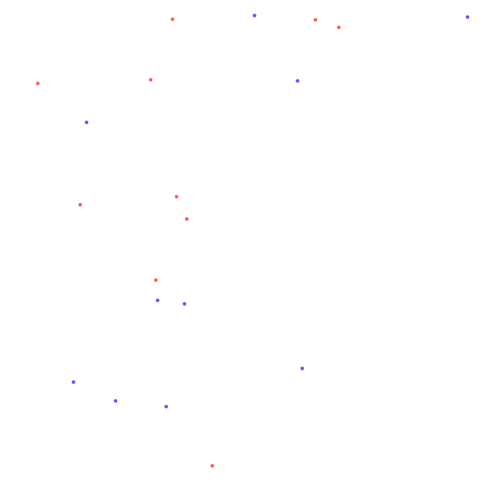

256
64.0


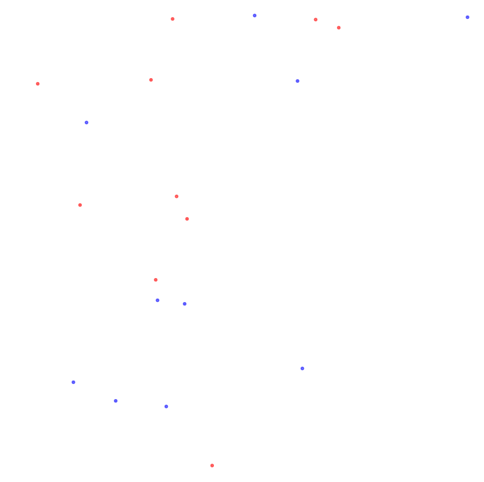

257
64.25


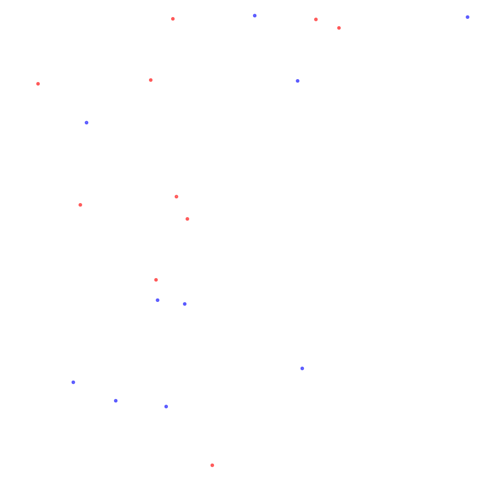

258
64.5


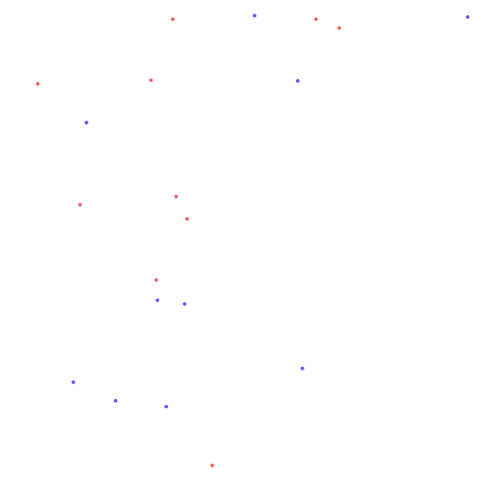

259
64.75


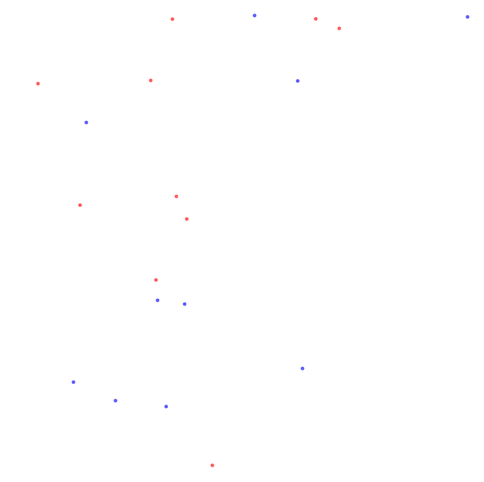

260
65.0


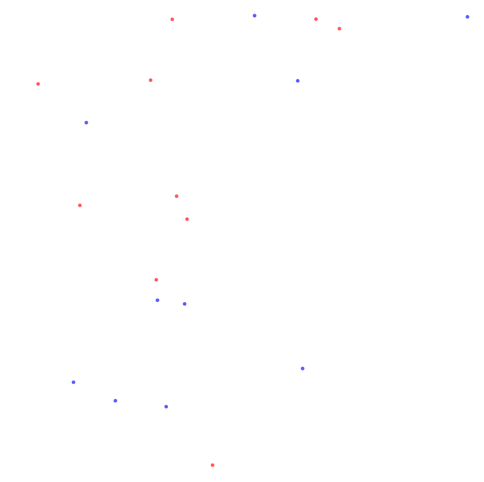

261
65.25


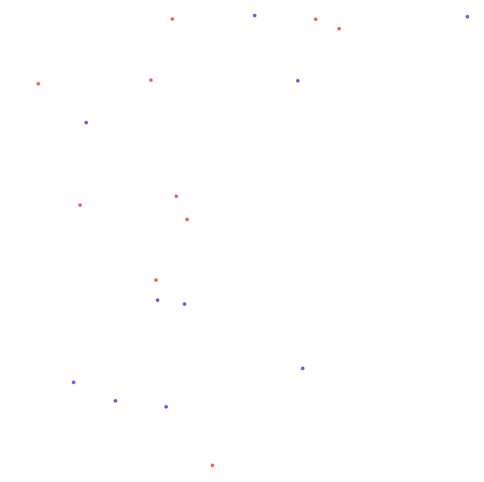

262
65.5


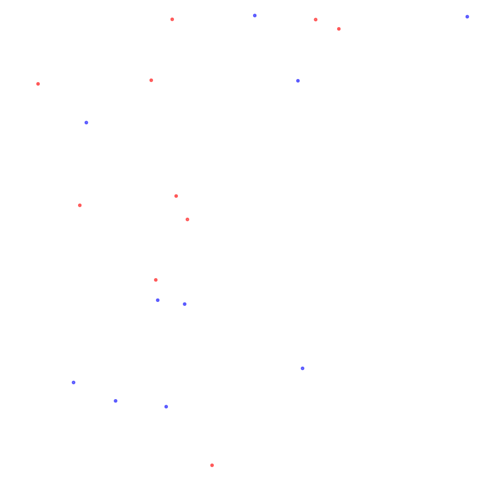

263
65.75


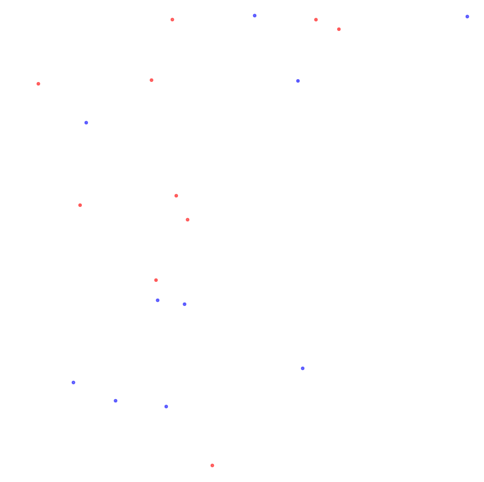

264
66.0


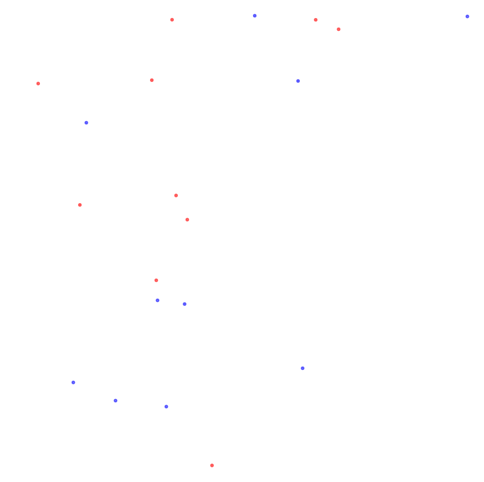

265
66.25


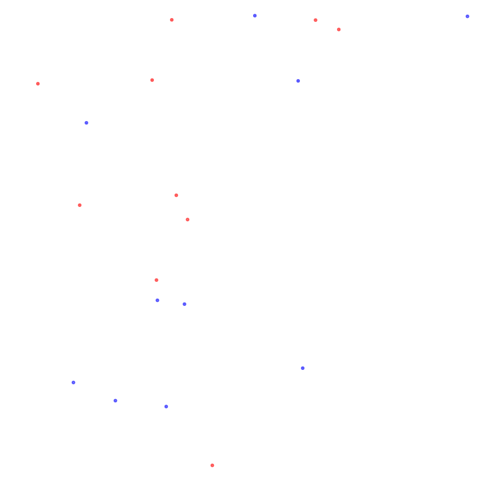

266
66.5


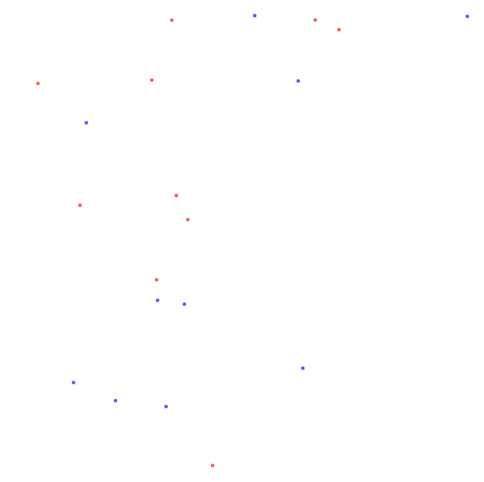

267
66.75


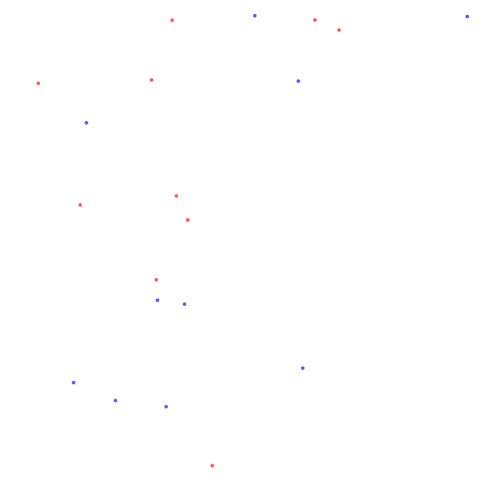

268
67.0


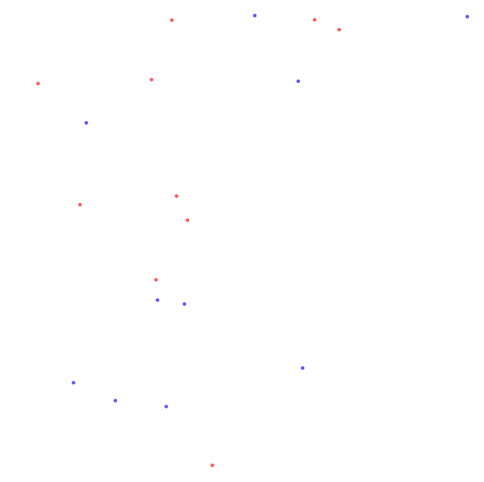

269
67.25


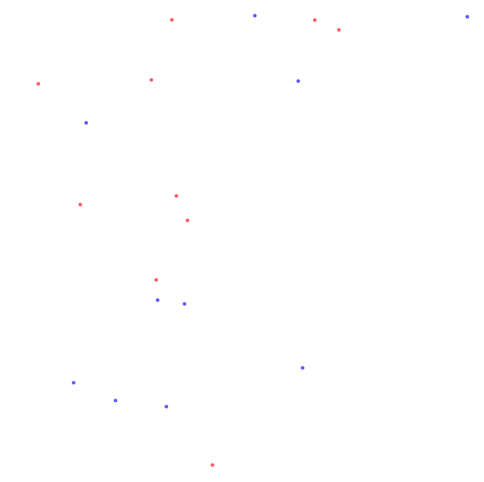

270
67.5


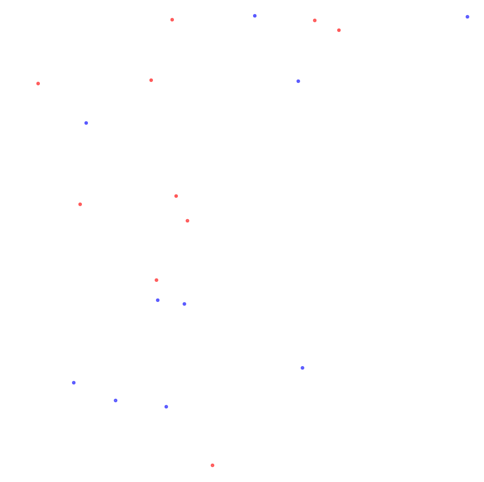

271
67.75


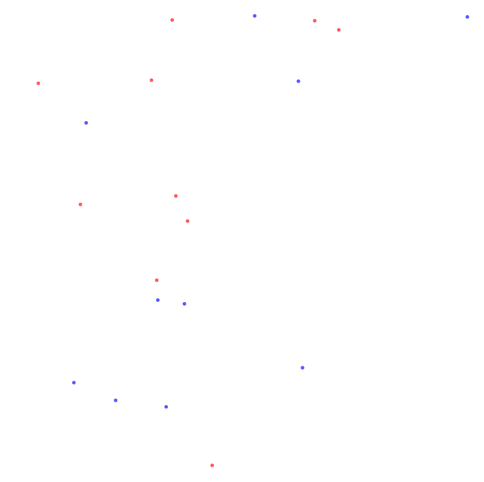

272
68.0


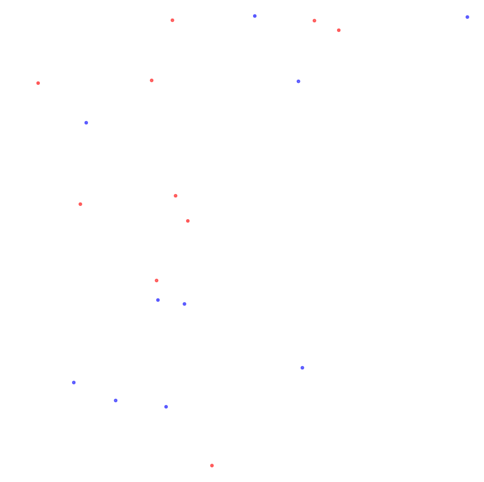

273
68.25


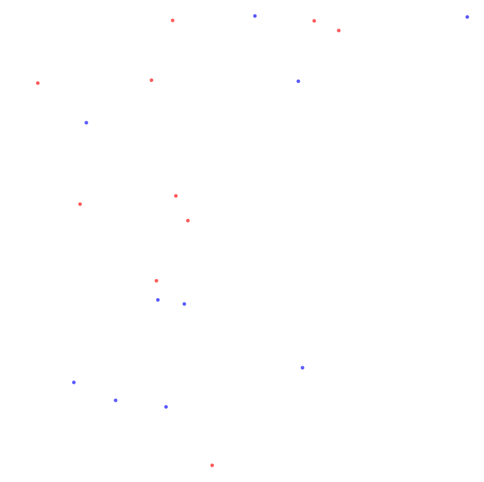

274
68.5


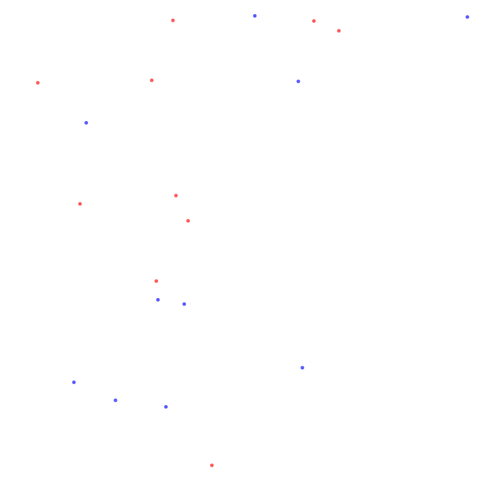

275
68.75


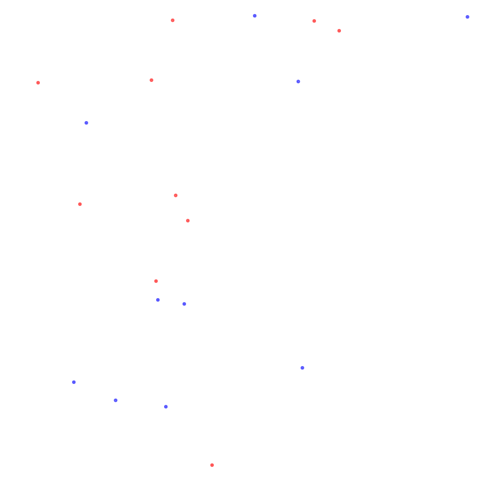

276
69.0


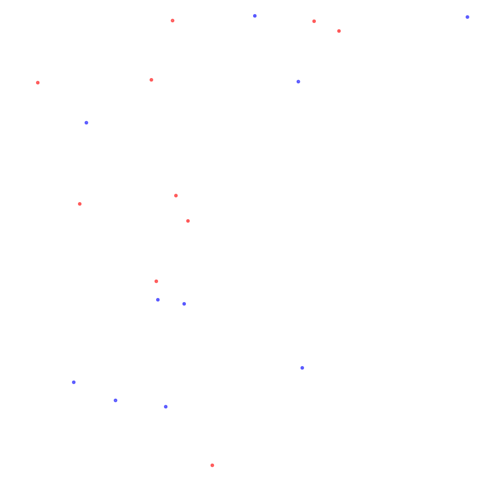

277
69.25


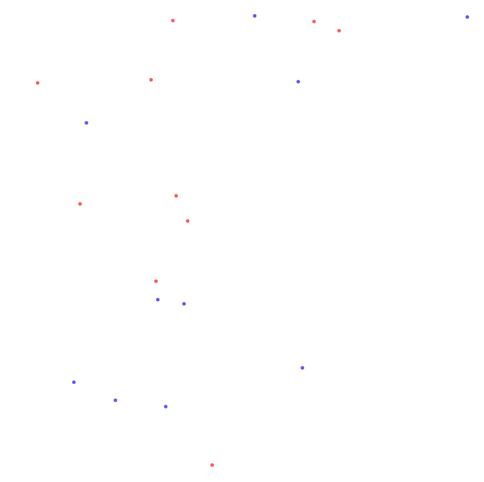

278
69.5


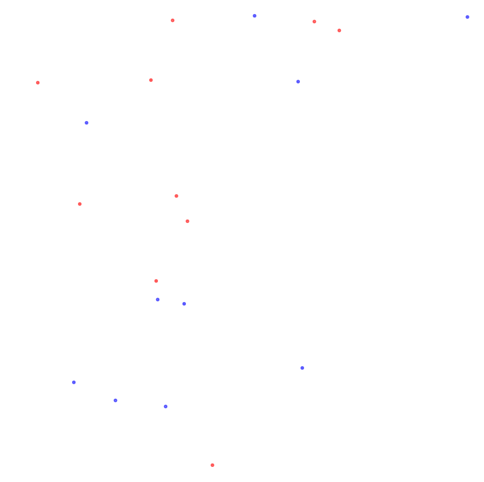

279
69.75


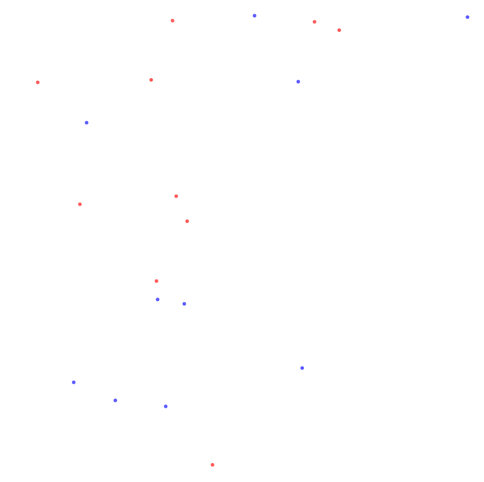

280
70.0


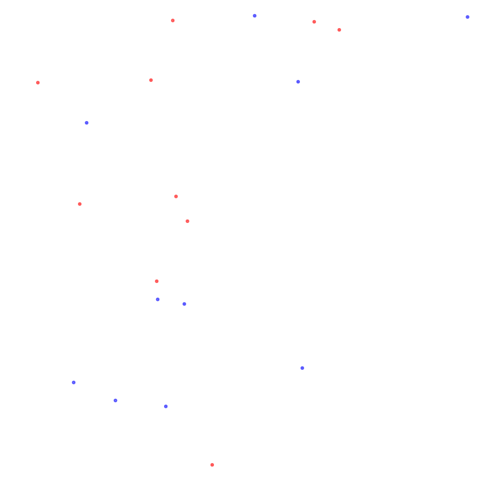

281
70.25


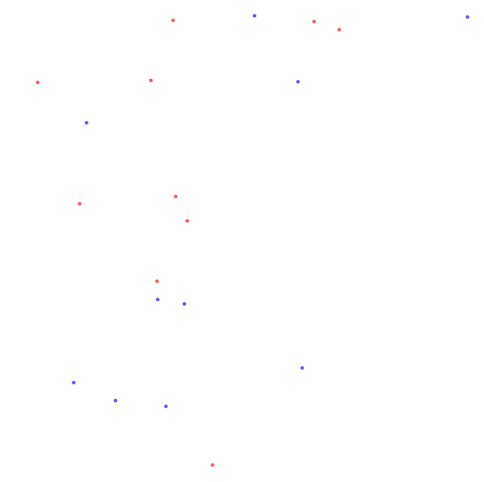

282
70.5


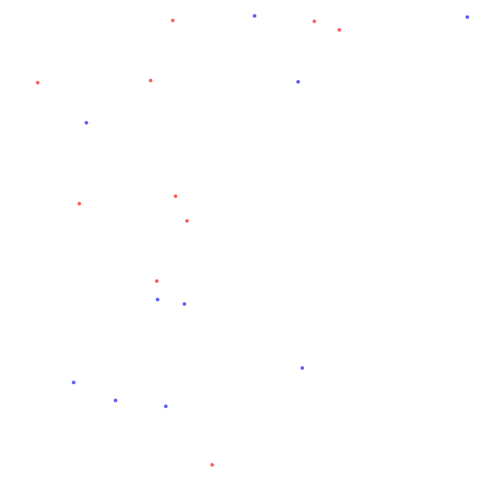

283
70.75


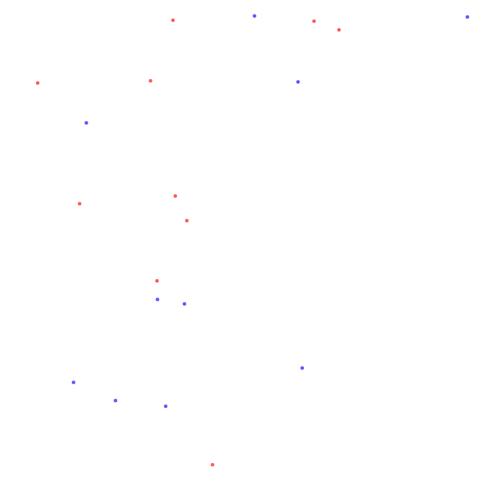

284
71.0


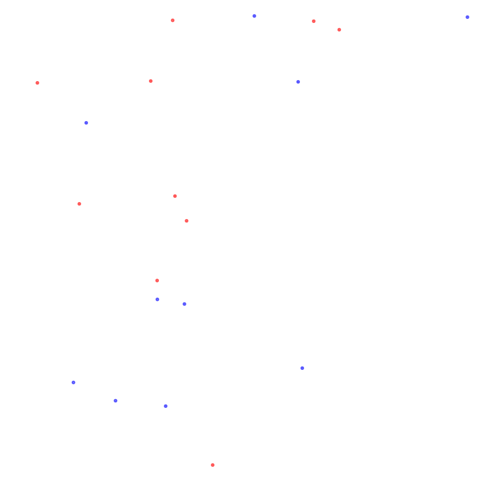

285
71.25


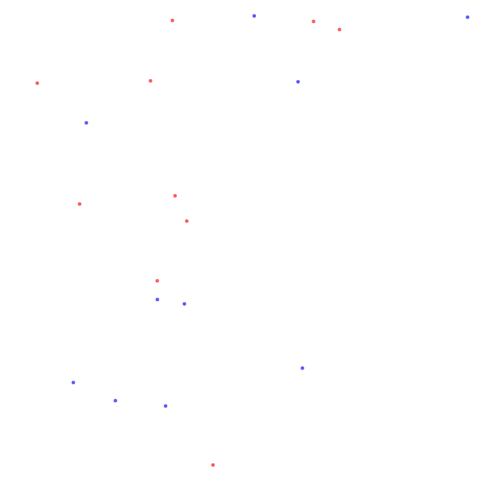

286
71.5


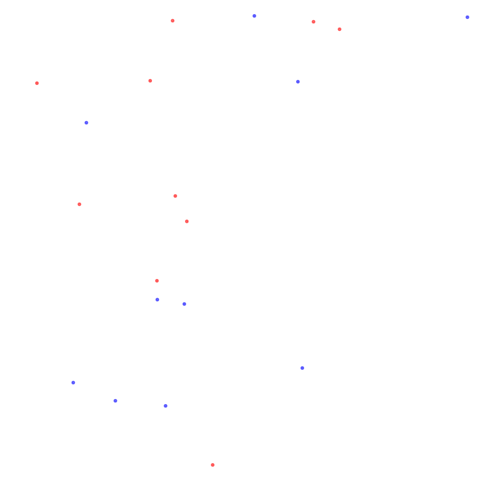

287
71.75


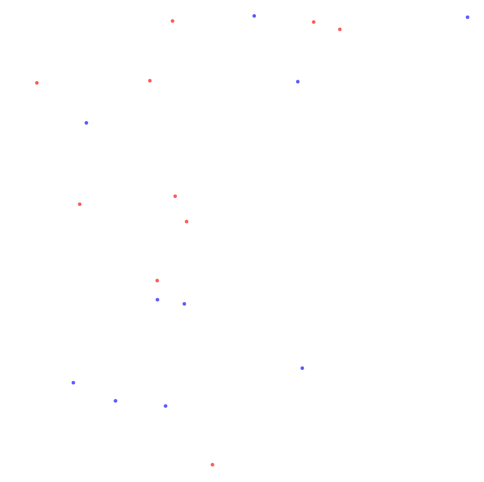

288
72.0


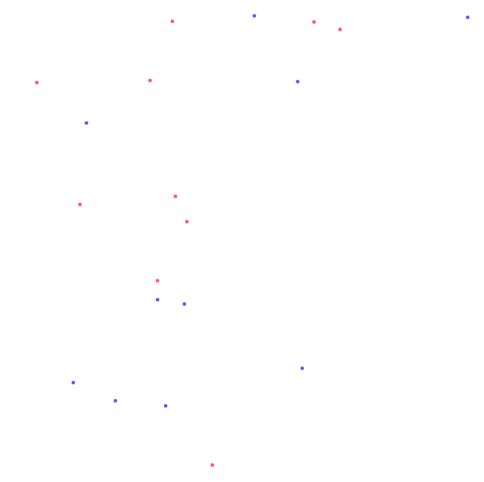

289
72.25


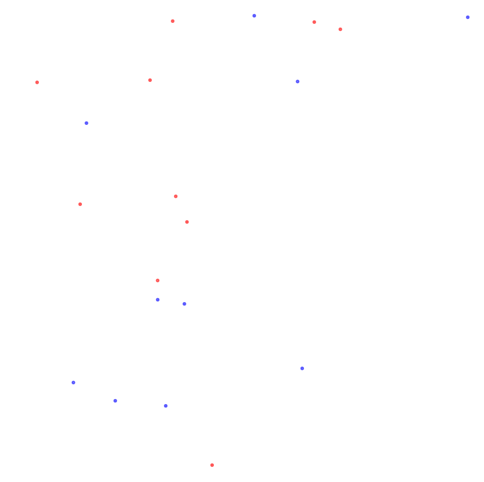

290
72.5


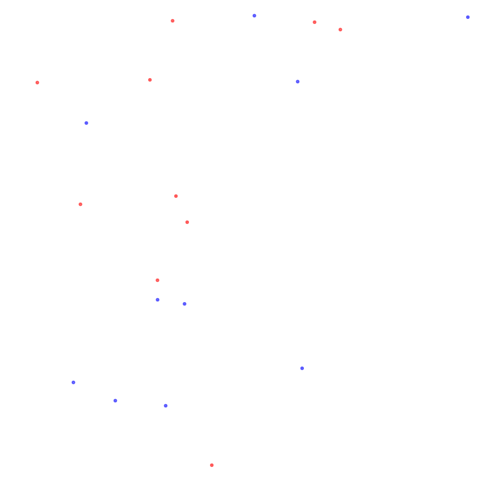

291
72.75


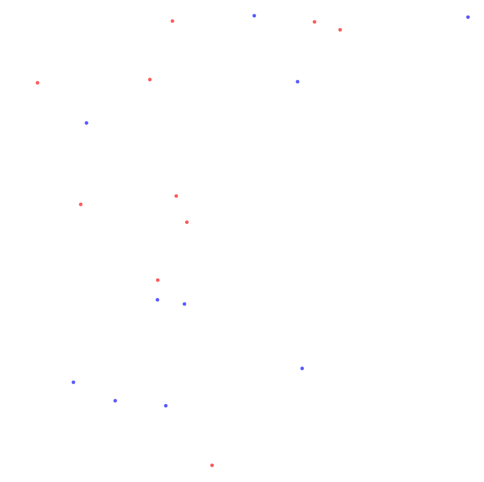

292
73.0


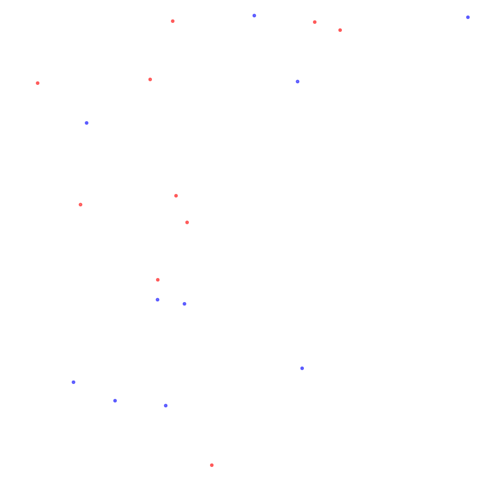

293
73.25


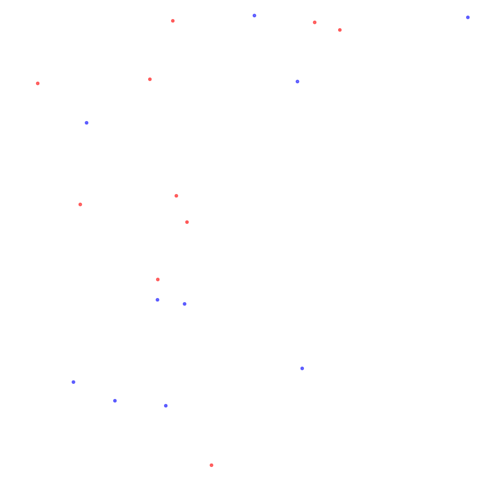

294
73.5


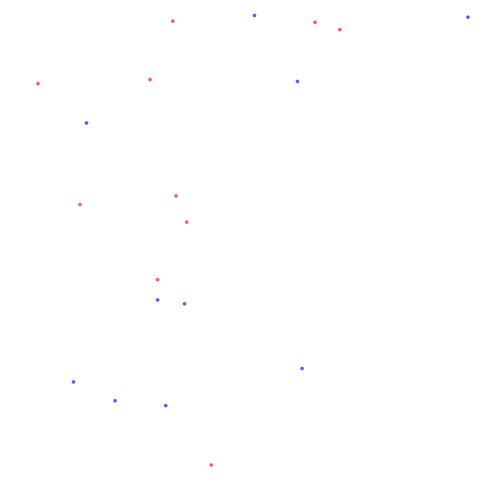

295
73.75


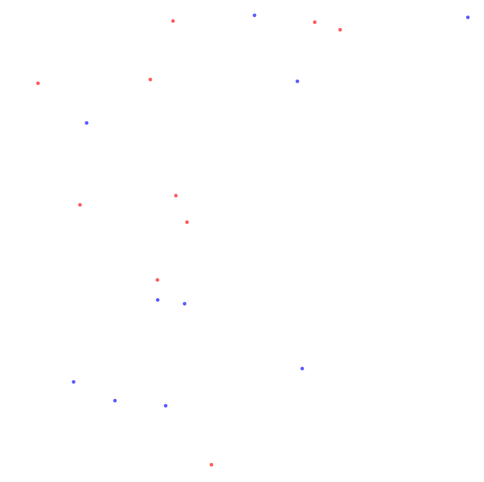

296
74.0


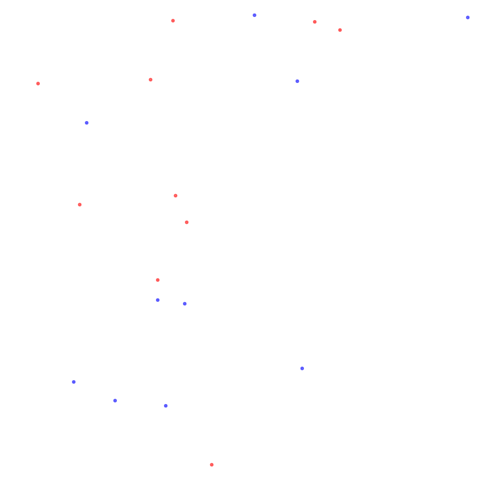

297
74.25


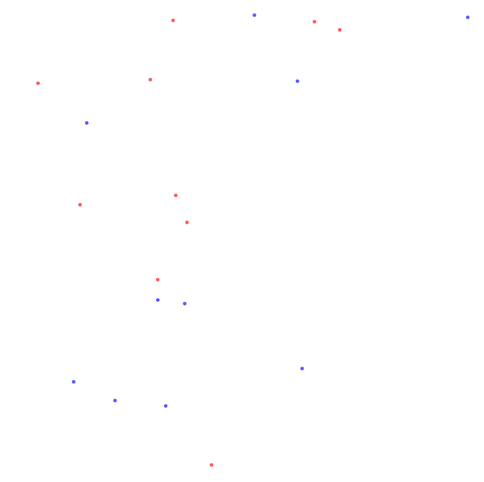

298
74.5


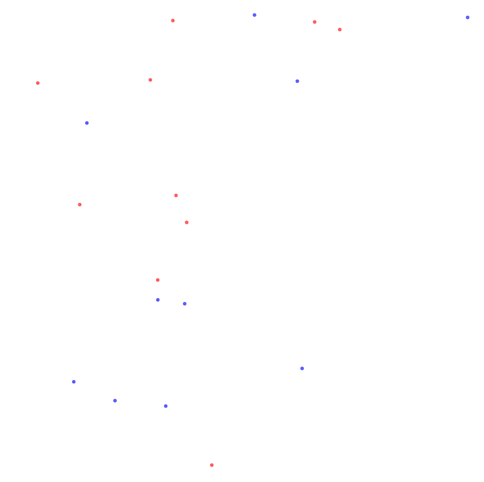

299
74.75


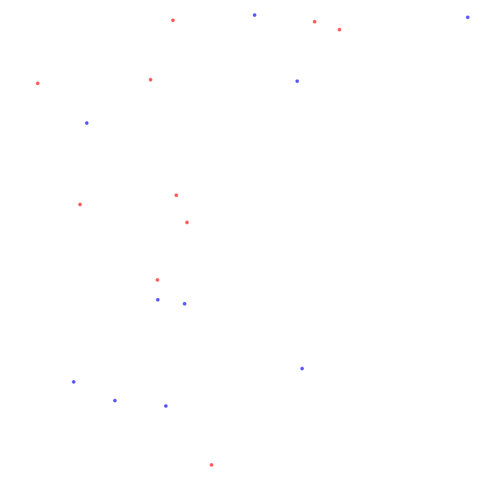

300
75.0


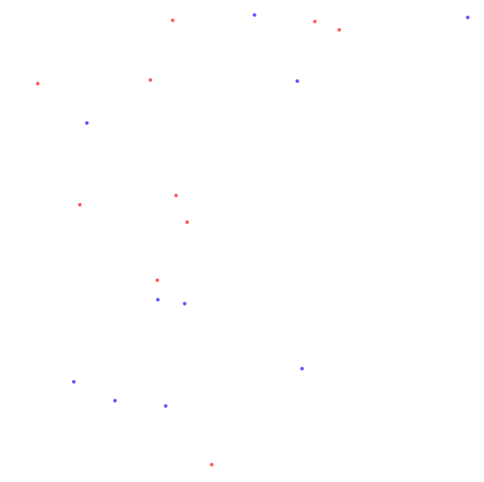

301
75.25


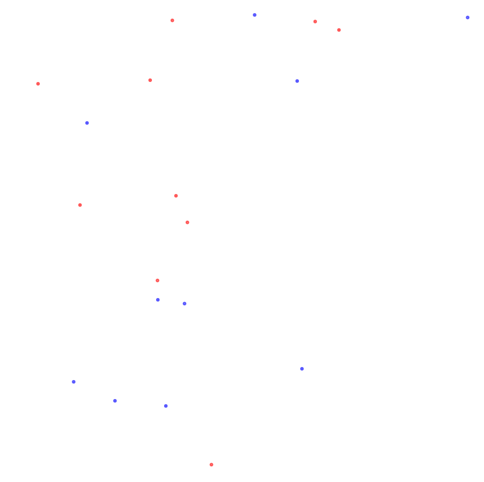

302
75.5


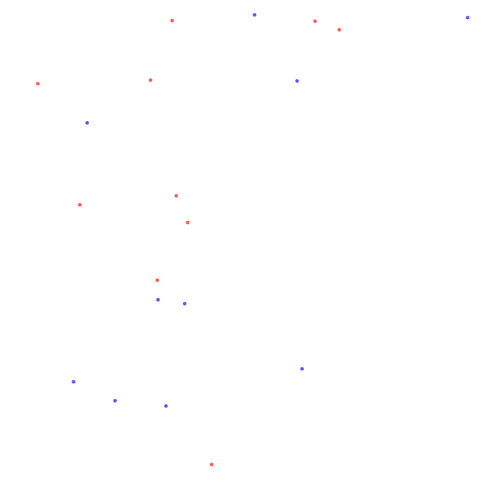

303
75.75


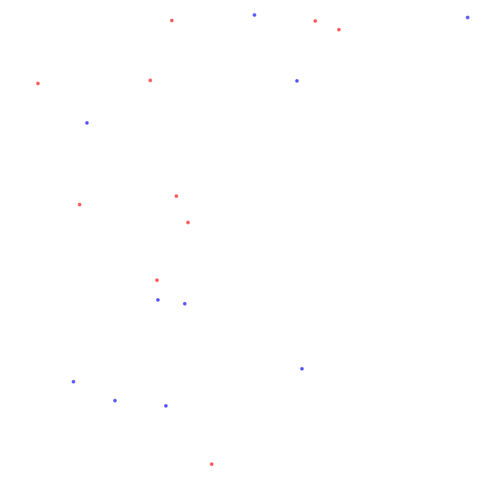

304
76.0


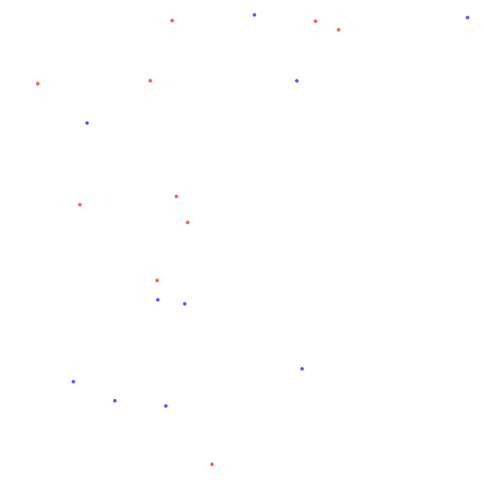

305
76.25


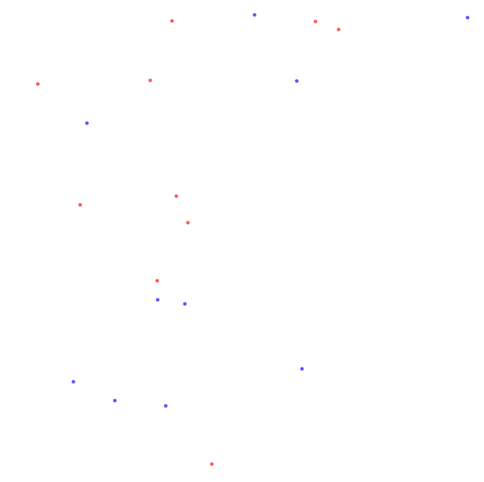

306
76.5


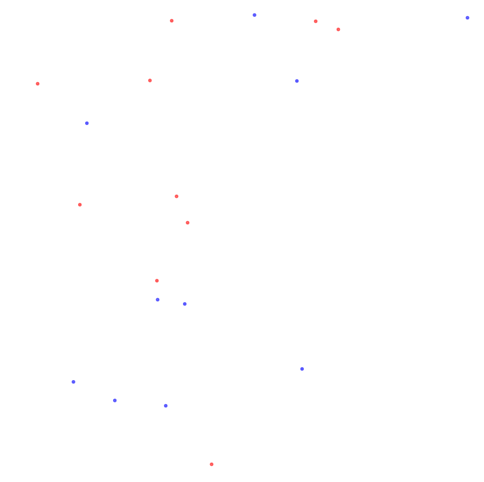

307
76.75


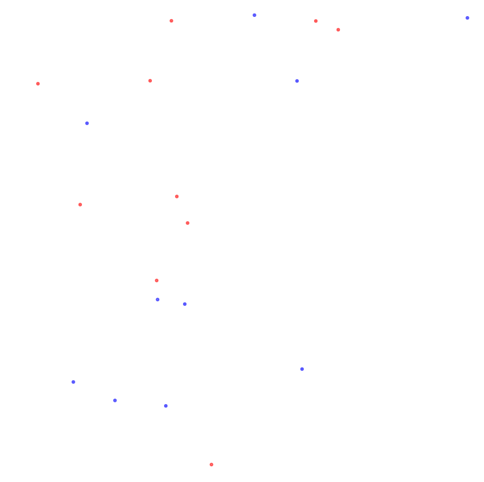

308
77.0


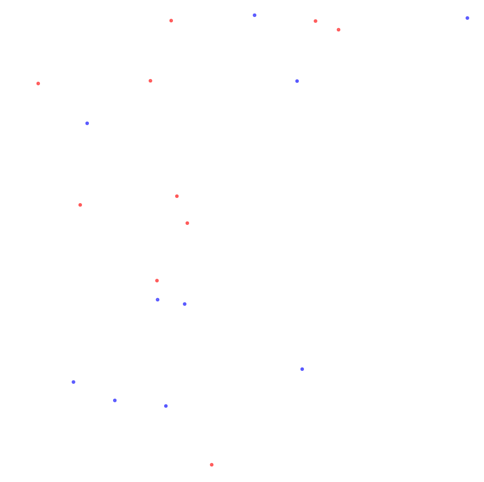

309
77.25


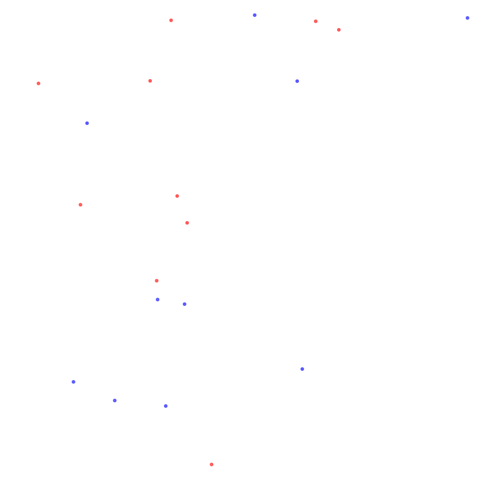

310
77.5


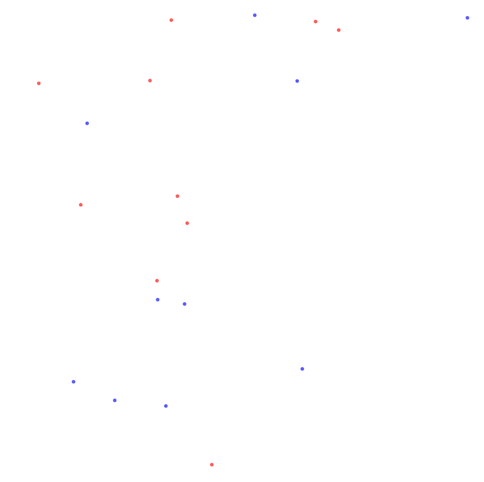

311
77.75


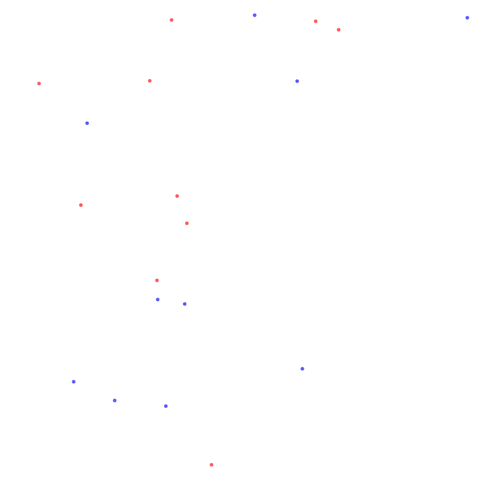

312
78.0


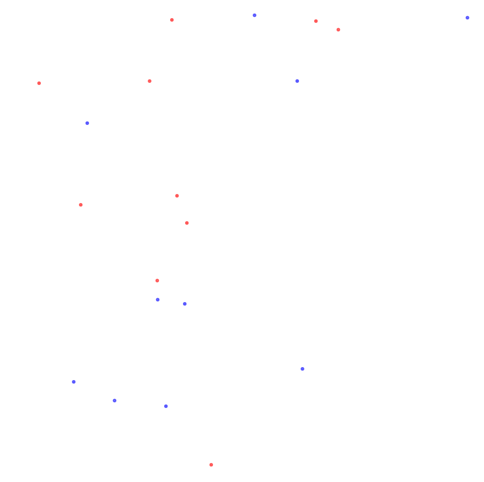

313
78.25


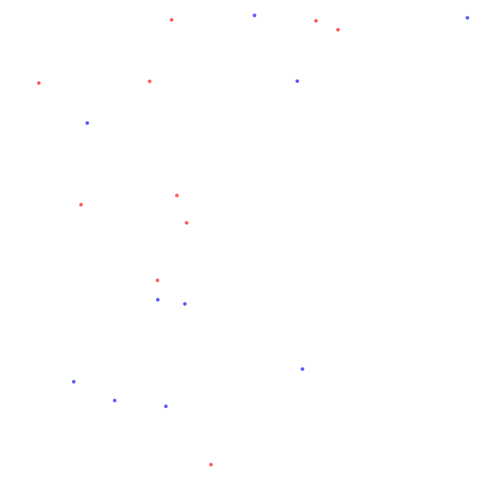

314
78.5


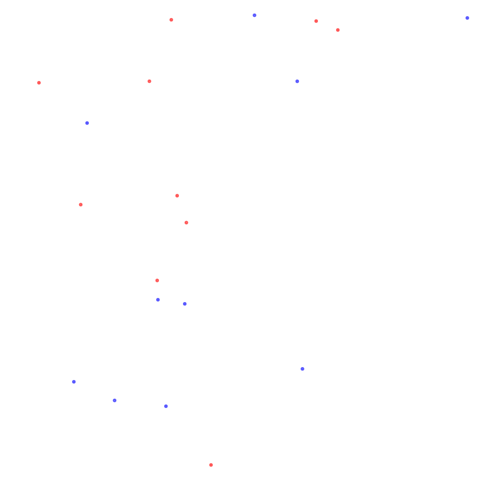

315
78.75


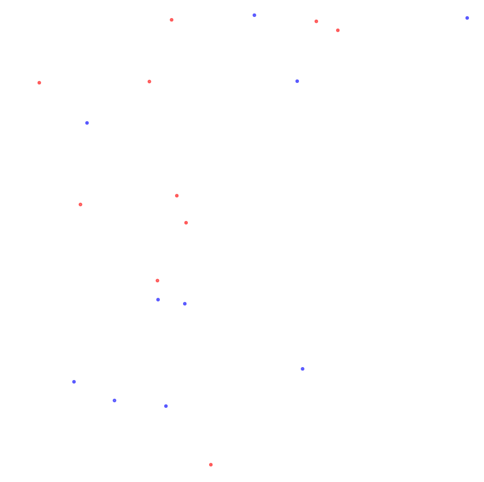

316
79.0


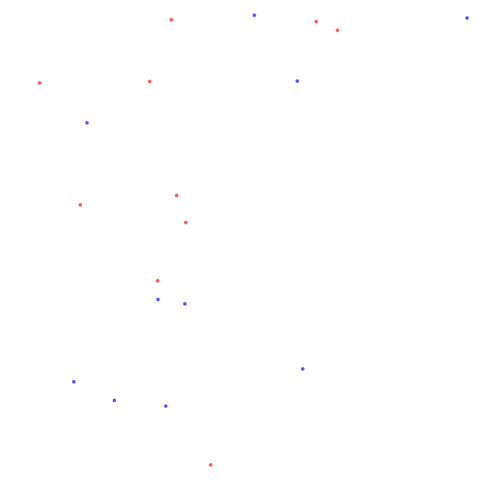

317
79.25


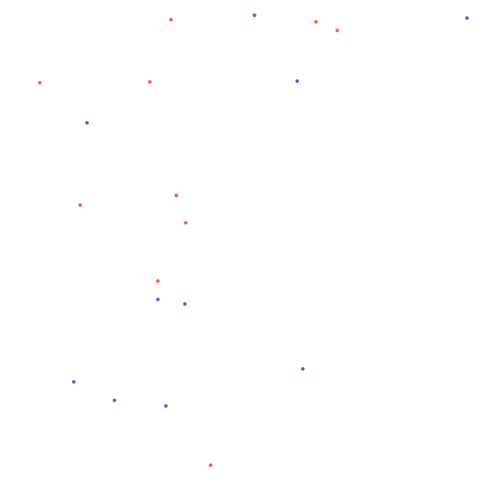

318
79.5


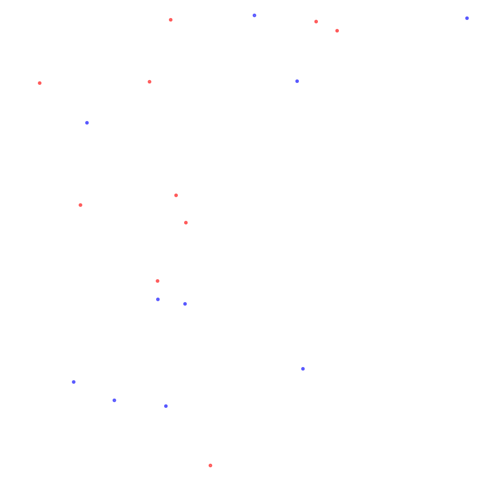

319
79.75


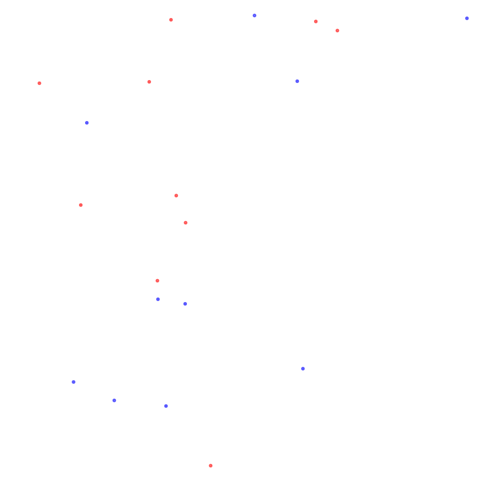

320
80.0


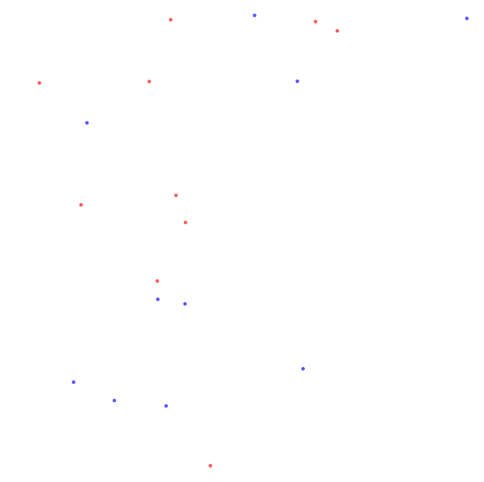

321
80.25


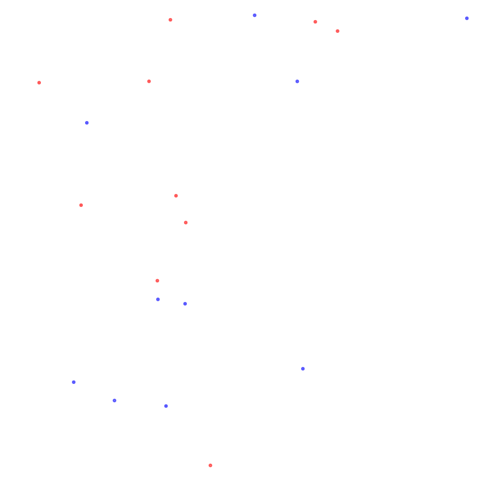

322
80.5


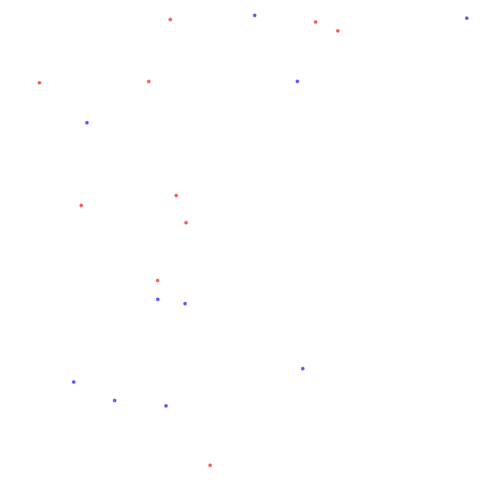

323
80.75


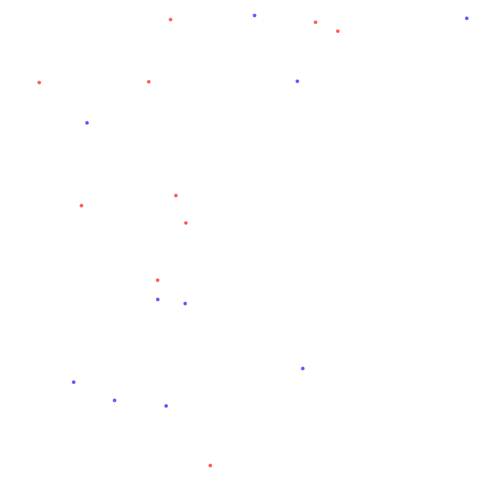

324
81.0


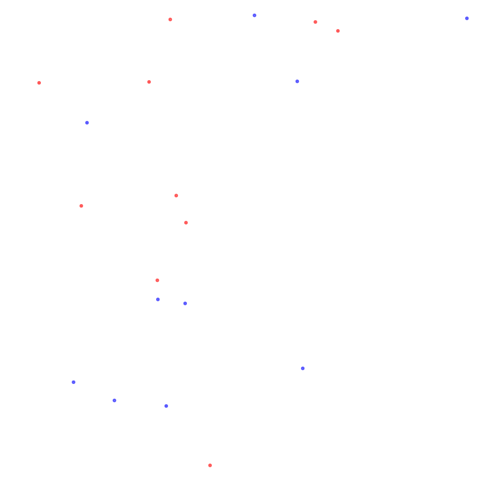

325
81.25


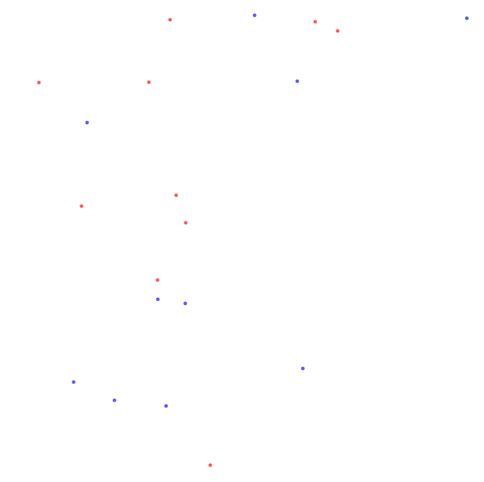

326
81.5


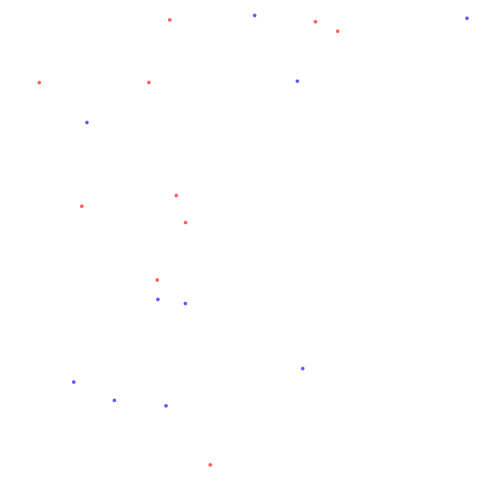

327
81.75


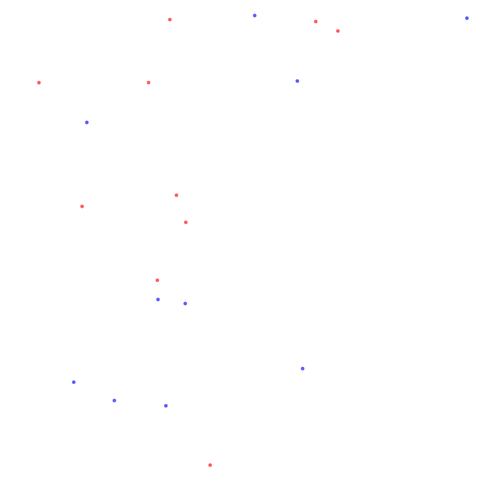

328
82.0


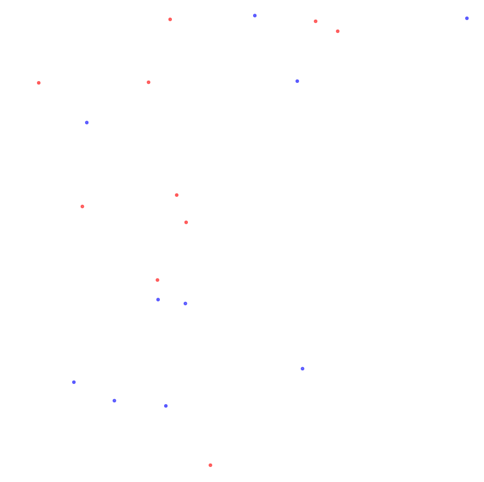

329
82.25


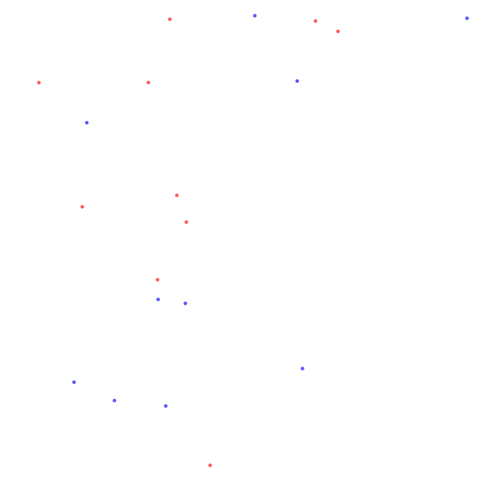

330
82.5


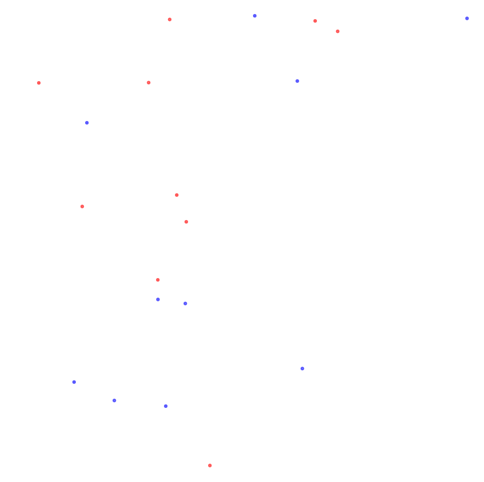

331
82.75


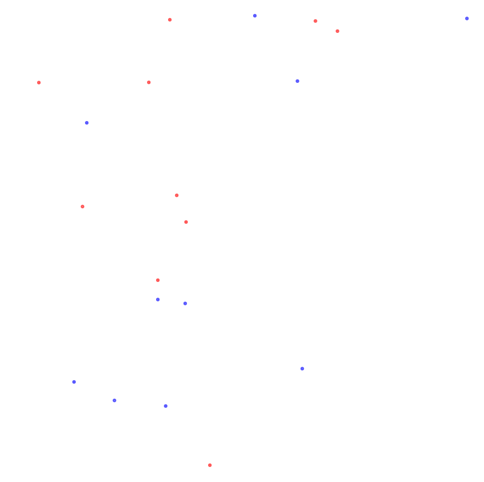

332
83.0


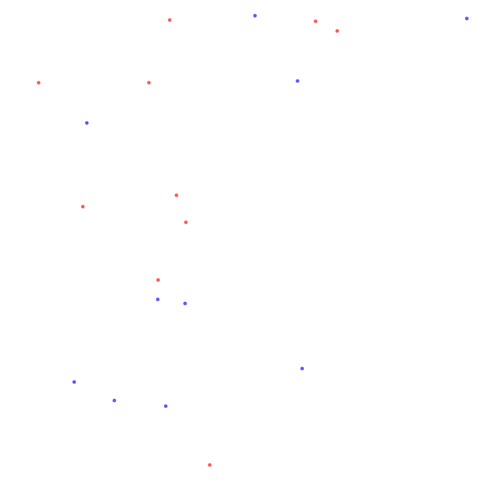

333
83.25


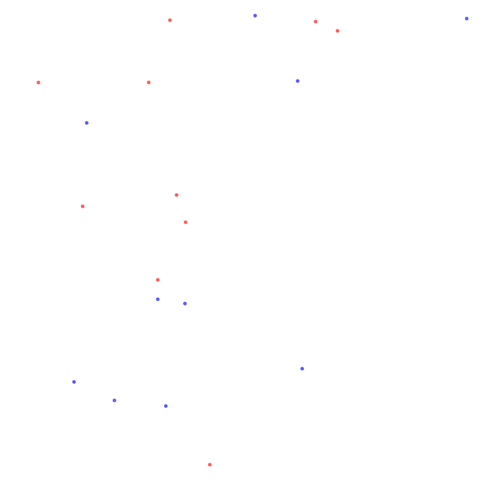

334
83.5


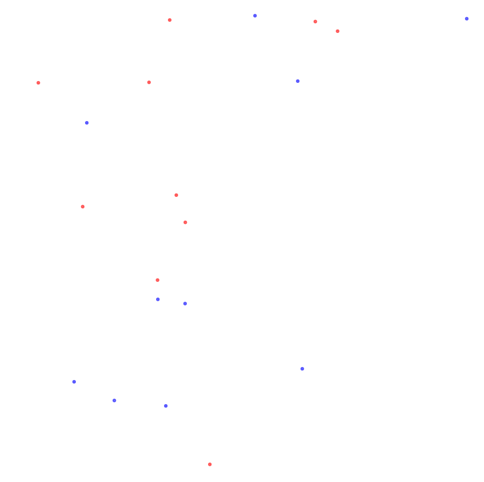

335
83.75


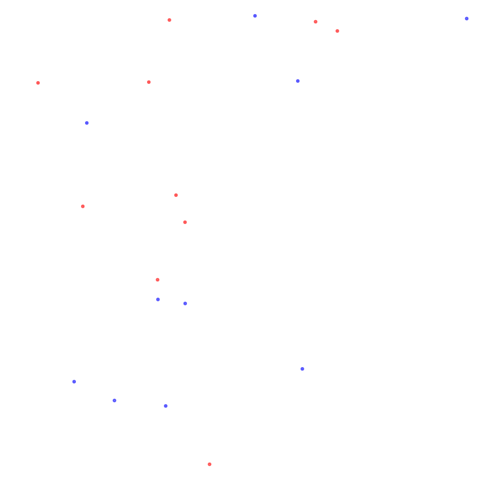

336
84.0


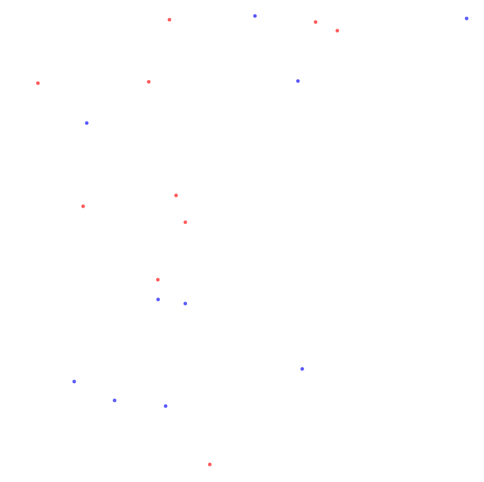

337
84.25


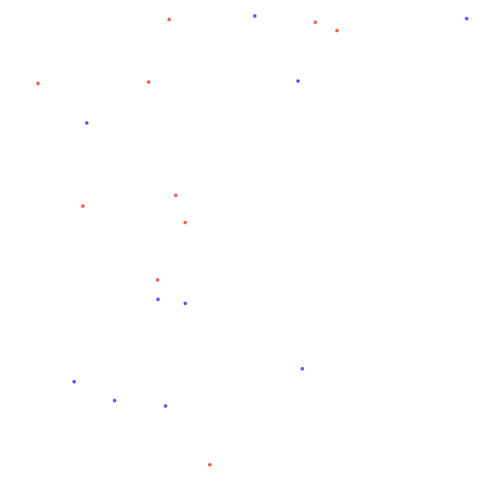

338
84.5


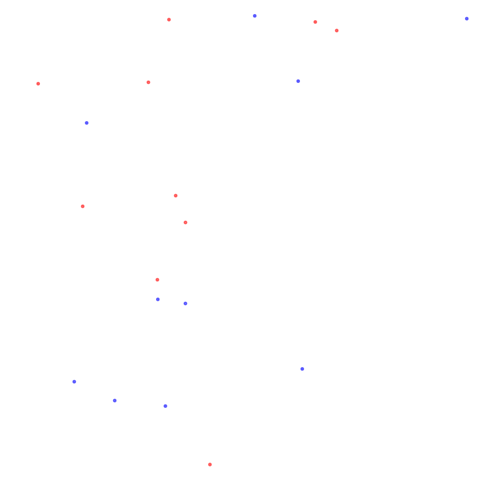

339
84.75


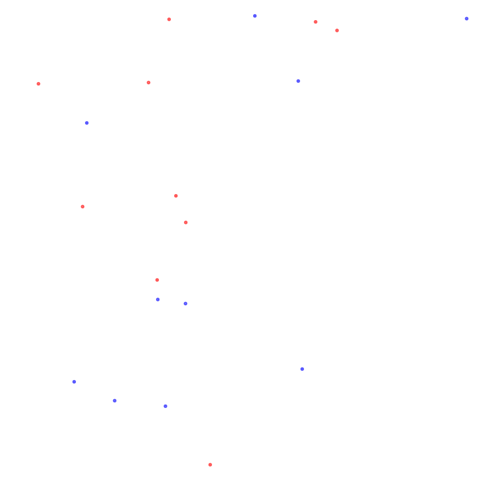

340
85.0


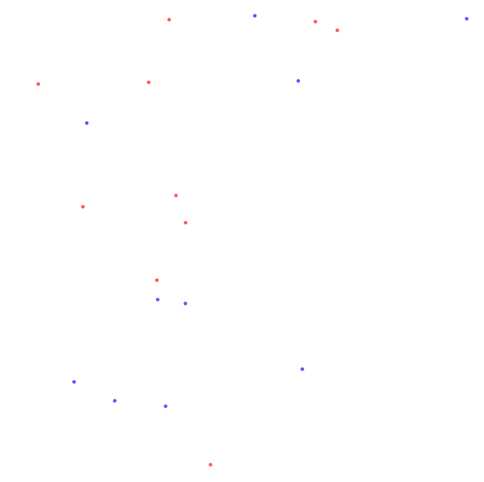

341
85.25


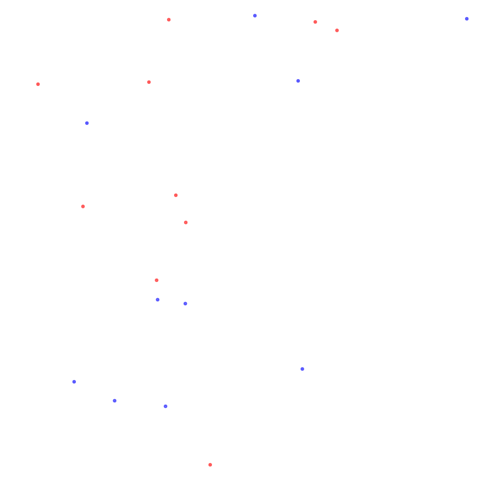

342
85.5


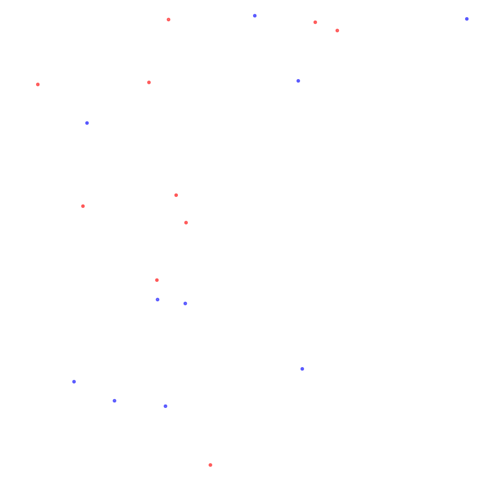

343
85.75


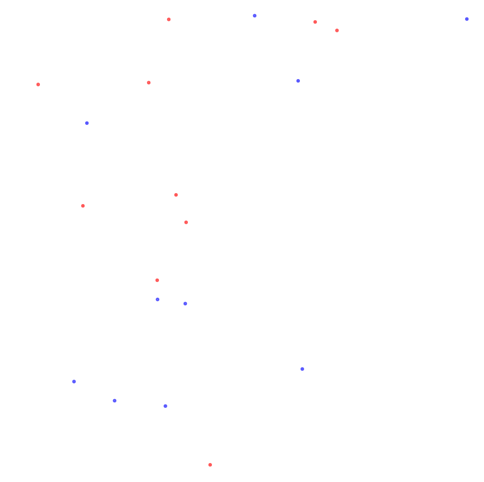

344
86.0


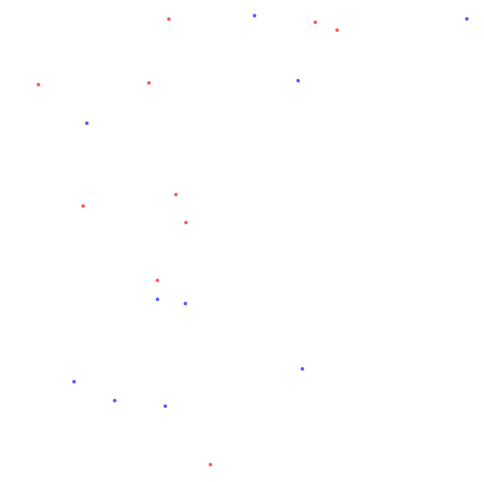

345
86.25


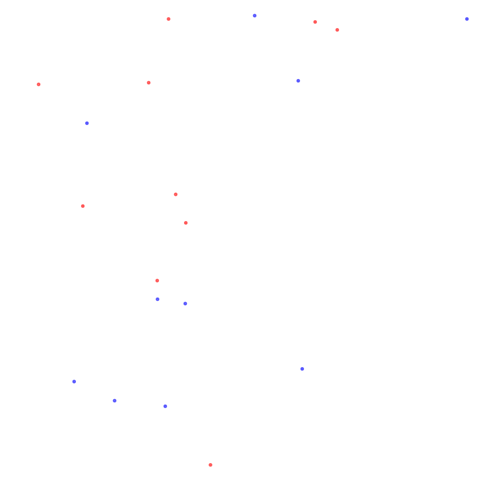

346
86.5


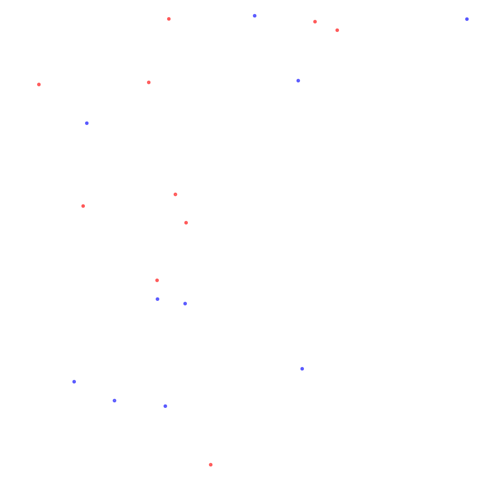

347
86.75


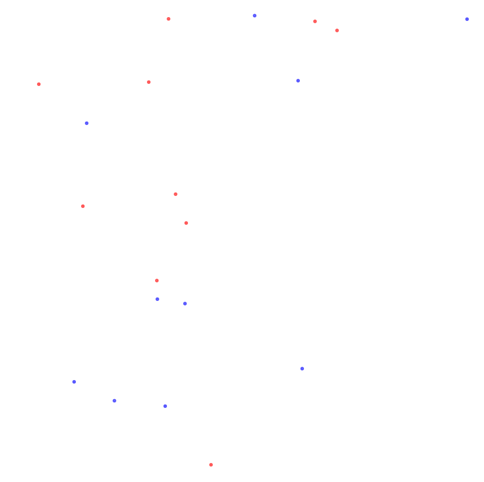

348
87.0


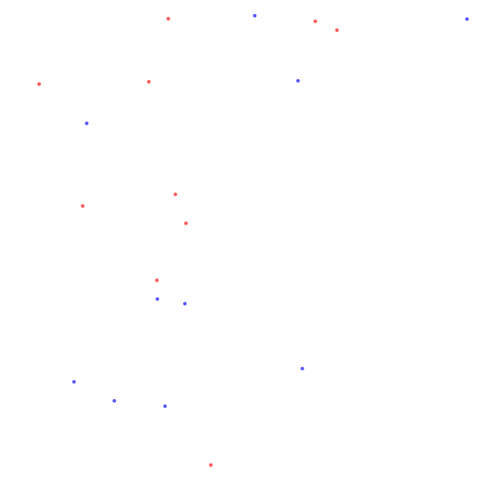

349
87.25


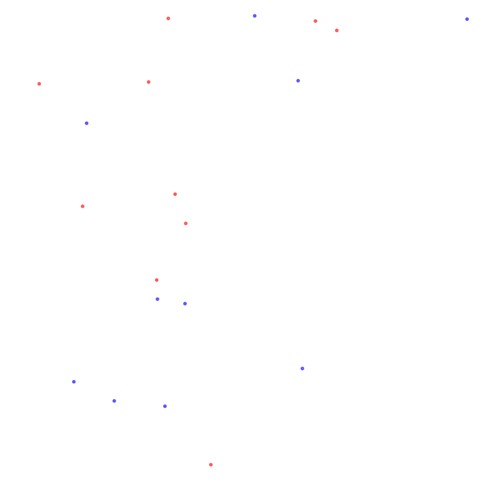

350
87.5


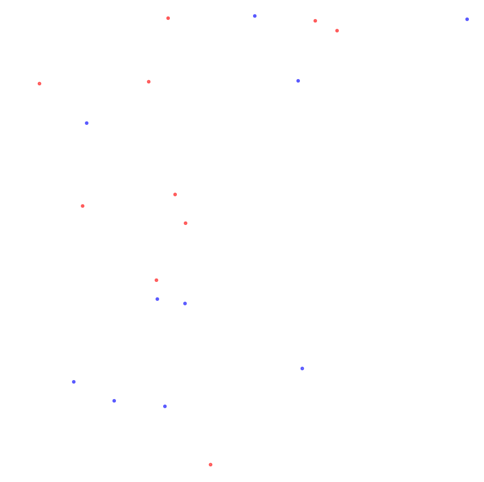

351
87.75


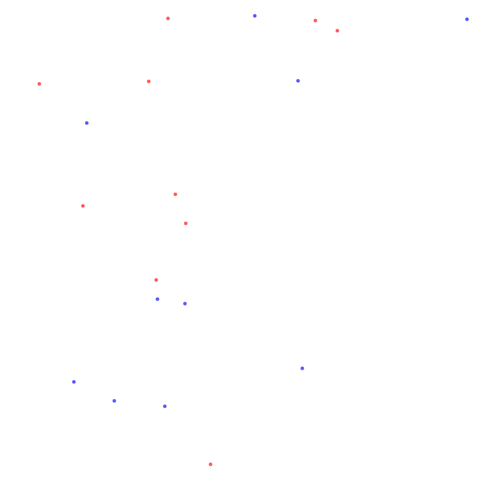

352
88.0


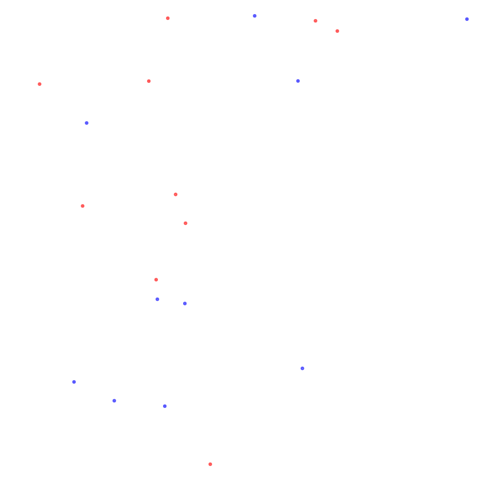

353
88.25


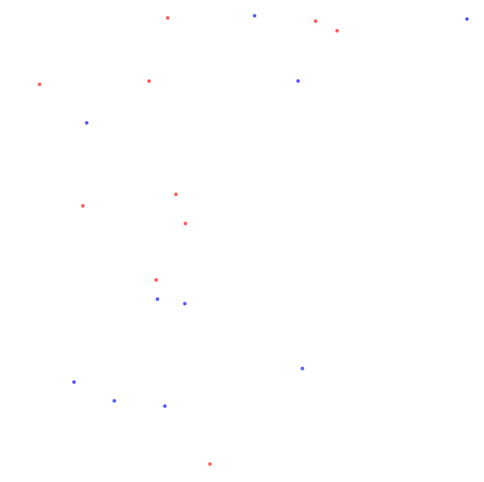

354
88.5


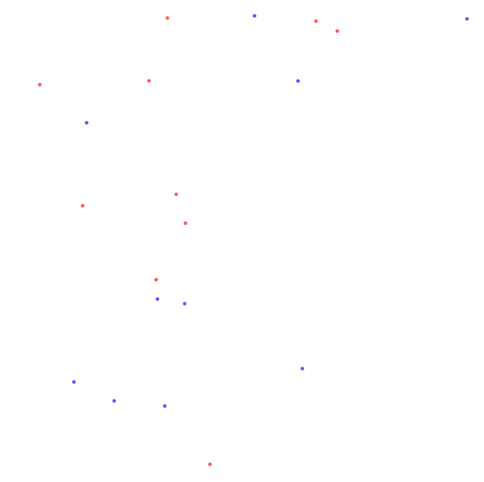

355
88.75


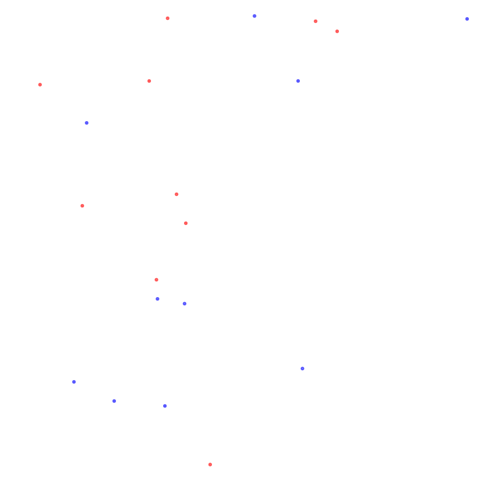

356
89.0


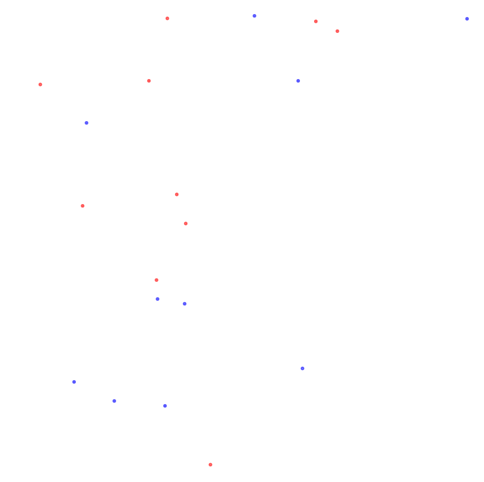

357
89.25


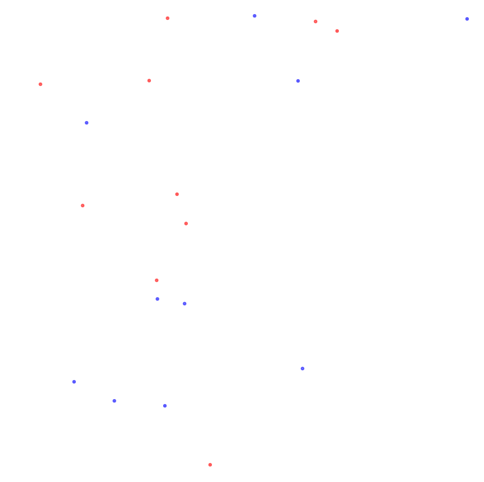

358
89.5


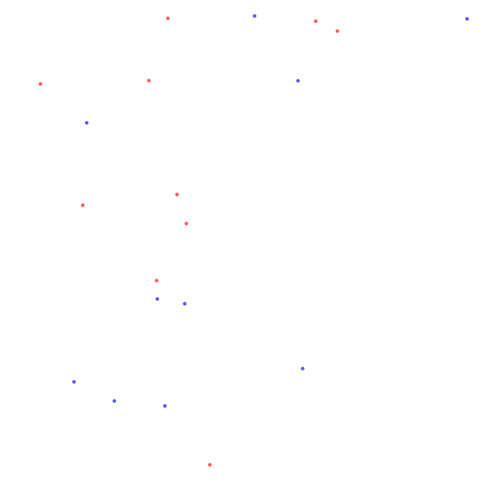

359
89.75


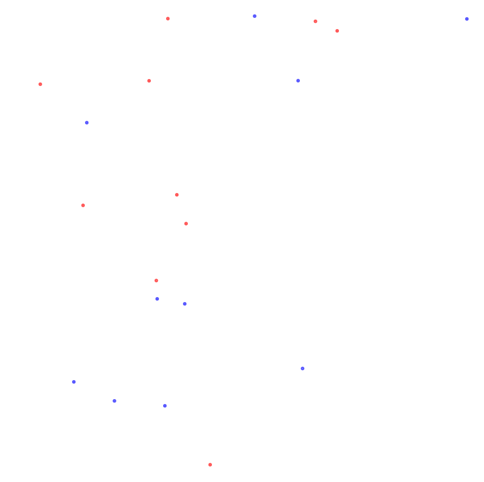

360
90.0


In [21]:
# In[Simulation]
time = 0
iteration = 1
MAX_DISTANCE = np.sqrt(2*(SPACE_SIZE/2)**2)

while time < TIME_SIMU :
    #Paiwise distance.
    coordinates_diff = ((positions[:, None, :] - positions[None, :, :]))
    coordinates_diff = torch.remainder(coordinates_diff-(SPACE_SIZE/2),SPACE_SIZE)-(SPACE_SIZE/2)
    distances = torch.stack([torch.norm(coordinates_diff[i], dim=1)
                             for i in range(0, len(coordinates_diff))])
    is_greater_than_max = torch.any(distances > MAX_DISTANCE)

    if is_greater_than_max:
      print("At least one distance is greater than the max distance.")

    # force_field calculation
    force_field = force_field_inbox(coordinates_diff, distances, Req=R_EQ,
                                    R0=R_0, Frep=F_REP, Fadh=F_ADH,
                                    coeff_a = COEFF_CARRE, coeff_rep = 0.5)
    # displacement computing
    displacement = MU * force_field * DELTA_T +\
                   V0 * direction * DELTA_T
    # cells position evolution
    positions += displacement

    # border conditions
    positions = torch.remainder(positions, SPACE_SIZE)

    for cell, position, direct in zip(cells, positions, direction):
        cell.position = position.to(device)
        cell.direction = direct.to(device)
        # print(cell, position, direct)
    # direction update for next step
    direction = autovel(displacement, direction, TAU, NOISE, DELTA_T)
    # direction = autovel2( direction, noise)

    # plot the result
    marker_radius = 1.1
    marker_size = (np.pi) * marker_radius ** 2
    if iteration % PLOT_INTERVAL == 0:
      plot_environment(cells, path_saving = PATH, space_size = SPACE_SIZE, req=R_EQ, iteration = iteration)

    time += DELTA_T
    print(time)
    iteration += 1